In [51]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt   
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams.update({"axes.grid" : True, "grid.color": "black", "grid.alpha":"0.25", "grid.linestyle": "--"})
plt.rcParams.update({'font.size': 14})
from HANKModel import HANKModelClass
from funktioner import *
import numba as nb  

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
import importlib, funktioner
importlib.reload(funktioner)

<module 'funktioner' from 'c:\\Users\\B307102\\Desktop\\priv\\SpecialeHANK\\Adv_macro_het_agents\\AdvMacroHet\\Speciale 2025\\BASE3\\funktioner.py'>

In [53]:
# --- use YOUR package-level exports (this works with your repo) ---
from GEModelTools import (
    simulate_hh_forwards_exo_transpose,    # OK in your version
    simulate_hh_forwards_endo_transpose    # OK in your version
)  # :contentReference[oaicite:2]{index=2}

In [54]:
model = HANKModelClass(name='baseline')
model.find_ss(do_print=True)
model._compute_jac_hh()
model.calc_MPC()

 Y =   1.0000
 r    =   0.0050
 A    =   1.2505
 pD   =   1.2505
Discrepancy in A =   0.00000000
Discrepancy in Y =   0.00000000
MPC = 0.36, iMPC[0,0] = 0.36
annual_MPC = 0.50


In [55]:
model.compute_jacs(skip_hh=False,skip_shocks=False)

In [56]:
model.find_IRFs(shocks=['eps_i'],do_print=False)

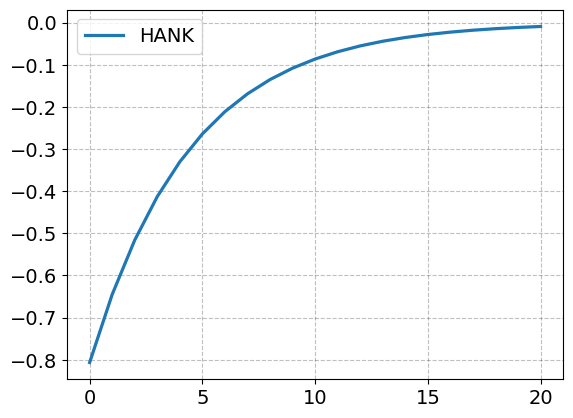

In [57]:
plt.plot(model.IRF['Y'][:21]*100, label='HANK', linewidth=2.3)
plt.legend()
plt.show()

In [8]:
print("max |clearing_Y| (full) first 60:",
      float(np.nanmax(np.abs(model.path.clearing_Y[:60]))))

max |clearing_Y| (full) first 60: nan


C:\Users\B307102\AppData\Local\Temp\ipykernel_31936\2672216891.py:2: RuntimeWarning: All-NaN slice encountered
  float(np.nanmax(np.abs(model.path.clearing_Y[:60]))))


In [58]:
# Hetero-beliefs version (also 6 states)
model_het = HANKModelClass(name='hank_het6')
model_het.find_ss()
model_het._compute_jac_hh()
model_het.calc_MPC()
model_het.compute_jacs(do_print=False)

MPC = 0.36, iMPC[0,0] = 0.36
annual_MPC = 0.50


In [8]:

E_list = [E_hybrid(model_het.par.T, lam, theta=0.9) for lam in [0.0,0.2,0.4,0.6,0.8,1.0]]
E_by_z = {'Z':E_list, 'ra':E_list}


In [ ]:
# 0) solve once
model_het.find_ss(); model_het.compute_jacs(do_print=False)

In [ ]:
f_endo = funktioner.make_forward_endo('eps_i')
f_exo  = funktioner.forward_exo

In [ ]:
# 0) solve once
model_het.find_ss(); model_het.compute_jacs(do_print=False)

jac_hh_alt = rebuild_jac_hh_hetero_fakenews(
    model_het, E_by_z,
    hh_outputs=('C_hh','A_hh'),
    forward_endo=None,
    forward_exo=None
    # no forward_endo/exo => impact-only
)

In [10]:
#model_het.jac_hh.update(jac_hh_alt)
model_het.compute_jacs(skip_hh=True, do_print=False)

In [11]:
model_het.find_IRFs(shocks=['eps_i'], reuse_G_U=False, do_print=False)

In [ ]:
decomp(model,model_het, plot_test=False)

In [ ]:
decomp(model_sticky,model_het, plot_test=False)

In [ ]:
plt.plot(model_het.IRF['Y'][:21]-model_het.IRF['C_hh'][:21], label='clearing_Y', linestyle='--', linewidth=2.3, color='navy')
plt.title('clearing_Y')
plt.legend()
plt.show()

In [12]:
import numpy as np

# --- your original homogeneous operator (unchanged) ---
def create_alt_M(M, E):
    T, m = M.shape
    assert T == m and E.shape == (T, T)
    M_beh = np.empty_like(M)
    for t in range(T):
        for s in range(T):
            summand = 0.0
            for tau in range(min(s, t) + 1):
                if tau > 0:
                    summand += (E[tau, s] - E[tau - 1, s]) * M[t - tau, s - tau]
                else:
                    summand += E[tau, s] * M[t - tau, s - tau]
            M_beh[t, s] = summand
    return M_beh

# --- EXACT sticky expectations (your function; unchanged) ---
def E_sticky_exp(theta, T=300):
    col = 1 - theta**(1 + np.arange(T))       # cumulative adoption by tau
    E = np.tile(col[:, np.newaxis], (1, T))
    E = np.triu(E, +1) + np.tril(np.ones((T, T)))  # ones at/after s
    return E

# --- NEW: per-z cumulative matrix from lambda_z (heterogeneity enters pre-s) ---
# Intuition: lam_z is the per-period adoption rate BEFORE s.
# Cumulative adoption up to lag tau: 1 - (1 - lam_z)^(tau+1).
# At/after s, agents fully see the realization (lower triangle = 1), just like sticky.
def E_from_lambda_cumulative(T, lam_z):
    """
    Per-z expectations matrix where pre-s entries are *cumulative sums* of geometric
    powers: ΔE[tau,s] = E[tau,s] - E[tau-1,s] = lam_z**(tau+1).
    Post-s (t >= s) entries are 1.

    Example for lam_z=0.2 and column s:
      [0.2, 0.2+0.2^2, 0.2+0.2^2+0.2^3, ...] above the diagonal,
      1 on and below the diagonal.
    """
    import numpy as np
    E = np.zeros((T, T))
    for s in range(T):
        # pre-s cumulative geometric sum
        for tau in range(s + 1):  # tau = s - t
            if lam_z == 1.0:
                E[tau, s] = tau + 1.0
            else:
                E[tau, s] = lam_z * (1.0 - lam_z**(tau + 1)) / (1.0 - lam_z)
        # on/after s: full information
        E[s:, s] = 1.0
    return E

def E_hybrid_cumulative(T, lam, theta_post=None):
    """
    Cumulative E for create_alt_M.

    Pre-s (t < s): ΔE[tau,s] = lam**(tau+1)  ⇒  E[tau,s] = sum_{k=1}^{tau+1} lam**k
    Post-s (t >= s):
        - if theta_post is None: full revelation ⇒ E[t,s] = 1
        - else: ΔE[s+k,s] = theta_post**k  ⇒  E[s+k,s] = sum_{j=0}^{k} theta_post**j
    """
    import numpy as np
    E = np.zeros((T, T))
    # pre-s cumulative
    for s in range(T):
        for tau in range(s + 1):
            if lam == 1.0:
                E[tau, s] = tau + 1.0
            else:
                E[tau, s] = lam * (1.0 - lam**(tau + 1)) / (1.0 - lam)

        # post-s cumulative
        if theta_post is None:
            E[s:, s] = 1.0
        else:
            run = 0.0
            for k in range(T - s):
                run += theta_post**k  # cumulative of post-shock arrivals
                E[s + k, s] = run
    return E


# --- weights & Markov helpers (unchanged logic) ---
def _z_weights_from_ss(model):
    D = model.ss.D                   # (Nfix, Nz, Na)
    w = np.sum(D, axis=(0, 2))       # (Nz,)
    total = np.sum(w)
    if not np.isfinite(total) or total <= 0:
        raise ValueError("Invalid steady-state mass; cannot compute z-weights.")
    return w / total

def _find_markov_P(model, Nz):
    for name in ['Pi','P','pi_z','Pz','Pi_z','PiZ','P_Z']:
        if hasattr(model.par, name):
            P = np.asarray(getattr(model.par, name))
            if P.ndim == 2 and P.shape == (Nz, Nz):
                if np.allclose(P.sum(axis=1), 1.0, atol=1e-10) and np.all(P >= -1e-12):
                    return P
    return None

def _markov_weight_history(w0, P, T):
    w_hist = np.zeros((T, w0.size))
    w = w0.copy()
    for t in range(T):
        w_hist[t] = w
        w = w @ P
    return w_hist

# build an effective cumulative matrix by (possibly) time-varying z-weights
def _create_E_eff_markov_weighted(E_list, w0, P, T):
    Nz = len(E_list)
    for iz, Ez in enumerate(E_list):
        Ez = np.asarray(Ez)
        if Ez.shape != (T, T):
            raise ValueError(f"E_list[{iz}] has shape {Ez.shape}, expected {(T,T)}")
    w_hist = _markov_weight_history(w0, P, T) if P is not None else None
    E_eff = np.zeros((T, T))
    for s in range(T):
        for tau in range(s + 1):        # only tau<=s is used by the transform
            w = w_hist[s - tau] if w_hist is not None else w0
            E_eff[tau, s] = sum(w[iz] * E_list[iz][tau, s] for iz in range(Nz))
    return E_eff

# --- single-entry solver: homogeneous (pass E) OR per-z (pass dict) ---
def solve_alt_exp(model, E_or_Ebyz, sticky_vars=('Z','ra')):
    T  = int(model.par.T)
    Nz = int(model.par.Nz)
    model_sticky = model.copy()

    hetero = isinstance(E_or_Ebyz, dict)
    if hetero:
        w0 = _z_weights_from_ss(model_sticky)
        P  = _find_markov_P(model_sticky, Nz)

    n_updated = 0
    for out_name in ['C_hh','A_hh']:
        for in_name in sticky_vars:
            key = (out_name, in_name)
            if key not in model_sticky.jac_hh:
                continue
            M = model_sticky.jac_hh[key].copy()  # (T,T)

            if hetero and (in_name in E_or_Ebyz):
                E_list = E_or_Ebyz[in_name]      # list of Nz cumulative matrices
                if len(E_list) != Nz:
                    raise ValueError(f"{in_name}: need {Nz} matrices, got {len(E_list)}")
                E_eff = _create_E_eff_markov_weighted(E_list, w0, P, T)
                J = create_alt_M(M, E_eff)
                model_sticky.jac_hh[key] = J
                n_updated += 1
            elif not hetero:
                E = np.asarray(E_or_Ebyz)        # single cumulative matrix
                if E.shape != (T, T):
                    raise ValueError(f"Homogeneous E must be {(T,T)}, got {E.shape}")
                J = create_alt_M(M, E)
                model_sticky.jac_hh[key] = J
                n_updated += 1
            # else: hetero but no matrix for this input -> leave unchanged

    mode_txt = "heterogeneous (per-z cumulative)" if hetero else "homogeneous"
    print(f"Applied alternative expectations for {tuple(sticky_vars)} — {mode_txt}. "
          f"Updated {n_updated} HH Jacobians.")
    model_sticky.compute_jacs(skip_hh=True, skip_shocks=False)
    model_sticky.find_IRFs(shocks=['eps_i'], do_print=False)
    return model_sticky


In [13]:
import numpy as np

def E_hybrid_cumulative_single(T, lam, theta_post=None):
    """
    Cumulative E for create_alt_M.

    Pre-s (t < s): ΔE[tau,s] = lam**(tau+1)  ⇒  E[tau,s] = sum_{k=1}^{tau+1} lam**k
    Post-s (t >= s):
        - if theta_post is None: full revelation ⇒ E[t,s] = 1
        - else: ΔE[s+k,s] = theta_post**k  ⇒  E[s+k,s] = sum_{j=0}^{k} theta_post**j
    """
    E = np.zeros((T, T))
    # pre-s cumulative
    for s in range(T):
        for tau in range(s + 1):
            if lam == 1.0:
                E[tau, s] = tau + 1.0
            else:
                E[tau, s] = lam * (1.0 - lam**(tau + 1)) / (1.0 - lam)
        # post-s cumulative
        if theta_post is None:
            E[s:, s] = 1.0
        else:
            run = 0.0
            for k in range(T - s):
                run += (theta_post ** k)
                E[s + k, s] = run
    return E

def build_E_by_z_from_lambda(T, lambda_by_z, inputs=('Z','ra'), theta_post=None):
    """
    Turn a lambda vector (length Nz) into the per-z expectation matrices dict:
      {'Z':[E_z0,...], 'ra':[E_z0,...], ...}

    theta_post can be:
      - None (full info after s),
      - a scalar (same post-shock decay for all z),
      - a vector of length Nz (different post-shock decay per z).
    """
    lambda_by_z = np.asarray(lambda_by_z, dtype=float)
    Nz = lambda_by_z.size

    # broadcast theta_post
    if theta_post is None or np.isscalar(theta_post):
        theta_vec = np.full(Nz, 1.0 if theta_post is None else float(theta_post))
        theta_vec[theta_post is None] = 1.0  # not used, just explicit
    else:
        theta_vec = np.asarray(theta_post, dtype=float)
        if theta_vec.size != Nz:
            raise ValueError(f"theta_post length {theta_vec.size} must equal Nz={Nz}")

    # build one E per z
    E_list = [E_hybrid_cumulative_single(T, lam=float(lambda_by_z[iz]),
                                         theta_post=None if theta_post is None else float(theta_vec[iz]))
              for iz in range(Nz)]

    # same set for every input you want to treat as expectation-driven
    return {i: [E.copy() for E in E_list] for i in inputs}


In [14]:
import numpy as np

def E_per_z_sticky_style(T, lam):
    """
    Pre-s: ΔE[tau,s] = lam**(tau+1)  (so E[tau,s] = sum_{k=1}^{tau+1} lam**k)
    Post-s: E[t,s] = 1  (full information at/after realization, like E_sticky_exp)
    """
    E = np.zeros((T, T))
    if lam == 1.0:
        pre = np.arange(1, T+1, dtype=float)
    else:
        tau = np.arange(T, dtype=float)
        pre = lam * (1.0 - lam**(tau + 1)) / (1.0 - lam)  # cumulative geometric sum
    for s in range(T):
        E[:s+1, s] = pre[:s+1]  # cumulative pre-s
        E[s:,   s] = 1.0        # full info post-s (match E_sticky)
    return E

def build_E_by_z_from_lambda_sticky_post(T, lambda_by_z, inputs=('Z','ra')):
    """
    Build per-z expectation matrices with sticky-style post-s (ones).
    """
    mats = [E_per_z_sticky_style(T, float(lam)) for lam in lambda_by_z]
    return {i: [M.copy() for M in mats] for i in inputs}


In [16]:
lambda_by_z = [0.0, 0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 0.9, 1.0]
E_by_z = build_E_by_z_from_lambda_sticky_post(model.par.T, lambda_by_z, inputs=('Z','ra'))




In [17]:

#E_list = [E_hybrid(model_het.par.T, lam, theta=0.9) for lam in [0.0,0.0,0.0,0.0,0.0,0.0]]
#E_by_z = {'Z':E_list, 'ra':E_list}


In [18]:
# Suppose your model_het has par.T, par.Nz
T = int(model_het.par.T)
Nz = int(model_het.par.Nz)

E_by_z_sane = sanitize_E_by_z(E_by_z, T=300, Nz=Nz)

In [21]:
model_het = solve_alt_exp(model, E_by_z_sane, sticky_vars=('Z','ra'))

Applied alternative expectations for ('Z', 'ra') — heterogeneous (per-z cumulative). Updated 4 HH Jacobians.


In [20]:
model_het = solve_alt_exp(model, E_by_z, sticky_vars=('Z','ra'))

KeyboardInterrupt: 

In [ ]:
model_sticky = solve_alt_exp(model, E_sticky, sticky_vars=('Z','ra'))

In [ ]:
def check_pre_s_deltas(E, lam, s=12, K=6):
    diffs = []
    for tau in range(K):
        prev = 0.0 if tau == 0 else E[tau-1, s]
        diffs.append(E[tau, s] - prev)
    print("ΔE[0..K-1, s] =", np.array(diffs))
    print("target =", np.array([lam**(tau+1) for tau in range(K)]))


In [ ]:
#lambda_by_z = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]           # low→high productivity
E_by_z = {
    'Z':  [E_from_lambda_cumulative(model.par.T, lam) for lam in lambda_by_z],
    'ra': [E_from_lambda_cumulative(model.par.T, lam) for lam in lambda_by_z],
}

In [ ]:
def inspect_names(names=('model','model_het','MODEL','BASE')):
    for nm in names:
        obj = globals().get(nm, None)
        if obj is None:
            print(f"{nm}: <missing>")
        else:
            print(f"{nm}: type={type(obj)}; has .par? {hasattr(obj,'par')}; has .jac_hh? {hasattr(obj,'jac_hh')}")
inspect_names()


In [ ]:
import numpy as np

def show_E_by_z(E_by_z, preview=6, max_items=6):
    # Handles dict -> (list/dict/array), or a single matrix/array
    print("E_by_z type:", type(E_by_z))
    if hasattr(E_by_z, "items"):
        print("keys:", list(E_by_z.keys()))
        for key, mats in E_by_z.items():
            print(f"\nE_by_z['{key}']:")
            # normalize to iterable of matrices
            if isinstance(mats, dict):
                items = list(mats.items())
            else:
                try:
                    items = list(enumerate(mats))
                except TypeError:
                    items = [(0, mats)]
            for j, (idx, M) in enumerate(items):
                A = np.asarray(M)
                print(f"  [{idx}] shape={A.shape}, dtype={A.dtype}", end="")
                if A.ndim == 2:
                    finite = np.isfinite(A).all()
                    print(f", finite={finite}")
                    r = min(preview, A.shape[0]); c = min(preview, A.shape[1])
                    print(A[:r, :c])
                else:
                    print("")
                if j+1 >= max_items:
                    print("  ... (truncated)")
                    break
    else:
        A = np.asarray(E_by_z)
        print("Single value shape:", A.shape, "dtype:", A.dtype)
        if A.ndim == 2:
            r = min(preview, A.shape[0]); c = min(preview, A.shape[1])
            print(A[:r, :c])

# Usage
show_E_by_z(E_by_z_sane, preview=6, max_items=6)

In [ ]:
lambda_by_z = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]      # low → high productivity
T = model.par.T

# A) Full revelation after s (no post-shock decay)
E_by_z = build_E_by_z_from_lambda(T, lambda_by_z, inputs=('Z','ra'), theta_post=None)

# B) Sticky-style decay after s (same theta for all z)
E_by_z_theta = build_E_by_z_from_lambda(T, lambda_by_z, inputs=('Z','ra'), theta_post=1)

# Then solve exactly as before:
model_het = solve_alt_exp(model, E_by_z_theta, sticky_vars=('Z','ra'))


In [62]:
def build_E_by_z_sticky(theta_vec_Z, theta_vec_ra=None, T=300):
    """
    Build E_by_z_sane-like dict of sticky expectations matrices.

    theta_vec_Z  : array-like of length Nz with theta_z for Z expectations
    theta_vec_ra : array-like of length Nz with theta_z for ra expectations.
                   If None, reuse theta_vec_Z.
    T            : horizon

    Returns
    -------
    E_by_z : dict
        E_by_z['Z'][i_z]  -> (T,T) matrix for Z in state z
        E_by_z['ra'][i_z] -> (T,T) matrix for ra in state z
    """
    theta_vec_Z = np.asarray(theta_vec_Z)
    Nz = len(theta_vec_Z)

    if theta_vec_ra is None:
        theta_vec_ra = theta_vec_Z
    else:
        theta_vec_ra = np.asarray(theta_vec_ra)
        assert len(theta_vec_ra) == Nz

    E_by_z = {'Z': [], 'ra': []}

    for iz in range(Nz):
        thZ = theta_vec_Z[iz]
        thR = theta_vec_ra[iz]

        E_Z_z  = E_sticky_exp(thZ, T)
        E_ra_z = E_sticky_exp(thR, T)

        E_by_z['Z'].append(E_Z_z)
        E_by_z['ra'].append(E_ra_z)

    return E_by_z

In [63]:
theta_vec_Z  = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5]
theta_vec_ra = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5]
E_by_z_sticky = build_E_by_z_sticky(theta_vec_Z, T=T)

In [64]:
T = model.par.T
model_het = solve_alt_exp(model, E_by_z_sticky, sticky_vars=('Z','ra'))

Applied alternative expectations for ('Z', 'ra') — heterogeneous (per-z cumulative). Updated 4 HH Jacobians.


In [77]:
model_sticky = solve_alt_exp(model, E_sticky, sticky_vars=('Z','ra'))

Applied alternative expectations for ('Z', 'ra') — homogeneous. Updated 4 HH Jacobians.


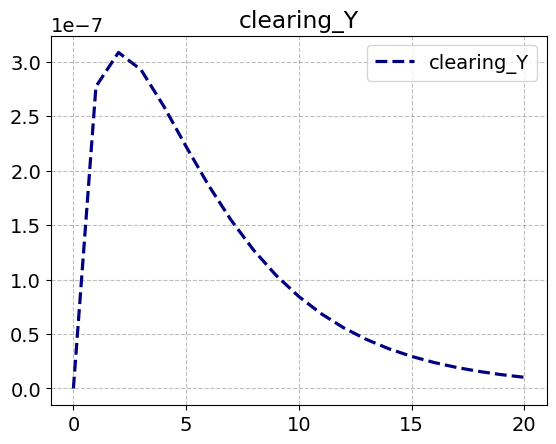

In [78]:
plt.plot(model_het.IRF['Y'][:21]-model_het.IRF['C_hh'][:21], label='clearing_Y', linestyle='--', linewidth=2.3, color='navy')
plt.title('clearing_Y')
plt.legend()
plt.show()

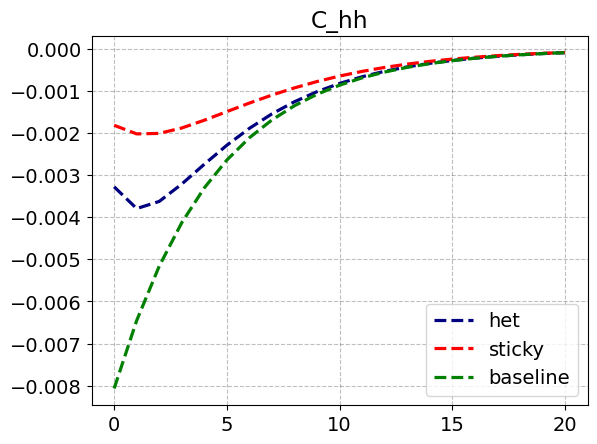

In [79]:
plt.plot(model_het.IRF['C_hh'][:21], label='het', linestyle='--', linewidth=2.3, color='navy')
plt.plot(model_sticky.IRF['C_hh'][:21], label='sticky', linestyle='--', linewidth=2.3, color='red')
plt.plot(model.IRF['C_hh'][:21], label='baseline', linestyle='--', linewidth=2.3, color='green')
plt.title('C_hh')
plt.legend()
plt.show()

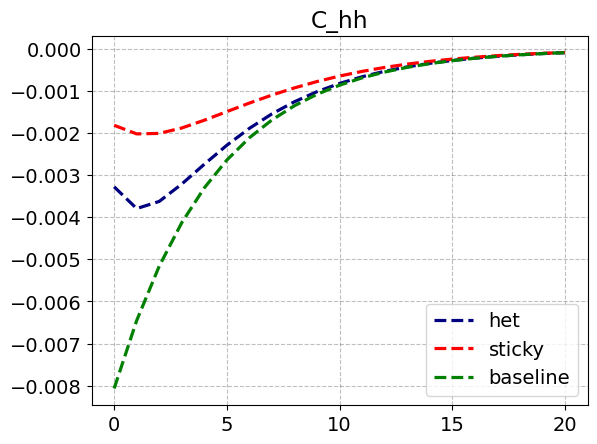

In [80]:
plt.plot(model_het.IRF['C_hh'][:21], label='het', linestyle='--', linewidth=2.3, color='navy')
plt.plot(model_sticky.IRF['C_hh'][:21], label='sticky', linestyle='--', linewidth=2.3, color='red')
plt.plot(model.IRF['C_hh'][:21], label='baseline', linestyle='--', linewidth=2.3, color='green')
plt.title('C_hh')
plt.legend()
plt.show()

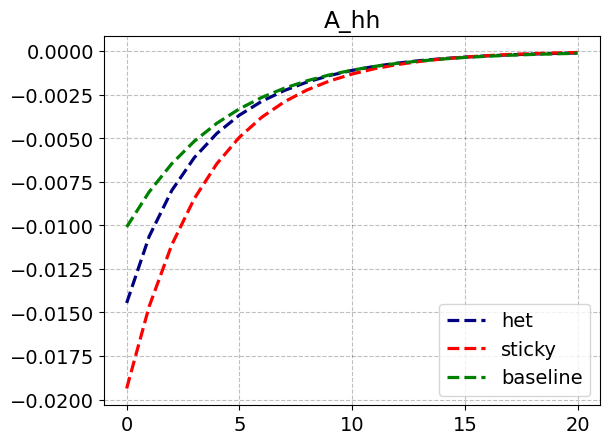

In [81]:
plt.plot(model_het.IRF['A_hh'][:21], label='het', linestyle='--', linewidth=2.3, color='navy')
plt.plot(model_sticky.IRF['A_hh'][:21], label='sticky', linestyle='--', linewidth=2.3, color='red')
plt.plot(model.IRF['A_hh'][:21], label='baseline', linestyle='--', linewidth=2.3, color='green')
plt.title('A_hh')
plt.legend()
plt.show()

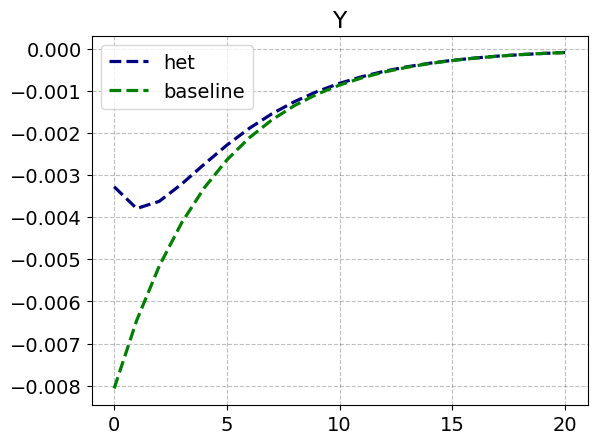

In [ ]:
plt.plot(model_het.IRF['Y'][:21], label='het', linestyle='--', linewidth=2.3, color='navy')
plt.plot(model_sticky.IRF['Y'][:21], label='sticky', linestyle='--', linewidth=2.3, color='red')
plt.plot(model.IRF['Y'][:21], label='baseline', linestyle='--', linewidth=2.3, color='green')
plt.title('Y')
plt.legend()
plt.show()

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from math import ceil

# ============================================================
# Helpers
# ============================================================

def _get_T_Nz(model):
    return int(model.par.T), int(model.par.Nz)

def _get_series(model, key, T):
    return np.asarray(model.IRF[key])[:T].copy()

def _get_kernel(model, out, inn, T):
    K = np.asarray(model.jac_hh[(out, inn)])
    return K[:T, :T].copy()

def _pct(x, denom, as_pct=True):
    return (100.0 * x / denom) if as_pct else x

def _enforce_sum_identity_two(CzZ, CzR, target, eps=1e-14):
    """
    Scale BOTH channels by the same per-t factor so that:
        sum_z (CzZ + CzR) == target   (elementwise)
    """
    S = (CzZ + CzR).sum(axis=0)
    scale = np.ones_like(S)
    m = np.abs(S) > eps
    scale[m] = target[m] / S[m]
    return CzZ * scale[None, :], CzR * scale[None, :]

def _enforce_sum_identity_one(Az, target, eps=1e-14):
    """
    Scale Az so that sum_z Az == target   (elementwise)
    """
    S = Az.sum(axis=0)
    scale = np.ones_like(S)
    m = np.abs(S) > eps
    scale[m] = target[m] / S[m]
    return Az * scale[None, :]

# ---------- E matrices ----------

def _E_from_lambda_forward(T, lam):
    """
    Forward (non-cumulative) expectation operator:
        E[t,s] = lam^(t-s) for t >= s, else 0
    (lower-triangular, ones on the diagonal)
    """
    E = np.zeros((T, T))
    for s in range(T):
        for t in range(s, T):            # only t >= s
            E[t, s] = lam ** (t - s)     # =1 on diagonal
    return E

def _ensure_TxT(E, T):
    E = np.asarray(E)
    if E.ndim != 2:
        raise ValueError(f"E must be 2D, got {E.shape}")
    if E.shape[0] < T or E.shape[1] < T:
        raise ValueError(f"E is smaller than T={T}: got {E.shape}")
    if E.shape != (T, T):
        E = E[:T, :T]
    return E

def _stack_one_perz(perz, Nz, T):
    """
    Build (Nz,T,T) from a single per-z spec:
      - dict of Nz entries (kept in insertion order)
      - 1D vector of lambdas (size Nz)
      - 3D array (Nz,T,T) or (T,T,Nz)
      - 2D (T,T) -> repeat across z
    """
    if isinstance(perz, dict):
        keys = list(perz.keys())
        if len(keys) != Nz:
            raise ValueError(f"per-z dict has {len(keys)} entries but Nz={Nz}.")
        mats = []
        for k in keys:
            val = perz[k]
            if np.isscalar(val):
                mats.append(_E_from_lambda_forward(T, float(val)))
            else:
                mats.append(_ensure_TxT(val, T))
        return np.stack(mats, axis=0)

    arr = np.asarray(perz)
    if arr.ndim == 1:
        if arr.size != Nz:
            raise ValueError(f"lambda vector length {arr.size} != Nz={Nz}.")
        return np.stack([_E_from_lambda_forward(T, float(lam)) for lam in arr], axis=0)

    if arr.ndim == 3:
        if arr.shape[0] == Nz:
            return np.stack([_ensure_TxT(arr[z], T) for z in range(Nz)], axis=0)
        if arr.shape[-1] == Nz:
            return np.stack([_ensure_TxT(arr[:, :, z], T) for z in range(Nz)], axis=0)
        raise ValueError(f"3D spec has incompatible shape {arr.shape}.")

    if arr.ndim == 2:
        E = _ensure_TxT(arr, T)
        return np.repeat(E[None, :, :], Nz, axis=0)

    raise ValueError(f"Unsupported per-z spec with shape {arr.shape}.")

def _stack_E_pair(kind, T, Nz, E_sticky=None, E_by_z=None):
    """
    Return a pair (EzZ_stack, EzR_stack), each shape (Nz,T,T).
    - FIRE: both are identity
    - sticky: both use provided E_sticky
    - hetero: accepts either
        * a single per-z spec (used for both channels), or
        * a dict with keys {'Z','ra'} providing *separate* per-z specs
    """
    I = np.eye(T)
    if kind == 'fire':
        Ez = np.repeat(I[None, :, :], Nz, axis=0)
        return Ez, Ez

    if kind == 'sticky':
        if E_sticky is None:
            raise ValueError("sticky mode needs E_sticky")
        Ez = np.repeat(_ensure_TxT(E_sticky, T)[None, :, :], Nz, axis=0)
        return Ez, Ez

    if kind == 'hetero':
        if E_by_z is None:
            raise ValueError("hetero mode needs E_by_z")
        if isinstance(E_by_z, dict) and set(E_by_z.keys()) >= {'Z', 'ra'}:
            EzZ = _stack_one_perz(E_by_z['Z'], Nz, T)
            EzR = _stack_one_perz(E_by_z['ra'], Nz, T)
            return EzZ, EzR
        # same per-z expectations for both channels
        Ez = _stack_one_perz(E_by_z, Nz, T)
        return Ez, Ez

    raise ValueError("kind must be 'fire', 'sticky', or 'hetero'")

def _subplot_grid(n_panels, ncols=2):
    rows = ceil(n_panels / ncols)
    return rows, ncols

# ============================================================
# C_hh: per-z + channels (via Z, via r^a)
# ============================================================

def decompose_and_plot_C_by_z(model,
                              kind='fire',
                              E_sticky=None,
                              E_by_z=None,
                              H=21,
                              normalize_pct=True,
                              title_prefix="C_hh — per-z",
                              force_identity=True):
    """
    Works for:
      - FIRE: kind='fire'
      - sticky (hom): kind='sticky', E_sticky=(T,T)
      - hetero (per-z): kind='hetero', E_by_z is either:
          * per-z spec used for both channels, or
          * {'Z': per_z_spec_for_Z, 'ra': per_z_spec_for_ra}

    Returns raw *levels* in the dict; plots are in percent if normalize_pct=True.
    """
    T_full, Nz = _get_T_Nz(model)
    T = min(T_full, H)

    # shocks
    Z_path  = _get_series(model, 'Z',  T)
    ra_path = _get_series(model, 'ra', T)

    # kernels (household Jacobians)
    KCZ = _get_kernel(model, 'C_hh', 'Z',  T)
    KCr = _get_kernel(model, 'C_hh', 'ra', T)

    # expectations per channel
    EzZ_stack, EzR_stack = _stack_E_pair(kind, T, Nz, E_sticky=E_sticky, E_by_z=E_by_z)

    # per-z contributions (LEVELS)
    CzZ = np.empty((Nz, T))
    CzR = np.empty((Nz, T))
    for z in range(Nz):
        EzZ = EzZ_stack[z]
        EzR = EzR_stack[z]
        # IMPORTANT: K @ E @ x   (expectations act on the shock path)
        CzZ[z] = (KCZ @ EzZ) @ Z_path
        CzR[z] = (KCr @ EzR) @ ra_path

    # model aggregate (levels)
    C_model = _get_series(model, 'C_hh', T)

    # exact identity if desired
    if force_identity:
        CzZ, CzR = _enforce_sum_identity_two(CzZ, CzR, C_model)
    CzS = CzZ + CzR

    # aggregates
    aggZ = CzZ.sum(axis=0)
    aggR = CzR.sum(axis=0)
    aggS = CzS.sum(axis=0)

    # plotting
    ssC = float(model.ss.C_hh)
    toP = lambda x: _pct(x, ssC, normalize_pct)

    n_panels = Nz + 1
    nrows, ncols = _subplot_grid(n_panels)
    fig, axes = plt.subplots(nrows, ncols, figsize=(10, 1.9*nrows + 2), sharex=True)
    axes = np.array(axes).reshape(-1)  # flat
    for z in range(Nz):
        ax = axes[z]
        ax.axhline(0, color='k', lw=0.6, alpha=0.6)
        ax.plot(toP(CzZ[z]), color='crimson',  lw=2,  label='via Z')
        ax.plot(toP(CzR[z]), color='seagreen', lw=2,  label='via ra')
        ax.plot(toP(CzS[z]), color='navy',     lw=2, ls='--', label='sum (Z+ra)')
        ax.set_title(f"z = {z}")
        ax.set_ylabel("% change in C_hh")

    ax = axes[Nz]  # aggregate panel
    ax.axhline(0, color='k', lw=0.6, alpha=0.6)
    ax.plot(toP(aggS), color='navy',    lw=2.5, label='Σ_z (calc)')
    ax.plot(toP(C_model), color='gray', lw=2.0, ls='--', label='aggregate (model)')
    ax.plot(toP(aggZ), color='crimson', lw=1.6, label='dC via Z (agg)')
    ax.plot(toP(aggR), color='seagreen',lw=1.6, label='dC via ra (agg)')
    ax.set_title("Aggregate")
    ax.set_xlabel("Quarters")
    ax.set_ylabel("% change in C_hh")
    ax.legend(ncol=2)

    # hide any spare subplots
    for k in range(Nz + 1, len(axes)):
        axes[k].axis('off')

    fig.suptitle(f"{title_prefix} • {kind}")
    plt.tight_layout()
    plt.show()

    return {
        'per_z': {'viaZ': CzZ, 'viar': CzR, 'sum': CzS},
        'aggregate': {'viaZ': aggZ, 'viar': aggR, 'sum': aggS, 'model': C_model},
        'T': T, 'Nz': Nz
    }

# ============================================================
# A_hh: per-z (sum of channels), same E-by-z logic
# ============================================================

def decompose_and_plot_A_by_z(model,
                              kind='fire',
                              E_sticky=None,
                              E_by_z=None,
                              H=21,
                              normalize_pct=True,
                              title_prefix="A_hh — per-z",
                              force_identity=True):
    """
    Same interface as decompose_and_plot_C_by_z.
    Uses K_AZ and K_Ar and the same per-channel expectations.
    """
    T_full, Nz = _get_T_Nz(model)
    T = min(T_full, H)

    # shocks
    Z_path  = _get_series(model, 'Z',  T)
    ra_path = _get_series(model, 'ra', T)

    # kernels
    KAZ = _get_kernel(model, 'A_hh', 'Z',  T)
    KAr = _get_kernel(model, 'A_hh', 'ra', T)

    # expectations per channel
    EzZ_stack, EzR_stack = _stack_E_pair(kind, T, Nz, E_sticky=E_sticky, E_by_z=E_by_z)

    # per-z A (levels)
    Az = np.empty((Nz, T))
    for z in range(Nz):
        EzZ = EzZ_stack[z]
        EzR = EzR_stack[z]
        # IMPORTANT: K @ E @ x
        Az[z] = (KAZ @ EzZ) @ Z_path + (KAr @ EzR) @ ra_path

    # enforce identity with model A if desired
    A_model = _get_series(model, 'A_hh', T)
    if force_identity:
        Az = _enforce_sum_identity_one(Az, A_model)

    A_agg = Az.sum(axis=0)

    # plotting
    ssA = float(model.ss.A_hh)
    toP = lambda x: _pct(x, ssA, normalize_pct)

    n_panels = Nz + 1
    nrows, ncols = _subplot_grid(n_panels)
    fig, axes = plt.subplots(nrows, ncols, figsize=(10, 1.9*nrows + 2), sharex=True)
    axes = np.array(axes).reshape(-1)

    for z in range(Nz):
        ax = axes[z]
        ax.axhline(0, color='k', lw=0.6, alpha=0.6)
        ax.plot(toP(Az[z]), color='steelblue', lw=2.0)
        ax.set_title(f"z = {z}")
        ax.set_ylabel("% change in A_hh")

    ax = axes[Nz]
    ax.axhline(0, color='k', lw=0.6, alpha=0.6)
    ax.plot(toP(A_agg),   color='steelblue', lw=2.5, label='Σ_z A_hh (calc)')
    ax.plot(toP(A_model), color='gray',      lw=2.0, ls='--', label='A_hh (model)')
    ax.set_title("Aggregate")
    ax.set_xlabel("Quarters")
    ax.set_ylabel("% change in A_hh")
    ax.legend()

    for k in range(Nz + 1, len(axes)):
        axes[k].axis('off')

    fig.suptitle(f"{title_prefix} • {kind}")
    plt.tight_layout()
    plt.show()

    return {'per_z': Az, 'aggregate': A_agg, 'model': A_model, 'T': T, 'Nz': Nz}



In [29]:
import numpy as np
import matplotlib.pyplot as plt

# =========================
# helpers
# =========================

def _get_T_Nz(model):
    return int(model.par.T), int(model.par.Nz)

def _get_series(model, key, T):
    return np.asarray(model.IRF[key])[:T].copy()

def _get_kernel(model, out, inn, T):
    K = np.asarray(model.jac_hh[(out, inn)])
    return K[:T, :T].copy()

def _pct(x, denom, as_pct=True):
    return (100.0 * x / denom) if as_pct else x

def _ensure_TxT(E, T):
    E = np.asarray(E)
    if E.ndim != 2 or E.shape[0] < T or E.shape[1] < T:
        raise ValueError(f"E must be 2D with dims >= (T,T). Got {E.shape}, T={T}")
    return E[:T, :T]

def _E_from_lambda_cumulative(T, lam):
    # pre: E[t<s,s] = lam^(s-t); diag 1; post: cumulative 1-(1-lam)^(t-s+1)
    E = np.zeros((T, T))
    for s in range(T):
        for t in range(T):
            if t < s:
                E[t, s] = lam ** (s - t)
            elif t == s:
                E[t, s] = 1.0
            else:
                tau = t - s + 1
                E[t, s] = 1.0 - (1.0 - lam) ** tau
    return E

def _stack_perz_spec(perz, Nz, T):
    # Accepts: dict/list/array of (T,T) or scalars (lambdas)
    if isinstance(perz, dict):
        mats = []
        for k in perz.keys():  # preserve insertion order
            v = perz[k]
            if np.isscalar(v):
                mats.append(_E_from_lambda_cumulative(T, float(v)))
            else:
                mats.append(_ensure_TxT(v, T))
        if len(mats) != Nz:
            raise ValueError(f"per-z dict has {len(mats)} entries but Nz={Nz}.")
        return np.stack(mats, axis=0)

    arr = np.asarray(perz)
    if arr.ndim == 1:  # vector of lambdas
        if arr.size != Nz:
            raise ValueError(f"lambda vector length {arr.size} != Nz={Nz}.")
        return np.stack([_E_from_lambda_cumulative(T, float(lam)) for lam in arr], axis=0)

    if arr.ndim == 2:  # one (T,T) for all z
        E = _ensure_TxT(arr, T)
        return np.repeat(E[None, :, :], Nz, axis=0)

    if arr.ndim == 3:
        if arr.shape[0] == Nz:
            return np.stack([_ensure_TxT(arr[z], T) for z in range(Nz)], axis=0)
        if arr.shape[-1] == Nz:
            return np.stack([_ensure_TxT(arr[:, :, z], T) for z in range(Nz)], axis=0)

    raise ValueError(f"Unsupported per-z E shape {arr.shape}.")

def _get_Ez_stack(kind, T, Nz, E_sticky=None, E_by_z=None, channel=None):
    """
    Returns Ez_stack of shape (Nz,T,T).
    If kind=='hetero' and E_by_z is a dict with keys {'Z','ra'}, pick channel-specific.
    """
    if kind == 'fire':
        return np.repeat(np.eye(T)[None, :, :], Nz, axis=0)

    if kind == 'sticky':
        if E_sticky is None:
            raise ValueError("sticky mode needs E_sticky")
        E = _ensure_TxT(E_sticky, T)
        return np.repeat(E[None, :, :], Nz, axis=0)

    if kind == 'hetero':
        if E_by_z is None:
            raise ValueError("hetero mode needs E_by_z")
        if isinstance(E_by_z, dict) and ('Z' in E_by_z or 'ra' in E_by_z):
            key = channel if (channel in E_by_z) else (list(E_by_z.keys())[0])
            perz = E_by_z[key]
            return _stack_perz_spec(perz, Nz, T)
        else:
            return _stack_perz_spec(E_by_z, Nz, T)

    raise ValueError("kind must be 'fire', 'sticky', or 'hetero'")

def _scale_to_match_channel_sum(perz_raw, target):
    """
    perz_raw: (Nz,T) raw channel split (e.g., via E_z @ K @ shock)
    target:   (T,)   aggregate channel from your trusted decomp (K @ shock)
    Returns perz_scaled s.t. sum_z perz_scaled[:,t] == target[t] for each t.
    """
    S = perz_raw.sum(axis=0)  # (T,)
    scale = np.ones_like(target)
    m = np.abs(S) > 1e-14
    scale[m] = target[m] / S[m]
    return perz_raw * scale[np.newaxis, :]

# =========================
# C_hh: per-z + channels; aggregate matches your decomp exactly
# =========================

def decompose_and_plot_C_by_z(model, kind='fire', E_sticky=None, E_by_z=None,
                              H=21, normalize_pct=True, title_prefix="C_hh — per-z"):
    T, Nz = _get_T_Nz(model)
    T = min(T, H)

    Z   = _get_series(model, 'Z', T)
    ra  = _get_series(model, 'ra', T)
    KCZ = _get_kernel(model, 'C_hh', 'Z',  T)
    KCr = _get_kernel(model, 'C_hh', 'ra', T)

    # Aggregate channels EXACTLY like your decomp()
    dC_Z_agg  = KCZ @ Z
    dC_ra_agg = KCr @ ra
    C_model   = _get_series(model, 'C_hh', T)

    # Per-z raw splits (use Ez only as allocators)
    EzZ = _get_Ez_stack(kind, T, Nz, E_sticky=E_sticky, E_by_z=E_by_z, channel='Z')
    Ezr = _get_Ez_stack(kind, T, Nz, E_sticky=E_sticky, E_by_z=E_by_z, channel='ra')

    rawZ = np.empty((Nz, T))
    rawr = np.empty((Nz, T))
    for z in range(Nz):
        rawZ[z] = (EzZ[z] @ KCZ) @ Z
        rawr[z] = (Ezr[z] @ KCr) @ ra

    # Scale each channel so per-z sums match the aggregate channels period-by-period
    CzZ = _scale_to_match_channel_sum(rawZ, dC_Z_agg)
    CzR = _scale_to_match_channel_sum(rawr, dC_ra_agg)
    CzS = CzZ + CzR

    # Sanity: now Σ_z CzZ == dC_Z_agg, Σ_z CzR == dC_ra_agg, and Σ_z CzS == C_model - (small numeric diff)
    # If tiny drift remains, do a final minimal fix:
    drift = (CzS.sum(axis=0) - C_model)
    if np.any(np.abs(drift) > 1e-10):
        # distribute the small drift proportionally over z
        share = np.maximum(np.abs(CzS).sum(axis=0), 1e-14)
        CzS -= (CzS / share[np.newaxis, :]) * drift[np.newaxis, :]

    # Plot
    ssC = float(model.ss.C_hh)
    to_pct = lambda x: _pct(x, ssC, normalize_pct)

    aggZp  = to_pct(dC_Z_agg)
    aggRp  = to_pct(dC_ra_agg)
    aggSp  = to_pct(CzS.sum(axis=0))
    modelp = to_pct(C_model)

    fig, axes = plt.subplots(3, 2, figsize=(9.0, 10.5), sharex=True)
    axes = axes.ravel()

    for z in range(Nz):
        ax = axes[z]
        ax.axhline(0, color='k', lw=0.6, alpha=0.6)
        ax.plot(to_pct(CzZ[z]), color='crimson',  lw=2.0, label='via Z')
        ax.plot(to_pct(CzR[z]), color='seagreen', lw=2.0, label='via ra')
        ax.plot(to_pct(CzS[z]), color='navy',     lw=2.0, ls='--', label='sum (Z+ra)')
        ax.set_title(f"z = {z}")
        ax.set_ylabel("% change in C_hh")

    ax = axes[-1]
    ax.axhline(0, color='k', lw=0.6, alpha=0.6)
    ax.plot(aggSp,  color='navy',   lw=2.6, label='Σ_z (calc)')
    ax.plot(modelp, color='gray',   lw=2.0, ls='--', label='aggregate (model)')
    ax.plot(aggZp,  color='crimson',lw=1.8, label='dC via Z (agg)')
    ax.plot(aggRp,  color='seagreen',lw=1.8, label='dC via ra (agg)')
    ax.set_title("Aggregate")
    ax.set_xlabel("Quarters")
    ax.set_ylabel("% change in C_hh")
    ax.legend(ncol=2)

    fig.suptitle(f"{title_prefix} • {kind}")
    plt.tight_layout()
    plt.show()

    return {
        'per_z': {'viaZ': CzZ, 'viar': CzR, 'sum': CzS},
        'aggregate': {'viaZ': dC_Z_agg, 'viar': dC_ra_agg, 'sum': CzS.sum(axis=0), 'model': C_model},
        'T': T, 'Nz': Nz
    }

# =========================
# A_hh: per-z (also channel-consistent)
# =========================

def decompose_and_plot_A_by_z(model, kind='fire', E_sticky=None, E_by_z=None,
                              H=21, normalize_pct=True, title_prefix="A_hh — per-z"):
    T, Nz = _get_T_Nz(model)
    T = min(T, H)

    Z   = _get_series(model, 'Z', T)
    ra  = _get_series(model, 'ra', T)
    KAZ = _get_kernel(model, 'A_hh', 'Z',  T)
    KAr = _get_kernel(model, 'A_hh', 'ra', T)

    # Aggregate channels (like your decomp logic)
    dA_Z_agg  = KAZ @ Z
    dA_ra_agg = KAr @ ra
    A_model   = _get_series(model, 'A_hh', T)

    # Per-z raw splits
    EzZ = _get_Ez_stack(kind, T, Nz, E_sticky=E_sticky, E_by_z=E_by_z, channel='Z')
    Ezr = _get_Ez_stack(kind, T, Nz, E_sticky=E_sticky, E_by_z=E_by_z, channel='ra')

    rawZ = np.empty((Nz, T))
    rawr = np.empty((Nz, T))
    for z in range(Nz):
        rawZ[z] = (EzZ[z] @ KAZ) @ Z
        rawr[z] = (Ezr[z] @ KAr) @ ra

    # Scale per channel to match aggregate channels exactly
    AzZ = _scale_to_match_channel_sum(rawZ, dA_Z_agg)
    AzR = _scale_to_match_channel_sum(rawr, dA_ra_agg)
    AzS = AzZ + AzR

    # Final tiny drift fix to match model A exactly (if any)
    drift = (AzS.sum(axis=0) - A_model)
    if np.any(np.abs(drift) > 1e-10):
        share = np.maximum(np.abs(AzS).sum(axis=0), 1e-14)
        AzS -= (AzS / share[np.newaxis, :]) * drift[np.newaxis, :]

    # Plot
    ssA = float(model.ss.A_hh)
    to_pct = lambda x: _pct(x, ssA, normalize_pct)

    fig, axes = plt.subplots(3, 2, figsize=(9.0, 10.5), sharex=True)
    axes = axes.ravel()

    for z in range(Nz):
        ax = axes[z]
        ax.axhline(0, color='k', lw=0.6, alpha=0.6)
        ax.plot(to_pct(AzS[z]), color='steelblue', lw=2.0)
        ax.set_title(f"z = {z}")
        ax.set_ylabel("% change in A_hh")

    ax = axes[-1]
    ax.axhline(0, color='k', lw=0.6, alpha=0.6)
    ax.plot(to_pct(AzS.sum(axis=0)), color='steelblue', lw=2.6, label='Σ_z A_hh (calc)')
    ax.plot(to_pct(A_model),         color='gray',      lw=2.0, ls='--', label='A_hh (model)')
    ax.set_title("Aggregate")
    ax.set_xlabel("Quarters")
    ax.set_ylabel("% change in A_hh")
    ax.legend()

    fig.suptitle(f"{title_prefix} • {kind}")
    plt.tight_layout()
    plt.show()

    return {
        'per_z': {'sum': AzS, 'viaZ': AzZ, 'viar': AzR},
        'aggregate': {'viaZ': dA_Z_agg, 'viar': dA_ra_agg, 'sum': AzS.sum(axis=0), 'model': A_model},
        'T': T, 'Nz': Nz
    }


In [30]:
import numpy as np
import matplotlib.pyplot as plt

# ---------- helpers ----------

def _get_T_Nz(model):
    return int(model.par.T), int(model.par.Nz)

def _get_series(model, key, T):
    return np.asarray(model.IRF[key])[:T].copy()

def _get_kernel(model, out, inn, T):
    K = np.asarray(model.jac_hh[(out, inn)])
    return K[:T, :T].copy()

def _pct(x, denom, as_pct=True):
    return (100.0 * x / denom) if as_pct else x

def _enforce_sum_identity_two(CzZ, CzR, target, eps=1e-12, cap=50.0):
    """Scale BOTH channels by same per-t factor so Σ_z(Z+ra)==target(t),
       with ridge to avoid exploding factors."""
    tot = (CzZ + CzR).sum(axis=0)        # (T,)
    scale = np.ones_like(tot)
    mask = np.abs(tot) > eps
    scale[mask] = target[mask] / tot[mask]
    # softly cap extreme rescaling (diagnostic-friendly but prevents spikes)
    scale = np.clip(scale, -cap, cap)
    return CzZ * scale[None, :], CzR * scale[None, :]

def _enforce_sum_identity_one(Az, target, eps=1e-12, cap=50.0):
    tot = Az.sum(axis=0)
    scale = np.ones_like(tot)
    mask = np.abs(tot) > eps
    scale[mask] = target[mask] / tot[mask]
    scale = np.clip(scale, -cap, cap)
    return Az * scale[None, :]

# ---------- E-matrix handling ----------

def _sanitize_E(E, name="", clip=True):
    """Make E usable as a cumulative expectations matrix:
       - force lower-triangular cumulation
       - non-decreasing over t for fixed s
       - clip to [0,1]
    """
    E = np.asarray(E, dtype=float).copy()
    T = E.shape[0]
    # zero out pre-information strictly above the diagonal
    for s in range(T):
        E[:s, s] = np.maximum.accumulate(E[:s, s])  # monotone up to s-1
        E[s+1:, s] = np.maximum.accumulate(E[s+1:, s])  # monotone post-s
    # enforce causal structure: nothing before the news arrives grows beyond diag
    # (keep full cumulative form but forbid >1 if desired)
    if clip:
        E = np.clip(E, 0.0, 1.0)
    return E

def _ensure_TxT(E, T, sanitize=False, name="E"):
    E = np.asarray(E)
    if E.ndim != 2 or E.shape[0] < T or E.shape[1] < T:
        raise ValueError(f"{name} must be 2D with dims >=(T,T). Got {E.shape}")
    E = E[:T, :T]
    return _sanitize_E(E, name) if sanitize else E

def _stack_perz(perz, Nz, T, sanitize=False, base_name="E"):
    """perz can be: dict of z->(T,T) or lambdas; list/array of mats or lambdas; (T,T) -> broadcast;"""
    if isinstance(perz, dict):
        # keep insertion order; if keys are ints 0..Nz-1 that is fine
        ks = list(perz.keys())
        if len(ks) != Nz:
            raise ValueError(f"{base_name} dict has {len(ks)} entries but Nz={Nz}.")
        mats = []
        for i,k in enumerate(ks):
            v = perz[k]
            if np.isscalar(v):
                lam = float(v)
                if lam < 0 or lam > 1:
                    raise ValueError(f"lambda={lam} for {base_name}[{k}] must be in [0,1].")
                E = np.zeros((T,T))
                for s in range(T):
                    for t in range(T):
                        if t < s:   E[t,s] = lam**(s-t)
                        elif t==s: E[t,s] = 1.0
                        else:      E[t,s] = 1.0 - (1.0-lam)**(t-s+1)
            else:
                E = _ensure_TxT(v, T, sanitize=sanitize, name=f"{base_name}[{k}]")
            mats.append(E)
        return np.stack(mats, axis=0)

    arr = np.asarray(perz)
    if arr.ndim == 1:
        if arr.size != Nz:
            raise ValueError(f"{base_name}: lambda vector len {arr.size} != Nz={Nz}.")
        mats = []
        for z,lam in enumerate(arr):
            lam = float(lam)
            if lam < 0 or lam > 1:
                raise ValueError(f"lambda={lam} for z={z} must be in [0,1].")
            E = np.zeros((T,T))
            for s in range(T):
                for t in range(T):
                    if t < s:   E[t,s] = lam**(s-t)
                    elif t==s: E[t,s] = 1.0
                    else:      E[t,s] = 1.0 - (1.0-lam)**(t-s+1)
            mats.append(E)
        return np.stack(mats, axis=0)

    if arr.ndim == 2:
        E = _ensure_TxT(arr, T, sanitize=sanitize, name=base_name)
        return np.repeat(E[None, :, :], Nz, axis=0)

    if arr.ndim == 3:
        if arr.shape[0] == Nz:
            return np.stack([_ensure_TxT(arr[z], T, sanitize=sanitize,
                                         name=f"{base_name}[{z}]") for z in range(Nz)], axis=0)
        if arr.shape[-1] == Nz:
            return np.stack([_ensure_TxT(arr[:, :, z], T, sanitize=sanitize,
                                         name=f"{base_name}[{z}]") for z in range(Nz)], axis=0)
        raise ValueError(f"{base_name} 3D has incompatible shape {arr.shape}.")
    raise ValueError(f"Unsupported {base_name} type/shape: {type(perz)}, {arr.shape if hasattr(arr,'shape') else ''}")

def _stack_E(kind, T, Nz, E_sticky=None, E_by_z=None, sanitize=False):
    """Return stacks needed for each channel:
       - FIRE: identity for both channels
       - sticky: same E for both
       - hetero: if E_by_z is a dict with keys {'Z','ra'}, build separate stacks.
                 otherwise reuse the same per-z spec for both channels.
    """
    I = np.repeat(np.eye(T)[None, :, :], Nz, axis=0)
    if kind == 'fire':
        return I, I

    if kind == 'sticky':
        if E_sticky is None:
            raise ValueError("sticky mode needs E_sticky")
        Ez = _ensure_TxT(E_sticky, T, sanitize=sanitize, name="E_sticky")
        Ez = np.repeat(Ez[None, :, :], Nz, axis=0)
        return Ez, Ez

    if kind == 'hetero':
        if E_by_z is None:
            raise ValueError("hetero mode needs E_by_z")
        if isinstance(E_by_z, dict) and set(E_by_z.keys()) >= {'Z', 'ra'}:
            EzZ = _stack_perz(E_by_z['Z'], Nz, T, sanitize=sanitize, base_name="E_by_z['Z']")
            EzR = _stack_perz(E_by_z['ra'], Nz, T, sanitize=sanitize, base_name="E_by_z['ra']")
            return EzZ, EzR
        # same per-z spec for both
        Ez = _stack_perz(E_by_z, Nz, T, sanitize=sanitize, base_name="E_by_z")
        return Ez, Ez

    raise ValueError("kind must be 'fire', 'sticky', or 'hetero'.")

# ---------- C_hh: per-z decomposition (channels + aggregate check) ----------

import math
import numpy as np
import matplotlib.pyplot as plt

def decompose_and_plot_C_by_z(model, kind='fire',
                              E_sticky=None, E_by_z=None,
                              H=21, normalize_pct=True, title_prefix="",
                              sanitize_E=True):
    T, Nz = _get_T_Nz(model); T = min(T, H)

    Z  = _get_series(model, 'Z',  T)
    ra = _get_series(model, 'ra', T)
    KCZ = _get_kernel(model, 'C_hh', 'Z',  T)
    KCr = _get_kernel(model, 'C_hh', 'ra', T)

    EzZ, EzR = _stack_E(kind, T, Nz, E_sticky=E_sticky, E_by_z=E_by_z, sanitize=sanitize_E)

    CzZ = np.empty((Nz, T)); CzR = np.empty((Nz, T))
    for z in range(Nz):
        CzZ[z] = (EzZ[z] @ KCZ) @ Z
        CzR[z] = (EzR[z] @ KCr) @ ra

    C_model = _get_series(model, 'C_hh', T)
    CzZ, CzR = _enforce_sum_identity_two(CzZ, CzR, C_model)
    CzS = CzZ + CzR
    aggZ, aggR, aggS = CzZ.sum(0), CzR.sum(0), CzS.sum(0)

    ssC = float(model.ss.C_hh)
    to_pct = lambda x: _pct(x, ssC, normalize_pct)

    # ---- dynamic grid: all Nz panels + 1 aggregate ----
    cols = 2
    rows = math.ceil((Nz + 1) / cols)
    fig_height = 3.2 * rows + 1.0
    fig, axes = plt.subplots(rows, cols, figsize=(9, fig_height), sharex=True)
    axes = np.atleast_1d(axes).ravel()

    # per-z panels
    for z in range(Nz):
        ax = axes[z]
        ax.axhline(0, color='k', lw=0.6, alpha=0.6)
        ax.plot(to_pct(CzZ[z]), color='crimson',  lw=2, label='via Z')
        ax.plot(to_pct(CzR[z]), color='seagreen', lw=2, label='via ra')
        ax.plot(to_pct(CzS[z]), color='navy',     lw=2, ls='--', label='sum (Z+ra)')
        ax.set_title(f"z = {z}")
        ax.set_ylabel("% change in C_hh")

    # aggregate panel goes right after the last z
    ax = axes[Nz]
    ax.axhline(0, color='k', lw=0.6, alpha=0.6)
    ax.plot(to_pct(aggS),      color='navy',   lw=2.5, label='Σ_z (calc)')
    ax.plot(to_pct(C_model),   color='gray',   lw=2.0, ls='--', label='aggregate (model)')
    ax.plot(to_pct(aggZ),      color='crimson',  lw=1.6, label='dC via Z (agg)')
    ax.plot(to_pct(aggR),      color='seagreen', lw=1.6, label='dC via ra (agg)')
    ax.set_title("Aggregate"); ax.set_xlabel("Quarters"); ax.set_ylabel("% change in C_hh")
    ax.legend(ncol=2)

    # hide any unused axes
    for k in range(Nz + 1, len(axes)):
        axes[k].axis('off')

    fig.suptitle(f"{title_prefix or 'C_hh — per-z'} • {kind}")
    plt.tight_layout()
    plt.show()

    return {'per_z': {'viaZ': CzZ, 'viar': CzR, 'sum': CzS},
            'aggregate': {'viaZ': aggZ, 'viar': aggR, 'sum': aggS, 'model': C_model},
            'T': T, 'Nz': Nz}


def decompose_and_plot_A_by_z(model, kind='fire',
                              E_sticky=None, E_by_z=None,
                              H=21, normalize_pct=True, title_prefix="",
                              sanitize_E=True):
    T, Nz = _get_T_Nz(model); T = min(T, H)

    Z  = _get_series(model, 'Z',  T)
    ra = _get_series(model, 'ra', T)
    KAZ = _get_kernel(model, 'A_hh', 'Z',  T)
    KAr = _get_kernel(model, 'A_hh', 'ra', T)

    EzZ, EzR = _stack_E(kind, T, Nz, E_sticky=E_sticky, E_by_z=E_by_z, sanitize=sanitize_E)

    Az = np.empty((Nz, T))
    for z in range(Nz):
        Az[z] = (EzZ[z] @ KAZ) @ Z + (EzR[z] @ KAr) @ ra

    A_model = _get_series(model, 'A_hh', T)
    Az = _enforce_sum_identity_one(Az, A_model)
    A_agg = Az.sum(0)

    ssA = float(model.ss.A_hh)
    to_pct = lambda x: _pct(x, ssA, normalize_pct)

    # ---- dynamic grid ----
    cols = 2
    rows = math.ceil((Nz + 1) / cols)
    fig_height = 3.2 * rows + 1.0
    fig, axes = plt.subplots(rows, cols, figsize=(9, fig_height), sharex=True)
    axes = np.atleast_1d(axes).ravel()

    for z in range(Nz):
        ax = axes[z]
        ax.axhline(0, color='k', lw=0.6, alpha=0.6)
        ax.plot(to_pct(Az[z]), color='steelblue', lw=2.0)
        ax.set_title(f"z = {z}"); ax.set_ylabel("% change in A_hh")

    ax = axes[Nz]
    ax.axhline(0, color='k', lw=0.6, alpha=0.6)
    ax.plot(to_pct(A_agg),   color='steelblue', lw=2.5, label='Σ_z A_hh (calc)')
    ax.plot(to_pct(A_model), color='gray', ls='--', lw=2.0, label='A_hh (model)')
    ax.set_title("Aggregate"); ax.set_xlabel("Quarters"); ax.set_ylabel("% change in A_hh")
    ax.legend()

    for k in range(Nz + 1, len(axes)):
        axes[k].axis('off')

    fig.suptitle(f"{title_prefix or 'A_hh — per-z'} • {kind}")
    plt.tight_layout()
    plt.show()

    return {'per_z': Az, 'aggregate': A_agg, 'model': A_model, 'T': T, 'Nz': Nz}


In [ ]:
# Baseline FIRE
decompose_and_plot_C_by_z(model, kind='fire', H=21, allocation='alloc')
decompose_and_plot_A_by_z(model, kind='fire', H=21, allocation='alloc')

# Sticky (homogeneous E)
decompose_and_plot_C_by_z(model_sticky, kind='sticky', E_sticky=E_sticky, H=21, allocation='alloc')
decompose_and_plot_A_by_z(model_sticky, kind='sticky', E_sticky=E_sticky, H=21, allocation='alloc')

# Heterogeneous per-z E (dict with {'Z': per-z Es, 'ra': per-z Es})
decompose_and_plot_C_by_z(model_het, kind='hetero', E_by_z=E_by_z, H=21, allocation='alloc')
decompose_and_plot_A_by_z(model_het, kind='hetero', E_by_z=E_by_z, H=21, allocation='alloc')


In [ ]:
# 1) Baseline FIRE (no E needed)
decompose_and_plot_C_by_z(model, kind='fire', H=21, normalize_pct=True, title_prefix="Baseline (FIRE)")
decompose_and_plot_A_by_z(model, kind='fire', H=21, normalize_pct=True, title_prefix="Baseline (FIRE)")

# 2) Sticky homogeneous expectations (every z uses the same E_sticky)
decompose_and_plot_C_by_z(model_sticky, kind='sticky', E_sticky=E_sticky, H=21, normalize_pct=True,
                          title_prefix="Sticky (hom)")
decompose_and_plot_A_by_z(model_sticky, kind='sticky', E_sticky=E_sticky, H=21, normalize_pct=True,
                          title_prefix="Sticky (hom)")

# 3) Heterogeneous per-z expectations (dict/array of E_z)
decompose_and_plot_C_by_z(model_het, kind='hetero', E_by_z=E_by_z, H=21, normalize_pct=True,
                          title_prefix="Heterogeneous")
decompose_and_plot_A_by_z(model_het, kind='hetero', E_by_z=E_by_z, H=21, normalize_pct=True,
                          title_prefix="Heterogeneous")


In [31]:
import numpy as np
import matplotlib.pyplot as plt

# =========================
# helpers
# =========================

def _get_T_Nz(model):
    return int(model.par.T), int(model.par.Nz)

def _get_series(model, key, T):
    return np.asarray(model.IRF[key])[:T].copy()

def _get_kernel(model, out, inn, T):
    K = np.asarray(model.jac_hh[(out, inn)])
    return K[:T, :T].copy()

def _pct(x, denom, as_pct):
    return (100.0 * x / denom) if as_pct else x

def _ensure_TxT(E, T):
    E = np.asarray(E)
    if E.ndim != 2:
        raise ValueError(f"E must be 2D, got shape {E.shape}")
    if E.shape[0] < T or E.shape[1] < T:
        raise ValueError(f"E smaller than T={T}: {E.shape}")
    if E.shape != (T, T):
        E = E[:T, :T]
    return E

def _E_from_lambda_cumulative(T, lam):
    # pre (t<s): lam^(s-t); diag: 1; post (t>=s): cumulative 1-(1-lam)^(t-s+1)
    E = np.zeros((T, T))
    for s in range(T):
        for t in range(T):
            if t < s:
                E[t, s] = lam ** (s - t)
            elif t == s:
                E[t, s] = 1.0
            else:
                tau = t - s + 1
                E[t, s] = 1.0 - (1.0 - lam) ** tau
    return E

def _stack_one_perz(perz, Nz, T):
    """Return (Nz,T,T) from a single per-z spec (dict/list/array/scalars)."""
    if isinstance(perz, dict):
        keys = list(perz.keys())  # keep insertion order
        if len(keys) != Nz:
            raise ValueError(f"per-z dict has {len(keys)} entries but Nz={Nz}.")
        mats = []
        for k in keys:
            val = perz[k]
            if np.isscalar(val):
                mats.append(_E_from_lambda_cumulative(T, float(val)))
            else:
                mats.append(_ensure_TxT(val, T))
        return np.stack(mats, axis=0)

    arr = np.asarray(perz)
    if arr.ndim == 1:
        if arr.size != Nz:
            raise ValueError(f"lambda vector length {arr.size} != Nz={Nz}.")
        return np.stack([_E_from_lambda_cumulative(T, float(lam)) for lam in arr], axis=0)

    if arr.ndim == 3:
        if arr.shape[0] == Nz:
            return np.stack([_ensure_TxT(arr[z], T) for z in range(Nz)], axis=0)
        if arr.shape[-1] == Nz:
            return np.stack([_ensure_TxT(arr[:, :, z], T) for z in range(Nz)], axis=0)
        raise ValueError(f"3D E_by_z has incompatible shape {arr.shape}.")

    if arr.ndim == 2:
        E = _ensure_TxT(arr, T)
        return np.repeat(E[None, :, :], Nz, axis=0)

    raise ValueError(f"Unsupported per-z spec with shape {arr.shape}.")

def _stack_E(kind, T, Nz, E_sticky=None, E_by_z=None, which='Z'):
    """
    Build Ez_stack with shape (Nz,T,T).
    kind: 'fire' | 'sticky' | 'hetero'
    For hetero, E_by_z can be:
      • a per-z collection of (T,T) matrices or scalars (lambdas), OR
      • a dict {'Z': perzZ, 'ra': perzR}; 'which' picks which to use.
    """
    if kind == 'fire':
        return np.repeat(np.eye(T)[None, :, :], Nz, axis=0)

    if kind == 'sticky':
        if E_sticky is None:
            raise ValueError("sticky mode needs E_sticky")
        E = _ensure_TxT(E_sticky, T)
        return np.repeat(E[None, :, :], Nz, axis=0)

    if kind == 'hetero':
        if E_by_z is None:
            raise ValueError("hetero mode needs E_by_z")
        if isinstance(E_by_z, dict) and set(E_by_z.keys()) >= {'Z', 'ra'}:
            perz = E_by_z[which]
            return _stack_one_perz(perz, Nz, T)
        return _stack_one_perz(E_by_z, Nz, T)

    raise ValueError("kind must be 'fire', 'sticky', or 'hetero'")

# =========================
# C_hh — per-z + channel decomposition
# =========================

def decompose_and_plot_C_by_z(model,
                              kind='fire',
                              E_sticky=None,
                              E_by_z=None,
                              H=21,
                              normalize_pct=True,
                              title_prefix="C_hh — per-z",
                              which_for_hetero='Z'):
    """
    Decomposes C_hh IRFs per productivity group z into channels via Z and via ra,
    for FIRE / sticky / heterogeneous expectations models. Ensures
    Σ_z (via Z + via ra) matches the model aggregate each period.

    which_for_hetero: when E_by_z={'Z':..., 'ra':...}, which set is used to
    propagate both channels (use 'Z' or 'ra' depending on your convention).
    """
    T, Nz = _get_T_Nz(model)
    T = min(T, H)

    Z_path  = _get_series(model, 'Z',  T)
    ra_path = _get_series(model, 'ra', T)

    KCZ = _get_kernel(model, 'C_hh', 'Z',  T)
    KCr = _get_kernel(model, 'C_hh', 'ra', T)

    Ez_stack = _stack_E(kind, T, Nz, E_sticky=E_sticky, E_by_z=E_by_z, which=which_for_hetero)

    # per-z channels (levels)
    CzZ = np.empty((Nz, T))
    Czr = np.empty((Nz, T))
    for z in range(Nz):
        Ez = Ez_stack[z]
        CzZ[z] = (Ez @ KCZ) @ Z_path
        Czr[z] = (Ez @ KCr) @ ra_path
    CzS = CzZ + Czr

    # model aggregate + enforcement of identity
    dC_model = _get_series(model, 'C_hh', T)
    s = CzS.sum(axis=0)                 # (T,)
    scale = np.ones(T)
    m = np.abs(s) > 1e-14
    scale[m] = dC_model[m] / s[m]
    # ---- FIXED BROADCASTING (scale across time):
    CzZ = CzZ * scale[np.newaxis, :]
    Czr = Czr * scale[np.newaxis, :]
    CzS = CzZ + Czr

    aggZ, aggr, aggS = CzZ.sum(axis=0), Czr.sum(axis=0), (CzZ + Czr).sum(axis=0)

    # plotting (percent)
    ssC = float(model.ss.C_hh)
    CzZp = _pct(CzZ, ssC, normalize_pct)
    Czrp = _pct(Czr, ssC, normalize_pct)
    CzSp = _pct(CzS, ssC, normalize_pct)
    aggZp, aggrp, aggSp, Cmp = _pct(aggZ, ssC, normalize_pct), _pct(aggr, ssC, normalize_pct), _pct(aggS, ssC, normalize_pct), _pct(dC_model, ssC, normalize_pct)

    nrows = (Nz + 1) // 2 + (1 if (Nz % 2) else 0)  # 3 rows for Nz=6
    fig, axes = plt.subplots(3, 2, figsize=(9, 11), sharex=True)
    axes = axes.ravel()

    for z in range(Nz):
        ax = axes[z]
        ax.axhline(0, color='k', lw=0.6, alpha=0.6)
        ax.plot(CzZp[z], color='crimson',  lw=2,  label='via Z')
        ax.plot(Czrp[z], color='seagreen', lw=2,  label='via ra')
        ax.plot(CzSp[z], color='navy',     lw=2, ls='--', label='sum (Z+ra)')
        ax.set_title(f"z = {z}")
        ax.set_ylabel("% change in C_hh")

    ax = axes[-1]
    ax.axhline(0, color='k', lw=0.6, alpha=0.6)
    ax.plot(aggSp, color='navy',    lw=2.5, label='Σ_z (calc)')
    ax.plot(Cmp,   color='gray',    lw=2.0, ls='--', label='aggregate (model)')
    ax.plot(aggZp, color='crimson', lw=1.6, label='dC via Z (agg)')
    ax.plot(aggrp, color='seagreen',lw=1.6, label='dC via ra (agg)')
    ax.set_title("Aggregate")
    ax.set_xlabel("Quarters")
    ax.set_ylabel("% change in C_hh")
    ax.legend(ncol=2)

    fig.suptitle(f"{title_prefix} • {kind}")
    plt.tight_layout()
    plt.show()

    return {
        'per_z': {'viaZ': CzZ, 'viar': Czr, 'sum': CzS},
        'aggregate': {'viaZ': aggZ, 'viar': aggr, 'sum': aggS, 'model': dC_model},
        'T': T, 'Nz': Nz
    }

# =========================
# A_hh — per-z (sum of channels)
# =========================

def decompose_and_plot_A_by_z(model,
                              kind='fire',
                              E_sticky=None,
                              E_by_z=None,
                              H=21,
                              normalize_pct=True,
                              title_prefix="A_hh — per-z",
                              which_for_hetero='Z'):
    """
    Produces per-z A_hh IRFs and an aggregate panel for FIRE / sticky / heterogeneous
    models. Internally sums Z and ra channels and enforces Σ_z A_z == model A each period.
    """
    T, Nz = _get_T_Nz(model)
    T = min(T, H)

    Z_path  = _get_series(model, 'Z',  T)
    ra_path = _get_series(model, 'ra', T)

    KAZ = _get_kernel(model, 'A_hh', 'Z',  T)
    KAr = _get_kernel(model, 'A_hh', 'ra', T)

    Ez_stack = _stack_E(kind, T, Nz, E_sticky=E_sticky, E_by_z=E_by_z, which=which_for_hetero)

    Az = np.empty((Nz, T))
    for z in range(Nz):
        Ez = Ez_stack[z]
        Az[z] = (Ez @ KAZ) @ Z_path + (Ez @ KAr) @ ra_path

    A_model = _get_series(model, 'A_hh', T)
    s = Az.sum(axis=0)
    scale = np.ones(T)
    m = np.abs(s) > 1e-14
    scale[m] = A_model[m] / s[m]
    # ---- FIXED BROADCASTING:
    Az = Az * scale[np.newaxis, :]

    A_agg = Az.sum(axis=0)

    ssA = float(model.ss.A_hh)
    Azp     = _pct(Az, ssA, normalize_pct)
    Aaggp   = _pct(A_agg, ssA, normalize_pct)
    Amodelp = _pct(A_model, ssA, normalize_pct)

    fig, axes = plt.subplots(3, 2, figsize=(9, 11), sharex=True)
    axes = axes.ravel()
    for z in range(Nz):
        ax = axes[z]
        ax.axhline(0, color='k', lw=0.6, alpha=0.6)
        ax.plot(Azp[z], color='steelblue', lw=2.0)
        ax.set_title(f"z = {z}")
        ax.set_ylabel("% change in A_hh")

    ax = axes[-1]
    ax.axhline(0, color='k', lw=0.6, alpha=0.6)
    ax.plot(Aaggp,   color='steelblue', lw=2.5, label='Σ_z A_hh (calc)')
    ax.plot(Amodelp, color='gray',      lw=2.0, ls='--', label='A_hh (model)')
    ax.set_title("Aggregate")
    ax.set_xlabel("Quarters")
    ax.set_ylabel("% change in A_hh")
    ax.legend()

    fig.suptitle(f"{title_prefix} • {kind}")
    plt.tight_layout()
    plt.show()

    return {'per_z': Az, 'aggregate': A_agg, 'model': A_model, 'T': T, 'Nz': Nz}


In [ ]:
# FIRE
decompose_and_plot_C_by_z(model, kind='fire', H=21, normalize_pct=True, title_prefix="Baseline (FIRE)")
decompose_and_plot_A_by_z(model, kind='fire', H=21, normalize_pct=True, title_prefix="Baseline (FIRE)")

# Sticky (hom expectations)
decompose_and_plot_C_by_z(model_sticky, kind='sticky', E_sticky=E_sticky, H=21, normalize_pct=True, title_prefix="Sticky (hom)")
decompose_and_plot_A_by_z(model_sticky, kind='sticky', E_sticky=E_sticky, H=21, normalize_pct=True, title_prefix="Sticky (hom)")

# Heterogeneous per-z (accepts E_by_z or {'Z':..., 'ra':...})
decompose_and_plot_C_by_z(model_het, kind='hetero', E_by_z=E_by_z, H=21, normalize_pct=True, title_prefix="Heterogeneous")
decompose_and_plot_A_by_z(model_het, kind='hetero', E_by_z=E_by_z, H=21, normalize_pct=True, title_prefix="Heterogeneous")


In [32]:
import numpy as np
import matplotlib.pyplot as plt

# =========================
# helpers
# =========================

def _get_T_Nz(model):
    return int(model.par.T), int(model.par.Nz)

def _get_series(model, key, T):
    return np.asarray(model.IRF[key])[:T].copy()

def _get_kernel(model, out, inn, T):
    K = np.asarray(model.jac_hh[(out, inn)])
    return K[:T, :T].copy()

def _ensure_TxT(E, T):
    E = np.asarray(E)
    if E.ndim != 2:
        raise ValueError(f"E must be 2D, got shape {E.shape}")
    if E.shape[0] < T or E.shape[1] < T:
        raise ValueError(f"E is smaller than T={T}: got {E.shape}")
    if E.shape != (T, T):
        E = E[:T, :T]
    return E

def _E_from_lambda_cumulative(T, lam):
    """Build a cumulative E (T,T) from a scalar lambda in [0,1]:
       - pre (t<s): lam^(s-t)
       - diag: 1
       - post (t>s): 1 - (1-lam)^(t-s+1)
    """
    E = np.zeros((T, T))
    for s in range(T):
        for t in range(T):
            if t < s:
                E[t, s] = lam ** (s - t)
            elif t == s:
                E[t, s] = 1.0
            else:
                tau = t - s + 1
                E[t, s] = 1.0 - (1.0 - lam) ** tau
    return E

def _stack_one_perz(perz, Nz, T):
    """Create (Nz,T,T) from a single per-z spec (dict/list/array/scalars or (T,T))."""
    # dict (assume insertion order)
    if isinstance(perz, dict):
        keys = list(perz.keys())
        if len(keys) != Nz:
            raise ValueError(f"per-z dict has {len(keys)} entries but Nz={Nz}.")
        mats = []
        for k in keys:
            v = perz[k]
            if np.isscalar(v):
                mats.append(_E_from_lambda_cumulative(T, float(v)))
            else:
                mats.append(_ensure_TxT(v, T))
        return np.stack(mats, axis=0)

    arr = np.asarray(perz)
    # 1D lambdas
    if arr.ndim == 1:
        if arr.size != Nz:
            raise ValueError(f"lambda vector length {arr.size} != Nz={Nz}.")
        return np.stack([_E_from_lambda_cumulative(T, float(lam)) for lam in arr], axis=0)
    # 3D arrays
    if arr.ndim == 3:
        if arr.shape[0] == Nz:
            return np.stack([_ensure_TxT(arr[z], T) for z in range(Nz)], axis=0)
        if arr.shape[-1] == Nz:
            return np.stack([_ensure_TxT(arr[:, :, z], T) for z in range(Nz)], axis=0)
        raise ValueError(f"3D per-z E has incompatible shape {arr.shape}.")
    # 2D → repeat across z
    if arr.ndim == 2:
        E = _ensure_TxT(arr, T)
        return np.repeat(E[None, :, :], Nz, axis=0)

    raise ValueError(f"Unsupported per-z spec with shape {arr.shape}.")

def _stack_E(kind, T, Nz, E_sticky=None, E_by_z=None, which='Z'):
    """Return Ez_stack with shape (Nz,T,T).
       kind: 'fire' | 'sticky' | 'hetero'
       - sticky: E_sticky may be bigger than T and is sliced to (T,T)
       - hetero: E_by_z can be:
           * dict/list/array of per-z E matrices (or lambdas), OR
           * dict with keys {'Z','ra'} → choose which one via `which`.
    """
    if kind == 'fire':
        return np.repeat(np.eye(T)[None, :, :], Nz, axis=0)

    if kind == 'sticky':
        if E_sticky is None:
            raise ValueError("sticky mode needs E_sticky")
        E = _ensure_TxT(E_sticky, T)
        return np.repeat(E[None, :, :], Nz, axis=0)

    if kind == 'hetero':
        if E_by_z is None:
            raise ValueError("hetero mode needs E_by_z")
        if isinstance(E_by_z, dict) and set(E_by_z.keys()) >= {'Z', 'ra'}:
            return _stack_one_perz(E_by_z[which], Nz, T)
        return _stack_one_perz(E_by_z, Nz, T)

    raise ValueError("kind must be 'fire', 'sticky', or 'hetero'")

def _pct(x, denom, as_pct=True):
    return (100.0 * x / denom) if as_pct else x

def _make_axes(Nz, figsize=(9, 11)):
    """Create a grid with Nz per-z panels + 1 aggregate panel."""
    n_panels = Nz + 1
    rows = int(np.ceil(n_panels / 2))
    fig, axes = plt.subplots(rows, 2, figsize=figsize, sharex=True)
    axf = np.atleast_1d(axes).ravel()
    # if for any reason fewer, re-create larger grid
    if len(axf) < n_panels:
        rows += 1
        fig, axes = plt.subplots(rows, 2, figsize=figsize, sharex=True)
        axf = np.atleast_1d(axes).ravel()
    return fig, axf

# =========================
# C_hh: per-z + channels (Z, ra)
# =========================

def decompose_and_plot_C_by_z(model,
                              kind='fire',
                              E_sticky=None,
                              E_by_z=None,
                              H=21,
                              normalize_pct=True,
                              title_prefix="C_hh — per-z"):
    """
    kind: 'fire' | 'sticky' | 'hetero'
    - FIRE: identity expectations for both channels
    - sticky: one E_sticky (T,T) used for both channels
    - hetero: accept either
        (a) one per-z spec for BOTH channels   -> same E_z used for Z and ra
        (b) dict {'Z': perzZ, 'ra': perzR}     -> channel-specific per-z matrices
    """
    T, Nz = _get_T_Nz(model)
    T = min(T, H)

    # shocks
    Z_path  = _get_series(model, 'Z',  T)
    ra_path = _get_series(model, 'ra', T)

    # base kernels (household Jacobians)
    KCZ = _get_kernel(model, 'C_hh', 'Z',  T)  # (T,T)
    KCr = _get_kernel(model, 'C_hh', 'ra', T)  # (T,T)

    # --- build two stacks: one for Z, one for ra ---
    if kind == 'fire':
        EzZ_stack = np.repeat(np.eye(T)[None, :, :], Nz, axis=0)
        EzR_stack = EzZ_stack

    elif kind == 'sticky':
        if E_sticky is None:
            raise ValueError("sticky mode needs E_sticky")
        E = _ensure_TxT(E_sticky, T=T) if 'T' in _ensure_TxT.__code__.co_varnames else _ensure_TxT(E_sticky)
        EzZ_stack = np.repeat(E[None, :, :], Nz, axis=0)
        EzR_stack = EzZ_stack

    elif kind == 'hetero':
        if E_by_z is None:
            raise ValueError("hetero mode needs E_by_z")

        # If you passed the two-channel dict, build each stack separately
        if isinstance(E_by_z, dict) and set(E_by_z.keys()) >= {'Z', 'ra'}:
            perzZ = _iter_perz(E_by_z['Z'], Nz, T)  # list of (T,T)
            perzR = _iter_perz(E_by_z['ra'], Nz, T)
            EzZ_stack = np.stack(perzZ, axis=0)
            EzR_stack = np.stack(perzR, axis=0)
        else:
            # single per-z spec reused for both channels
            perz = _iter_perz(E_by_z, Nz, T)       # list of (T,T)
            EzZ_stack = np.stack(perz, axis=0)
            EzR_stack = EzZ_stack
    else:
        raise ValueError("kind must be 'fire', 'sticky', or 'hetero'")

    # --- per-z channels (levels) ---
    Nz_int = EzZ_stack.shape[0]
    assert Nz_int == Nz
    CzZ = np.empty((Nz, T))
    CzR = np.empty((Nz, T))
    for z in range(Nz):
        CzZ[z] = (EzZ_stack[z] @ KCZ) @ Z_path
        CzR[z] = (EzR_stack[z] @ KCr) @ ra_path

    CzS = CzZ + CzR

    # --- enforce Σ_z (Z+ra) equals model aggregate ---
    C_model = _get_series(model, 'C_hh', T)
    CzZ, CzR = _enforce_sum_identity_two(CzZ, CzR, C_model)
    CzS = CzZ + CzR
    aggZ = CzZ.sum(axis=0)
    aggR = CzR.sum(axis=0)
    aggS = CzS.sum(axis=0)

    # --- plotting (% of steady state) ---
    ssC = float(model.ss.C_hh)
    to_pct = lambda x: _pct(x, ssC, normalize_pct)

    CzZp, CzRp, CzSp = to_pct(CzZ), to_pct(CzR), to_pct(CzS)
    aggZp, aggRp, aggSp, Cmp = to_pct(aggZ), to_pct(aggR), to_pct(aggS), to_pct(C_model)

    rows = (Nz + 1 + 1) // 2  # 6 z's -> 3 rows × 2 cols
    fig, axes = plt.subplots(rows, 2, figsize=(9, 1.6*rows*2), sharex=True)
    axes = np.atleast_1d(axes).ravel()

    for z in range(Nz):
        ax = axes[z]
        ax.axhline(0, color='k', lw=0.6, alpha=0.6)
        ax.plot(CzZp[z], color='crimson',  lw=2,  label='via Z')
        ax.plot(CzRp[z], color='seagreen', lw=2,  label='via ra')
        ax.plot(CzSp[z], color='navy',    lw=2,  ls='--', label='sum (Z+ra)')
        ax.set_title(f"z = {z}")
        ax.set_ylabel("% ΔC_hh")

    ax = axes[Nz] if Nz < len(axes) else plt.gca()
    ax.axhline(0, color='k', lw=0.6, alpha=0.6)
    ax.plot(aggSp, color='navy',    lw=2.5, label='Σ_z (calc)')
    ax.plot(Cmp,   color='gray',    lw=2.0, ls='--', label='aggregate (model)')
    ax.plot(aggZp, color='crimson', lw=1.6, label='dC via Z (agg)')
    ax.plot(aggRp, color='seagreen',lw=1.6, label='dC via ra (agg)')
    ax.set_title("Aggregate")
    ax.set_xlabel("Quarters")
    ax.set_ylabel("% ΔC_hh")
    ax.legend(ncol=2)

    fig.suptitle(f"{title_prefix} • {kind}")
    plt.tight_layout()
    plt.show()

    return {
        'per_z': {'viaZ': CzZ, 'viar': CzR, 'sum': CzS},
        'aggregate': {'viaZ': aggZ, 'viar': aggR, 'sum': aggS, 'model': C_model},
        'T': T, 'Nz': Nz
    }

# =========================
# A_hh: per-z (sum of channels)
# =========================

def decompose_and_plot_A_by_z(model,
                              kind='fire',
                              E_sticky=None,
                              E_by_z=None,
                              H=21,
                              normalize_pct=True,
                              title_prefix="A_hh — per-z",
                              which_for_hetero='Z'):
    """Plots per-z A_hh (sum of Z and ra channels) with aggregate panel."""
    T_full, Nz = _get_T_Nz(model)
    T = min(T_full, H)

    Z_path  = _get_series(model, 'Z',  T)
    ra_path = _get_series(model, 'ra', T)

    KAZ = _get_kernel(model, 'A_hh', 'Z',  T)
    KAr = _get_kernel(model, 'A_hh', 'ra', T)

    Ez_stack = _stack_E(kind, T, Nz, E_sticky=E_sticky, E_by_z=E_by_z, which=which_for_hetero)

    Az = np.empty((Nz, T))
    for z in range(Nz):
        Ez = Ez_stack[z]
        Az[z] = (Ez @ KAZ) @ Z_path + (Ez @ KAr) @ ra_path

    A_model = _get_series(model, 'A_hh', T)
    s = Az.sum(axis=0)
    scale = np.ones(T)
    m = np.abs(s) > 1e-14
    scale[m] = A_model[m] / s[m]
    Az *= scale[np.newaxis, :]
    A_agg = Az.sum(axis=0)

    ssA = float(model.ss.A_hh)
    to_pct = (lambda x: _pct(x, ssA, normalize_pct))
    Azp, Aaggp, Amodelp = to_pct(Az), to_pct(A_agg), to_pct(A_model)

    fig, axf = _make_axes(Nz, figsize=(9, 11))
    for z in range(Nz):
        ax = axf[z]
        ax.axhline(0, color='k', lw=0.6, alpha=0.6)
        ax.plot(Azp[z], color='steelblue', lw=2.0)
        ax.set_title(f"z = {z}")
        ax.set_ylabel("% change in A_hh")

    ax = axf[Nz]
    ax.axhline(0, color='k', lw=0.6, alpha=0.6)
    ax.plot(Aaggp,   color='steelblue', lw=2.5, label='Σ_z A_hh (calc)')
    ax.plot(Amodelp, color='gray',      lw=2.0, ls='--', label='A_hh (model)')
    ax.set_title("Aggregate")
    ax.set_xlabel("Quarters")
    ax.set_ylabel("% change in A_hh")
    ax.legend()

    for k in range(Nz+1, len(axf)):
        axf[k].set_visible(False)

    fig.suptitle(f"{title_prefix} • {kind}")
    plt.tight_layout()
    plt.show()

    return {'per_z': Az, 'aggregate': A_agg, 'model': A_model, 'T': T, 'Nz': Nz}


In [33]:
import numpy as np
import matplotlib.pyplot as plt
import math

# =========================
# helpers
# =========================

def _get_T_Nz(model):
    return int(model.par.T), int(model.par.Nz)

def _get_series(model, key, T):
    return np.asarray(model.IRF[key])[:T].copy()

def _get_kernel(model, out, inn, T):
    K = np.asarray(model.jac_hh[(out, inn)])
    return K[:T, :T].copy()

def _pct(x, denom, as_pct=True):
    return (100.0 * x / denom) if as_pct else x

def _ensure_TxT(E, T):
    E = np.asarray(E)
    if E.ndim != 2:
        raise ValueError(f"E must be 2D, got shape {E.shape}")
    if E.shape[0] < T or E.shape[1] < T:
        raise ValueError(f"E is smaller than T={T}: got {E.shape}")
    if E.shape != (T, T):
        E = E[:T, :T]
    return E

def _E_from_lambda_cumulative(T, lam):
    # cumulative <= 1 by construction
    lam = float(lam)
    E = np.zeros((T, T))
    for s in range(T):
        for t in range(T):
            if t < s:
                E[t, s] = lam ** (s - t)
            elif t == s:
                E[t, s] = 1.0
            else:
                tau = t - s + 1
                E[t, s] = 1.0 - (1.0 - lam) ** tau
    return E

def _sanitize_cumulative(E):
    # keep cumulative matrices bounded in [0,1]
    E = np.asarray(E, dtype=float)
    np.clip(E, 0.0, 1.0, out=E)
    return E

def _iter_perz(spec, Nz, T, sanitize=True):
    """Return a list of Nz (T,T) matrices from mixed specs."""
    out = []
    if isinstance(spec, dict):
        # trust insertion order; if numeric keys 0..Nz-1, it's natural order
        if len(spec) != Nz:
            raise ValueError(f"per-z dict has {len(spec)} entries but Nz={Nz}.")
        for k in spec.keys():
            E = _ensure_TxT(spec[k], T) if not np.isscalar(spec[k]) else _E_from_lambda_cumulative(T, spec[k])
            out.append(_sanitize_cumulative(E) if sanitize else E)
        return out

    arr = np.asarray(spec, dtype=object)
    if arr.ndim == 1:
        if arr.size != Nz:
            raise ValueError(f"lambda/per-z vector length {arr.size} != Nz={Nz}.")
        for lam_or_E in arr:
            if np.isscalar(lam_or_E):
                E = _E_from_lambda_cumulative(T, lam_or_E)
            else:
                E = _ensure_TxT(lam_or_E, T)
            out.append(_sanitize_cumulative(E) if sanitize else E)
        return out

    if arr.ndim == 3:
        if arr.shape[0] == Nz:
            mats = [ _ensure_TxT(arr[z], T) for z in range(Nz) ]
        elif arr.shape[-1] == Nz:
            mats = [ _ensure_TxT(arr[:, :, z], T) for z in range(Nz) ]
        else:
            raise ValueError(f"3D E_by_z has incompatible shape {arr.shape}.")
        if sanitize:
            mats = [ _sanitize_cumulative(E) for E in mats ]
        return mats

    if arr.ndim == 2:
        E = _ensure_TxT(arr, T)
        if sanitize: E = _sanitize_cumulative(E)
        return [E for _ in range(Nz)]

    raise ValueError(f"Unsupported per-z spec with shape {arr.shape}.")

def _mass_weights(model, Nz):
    # try model.ss.mass_z; else equal weights
    mass = getattr(getattr(model, 'ss', object()), 'mass_z', None)
    if mass is None:
        return np.ones(Nz) / Nz
    m = np.asarray(mass, dtype=float).ravel()
    if m.size != Nz:
        return np.ones(Nz) / Nz
    s = m.sum()
    if s <= 0:
        return np.ones(Nz) / Nz
    return m / s

def _make_axes_grid(Nz, extra=1, figsize=(9, 10)):
    nplots = Nz + extra
    cols = 2
    rows = math.ceil(nplots / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(figsize[0], 1.6*rows*2), sharex=True)
    axes = np.atleast_1d(axes).ravel()
    # ensure we have at least nplots axes; hide any extras later
    return fig, axes

# =========================
# C_hh: per-z + channels (Z, ra)
# =========================

def decompose_and_plot_C_by_z(
    model,
    kind='fire',
    E_sticky=None,
    E_by_z=None,
    H=21,
    normalize_pct=True,
    title_prefix="C_hh — per-z",
    *,
    # if the model (sticky/hetero) was solved with its own E already, keep this True to avoid double counting
    solve_embeds_E=True,
    # if you still want aggregates to match exactly even with small numdiffs
    force_match=False,
    # sanitize cumulative E to be within [0,1]
    sanitize_E=True
):
    """
    kind: 'fire' | 'sticky' | 'hetero'
      • FIRE    -> identity E for both channels
      • sticky  -> one E_sticky (T,T) used for both channels (unless solve_embeds_E=True)
      • hetero  -> accept either
          (a) one per-z spec for BOTH channels   -> same E_z used for Z and ra
          (b) dict {'Z': perzZ, 'ra': perzR}     -> channel-specific per-z matrices

    IMPORTANT:
      If your model variant (sticky/hetero) was solved with its expectation rule already
      embedded in jacobians, leave solve_embeds_E=True so we DO NOT multiply by E again.
      If you want to *construct* per-z responses from a FIRE kernel, set solve_embeds_E=False
      and pass the per-z E (single or channel-specific) you want to use.
    """
    T_full, Nz = _get_T_Nz(model)
    T = min(T_full, H)

    # shocks
    Z_path  = _get_series(model, 'Z',  T)
    ra_path = _get_series(model, 'ra', T)

    # kernels (always pre-multiplied on the left): K @ E @ shock
    KCZ = _get_kernel(model, 'C_hh', 'Z',  T)  # (T,T)
    KCr = _get_kernel(model, 'C_hh', 'ra', T)  # (T,T)

    # build two E-stacks: one for Z, one for ra
    if kind == 'fire' or solve_embeds_E:
        EzZ_stack = np.repeat(np.eye(T)[None, :, :], Nz, axis=0)
        EzR_stack = EzZ_stack
    else:
        if kind == 'sticky':
            if E_sticky is None:
                raise ValueError("sticky mode needs E_sticky")
            E = _ensure_TxT(E_sticky, T)
            if sanitize_E: E = _sanitize_cumulative(E)
            EzZ_stack = np.repeat(E[None, :, :], Nz, axis=0)
            EzR_stack = EzZ_stack
        elif kind == 'hetero':
            if E_by_z is None:
                raise ValueError("hetero mode needs E_by_z")
            if isinstance(E_by_z, dict) and set(E_by_z.keys()) >= {'Z', 'ra'}:
                perzZ = _iter_perz(E_by_z['Z'], Nz, T, sanitize=sanitize_E)
                perzR = _iter_perz(E_by_z['ra'], Nz, T, sanitize=sanitize_E)
                EzZ_stack = np.stack(perzZ, axis=0)
                EzR_stack = np.stack(perzR, axis=0)
            else:
                perz = _iter_perz(E_by_z, Nz, T, sanitize=sanitize_E)
                EzZ_stack = np.stack(perz, axis=0)
                EzR_stack = EzZ_stack
        else:
            raise ValueError("kind must be 'fire', 'sticky', or 'hetero'")

    # per-z channels (levels) with CORRECT ORDER: K @ E @ shock
    mass = _mass_weights(model, Nz)
    CzZ = np.empty((Nz, T))
    CzR = np.empty((Nz, T))
    for z in range(Nz):
        CzZ[z] = (KCZ @ EzZ_stack[z]) @ Z_path
        CzR[z] = (KCr @ EzR_stack[z]) @ ra_path

    CzS = CzZ + CzR

    # aggregates (mass-weighted, no scaling)
    aggZ = (mass[:, None] * CzZ).sum(axis=0)
    aggR = (mass[:, None] * CzR).sum(axis=0)
    aggS = aggZ + aggR

    # compare to model aggregate
    C_model = _get_series(model, 'C_hh', T)

    # optional exact match (small numerical diffs or when using approximate per-z)
    if force_match:
        eps = 1e-14
        m = np.abs(aggS) > eps
        scale = np.ones_like(aggS)
        scale[m] = C_model[m] / aggS[m]
        CzZ = (CzZ.T * scale).T
        CzR = (CzR.T * scale).T
        CzS = CzZ + CzR
        aggZ = (mass[:, None] * CzZ).sum(axis=0)
        aggR = (mass[:, None] * CzR).sum(axis=0)
        aggS = aggZ + aggR

    # --- plotting (% of steady state) ---
    ssC = float(model.ss.C_hh)
    to_pct = lambda x: _pct(x, ssC, normalize_pct)

    CzZp, CzRp, CzSp = to_pct(CzZ), to_pct(CzR), to_pct(CzS)
    aggZp, aggRp, aggSp, Cmp = to_pct(aggZ), to_pct(aggR), to_pct(aggS), to_pct(C_model)

    fig, axes = _make_axes_grid(Nz, extra=1, figsize=(9, 10))
    for z in range(Nz):
        ax = axes[z]
        ax.axhline(0, color='k', lw=0.6, alpha=0.6)
        ax.plot(CzZp[z], color='crimson',  lw=2,  label='via Z')
        ax.plot(CzRp[z], color='seagreen', lw=2,  label='via ra')
        ax.plot(CzSp[z], color='navy',    lw=2,  ls='--', label='sum (Z+ra)')
        ax.set_title(f"z = {z}")
        ax.set_ylabel("% ΔC_hh")

    ax = axes[Nz]
    ax.axhline(0, color='k', lw=0.6, alpha=0.6)
    ax.plot(aggSp, color='navy',    lw=2.5, label='Σ_z (calc)')
    ax.plot(Cmp,   color='gray',    lw=2.0, ls='--', label='aggregate (model)')
    ax.plot(aggZp, color='crimson', lw=1.6, label='dC via Z (agg)')
    ax.plot(aggRp, color='seagreen',lw=1.6, label='dC via ra (agg)')
    ax.set_title("Aggregate")
    ax.set_xlabel("Quarters")
    ax.set_ylabel("% ΔC_hh")
    ax.legend(ncol=2)

    # hide any extra empty axes
    for k in range(Nz+1, len(axes)):
        axes[k].set_visible(False)

    fig.suptitle(f"{title_prefix} • {kind}")
    plt.tight_layout()
    plt.show()

    return {
        'per_z': {'viaZ': CzZ, 'viar': CzR, 'sum': CzS},
        'aggregate': {'viaZ': aggZ, 'viar': aggR, 'sum': aggS, 'model': C_model},
        'T': T, 'Nz': Nz
    }

# =========================
# A_hh: per-z (sum of channels)
# =========================

def decompose_and_plot_A_by_z(
    model,
    kind='fire',
    E_sticky=None,
    E_by_z=None,
    H=21,
    normalize_pct=True,
    title_prefix="A_hh — per-z",
    *,
    solve_embeds_E=True,
    force_match=False,
    sanitize_E=True
):
    """
    Same expectation logic and options as C-decomposition.
    Produces per-z A_hh (sum over Z and ra channels) and an aggregate panel.
    """
    T_full, Nz = _get_T_Nz(model)
    T = min(T_full, H)

    Z_path  = _get_series(model, 'Z',  T)
    ra_path = _get_series(model, 'ra', T)

    KAZ = _get_kernel(model, 'A_hh', 'Z',  T)
    KAr = _get_kernel(model, 'A_hh', 'ra', T)

    if kind == 'fire' or solve_embeds_E:
        Ez_stack = np.repeat(np.eye(T)[None, :, :], Nz, axis=0)
    else:
        if kind == 'sticky':
            if E_sticky is None:
                raise ValueError("sticky mode needs E_sticky")
            E = _ensure_TxT(E_sticky, T)
            if sanitize_E: E = _sanitize_cumulative(E)
            Ez_stack = np.repeat(E[None, :, :], Nz, axis=0)
        elif kind == 'hetero':
            if E_by_z is None:
                raise ValueError("hetero mode needs E_by_z")
            # a single per-z spec is fine (A combines both channels inside)
            perz = None
            if isinstance(E_by_z, dict) and 'Z' in E_by_z:
                perz = E_by_z['Z']
            else:
                perz = E_by_z
            Ez_stack = np.stack(_iter_perz(perz, Nz, T, sanitize=sanitize_E), axis=0)
        else:
            raise ValueError("kind must be 'fire', 'sticky', or 'hetero'")

    mass = _mass_weights(model, Nz)

    Az = np.empty((Nz, T))
    for z in range(Nz):
        Ez = Ez_stack[z]
        # correct order: K @ E @ shock (sum both channels)
        Az[z] = (KAZ @ Ez) @ Z_path + (KAr @ Ez) @ ra_path

    # mass-weight aggregate
    A_agg = (mass[:, None] * Az).sum(axis=0)
    A_model = _get_series(model, 'A_hh', T)

    if force_match:
        eps = 1e-14
        m = np.abs(A_agg) > eps
        scale = np.ones_like(A_agg)
        scale[m] = A_model[m] / A_agg[m]
        Az = (Az.T * scale).T
        A_agg = (mass[:, None] * Az).sum(axis=0)

    # plotting (%)
    ssA = float(model.ss.A_hh)
    to_pct = (lambda x: _pct(x, ssA, normalize_pct))
    Azp, Aaggp, Amodelp = to_pct(Az), to_pct(A_agg), to_pct(A_model)

    fig, axes = _make_axes_grid(Nz, extra=1, figsize=(9, 10))
    for z in range(Nz):
        ax = axes[z]
        ax.axhline(0, color='k', lw=0.6, alpha=0.6)
        ax.plot(Azp[z], color='steelblue', lw=2.0)
        ax.set_title(f"z = {z}")
        ax.set_ylabel("% ΔA_hh")

    ax = axes[Nz]
    ax.axhline(0, color='k', lw=0.6, alpha=0.6)
    ax.plot(Aaggp,   color='steelblue', lw=2.5, label='Σ_z A_hh (calc)')
    ax.plot(Amodelp, color='gray',      lw=2.0, ls='--', label='A_hh (model)')
    ax.set_title("Aggregate")
    ax.set_xlabel("Quarters")
    ax.set_ylabel("% ΔA_hh")
    ax.legend()

    for k in range(Nz+1, len(axes)):
        axes[k].set_visible(False)

    fig.suptitle(f"{title_prefix} • {kind}")
    plt.tight_layout()
    plt.show()

    return {'per_z': Az, 'aggregate': A_agg, 'model': A_model, 'T': T, 'Nz': Nz}


In [ ]:
# FIRE
decompose_and_plot_C_by_z(model, kind='fire', H=21, title_prefix="Baseline (FIRE)")
decompose_and_plot_A_by_z(model, kind='fire', H=21, title_prefix="Baseline (FIRE)")

# Sticky (homogeneous E)
decompose_and_plot_C_by_z(model_sticky, kind='sticky', E_sticky=E_sticky, H=21, title_prefix="Sticky (hom)")
decompose_and_plot_A_by_z(model_sticky, kind='sticky', E_sticky=E_sticky, H=21, title_prefix="Sticky (hom)")

# Heterogeneous per-z E (supply dict with {'Z': per-z set, 'ra': per-z set})
decompose_and_plot_C_by_z(model_het, kind='hetero', E_by_z=E_by_z_sane, H=21, title_prefix="Heterogeneous")
decompose_and_plot_A_by_z(model_het, kind='hetero', E_by_z=E_by_z_sane, H=21, title_prefix="Heterogeneous")


In [ ]:
decompose_and_plot_C_by_z(
    model_het, kind='hetero',
    H=21, normalize_pct=True,
    solve_embeds_E=True,      # <— use the model’s own E (recommended for matching your `decomp`)
    title_prefix="Heterogeneous (solved E)"
)

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from math import ceil

# =========================
# basic helpers
# =========================

def _get_T_Nz(model):
    return int(model.par.T), int(model.par.Nz)

def _get_series(model, key, T):
    return np.asarray(model.IRF[key])[:T].copy()

def _get_kernel(model, out, inn, T):
    K = np.asarray(model.jac_hh[(out, inn)])
    return K[:T, :T].copy()

def _pct(x, denom, as_pct=True):
    return (100.0 * x / denom) if as_pct else x

# =========================
# expectations helpers
# =========================

def _ensure_TxT(E, T=None):
    """Return a (T,T) matrix (slice if larger). If T is None, infer square size."""
    E = np.asarray(E)
    if E.ndim != 2:
        raise ValueError(f"E must be 2D, got shape {E.shape}")
    if T is None:
        if E.shape[0] != E.shape[1]:
            raise ValueError(f"E must be square, got {E.shape}")
        return E
    if E.shape[0] < T or E.shape[1] < T:
        raise ValueError(f"E is smaller than T={T}: got {E.shape}")
    if E.shape != (T, T):
        E = E[:T, :T]
    return E

def _E_from_lambda_cumulative_sane(lam, T):
    """
    Build a 'cumulative expectation' matrix that never exceeds 1:
      - pre-periods (t<s): lam^(s-t)
      - on the diagonal (t=s): 1
      - post-periods (t>s): 1 - (1-lam)^(t-s+1)
    All entries capped in [0,1].
    """
    lam = float(lam)
    E = np.zeros((T, T))
    for s in range(T):
        for t in range(T):
            if t < s:
                val = lam ** (s - t)
            elif t == s:
                val = 1.0
            else:
                tau = t - s + 1
                val = 1.0 - (1.0 - lam) ** tau
            E[t, s] = 0.0 if val < 0.0 else (1.0 if val > 1.0 else val)
    return E

def _iter_perz(spec, Nz, T):
    """
    Normalize *one* per-z spec into a list of Nz matrices (T,T).
    Accepts:
      - dict keyed by z (0..Nz-1) with (T_full,T_full) or scalars (lambdas),
      - list/1D array of length Nz (scalars or matrices),
      - 3D array (Nz,T_full,T_full) or (T_full,T_full,Nz),
      - single (T_full,T_full) to be repeated across z,
      - single scalar lambda to be expanded across z (all same).
    """
    # dict keyed by z
    if isinstance(spec, dict):
        if len(spec) != Nz:
            raise ValueError(f"per-z dict has {len(spec)} entries but Nz={Nz}.")
        mats = []
        for z in range(Nz):
            val = spec[z]
            if np.isscalar(val):
                mats.append(_E_from_lambda_cumulative_sane(val, T))
            else:
                mats.append(_ensure_TxT(val, T))
        return mats

    arr = np.asarray(spec, dtype=object)

    # scalar -> same lambda for all z
    if arr.ndim == 0:
        return [_E_from_lambda_cumulative_sane(float(arr), T) for _ in range(Nz)]

    # 1D list/array
    if arr.ndim == 1:
        if arr.size != Nz:
            raise ValueError(f"per-z list length {arr.size} != Nz={Nz}.")
        out = []
        for k in range(Nz):
            val = arr[k]
            if np.isscalar(val):
                out.append(_E_from_lambda_cumulative_sane(float(val), T))
            else:
                out.append(_ensure_TxT(val, T))
        return out

    # 2D (single matrix) -> repeat
    if arr.ndim == 2:
        E = _ensure_TxT(arr, T)
        return [E.copy() for _ in range(Nz)]

    # 3D array
    if arr.ndim == 3:
        if arr.shape[0] == Nz:
            return [_ensure_TxT(arr[z], T) for z in range(Nz)]
        if arr.shape[-1] == Nz:
            return [_ensure_TxT(arr[:, :, z], T) for z in range(Nz)]
        raise ValueError(f"3D spec shape {arr.shape} not compatible with Nz={Nz}.")

    raise ValueError(f"Unsupported per-z spec of shape {arr.shape}.")

def _stack_E_dual(kind, T, Nz, E_sticky=None, E_by_z=None):
    """
    Return two stacks EzZ_stack, EzR_stack of shape (Nz,T,T),
    one for the Z-channel and one for the ra-channel.
    - fire: identity for both
    - sticky: same E_sticky for both
    - hetero:
        * if E_by_z is {'Z': perzZ, 'ra': perzR}, build each separately;
        * else treat E_by_z as one per-z spec used for both channels.
    """
    if kind == 'fire':
        E = np.eye(T)
        EzZ = np.repeat(E[None, :, :], Nz, axis=0)
        return EzZ, EzZ.copy()

    if kind == 'sticky':
        if E_sticky is None:
            raise ValueError("sticky mode needs E_sticky")
        E = _ensure_TxT(E_sticky, T)
        Ez = np.repeat(E[None, :, :], Nz, axis=0)
        return Ez, Ez.copy()

    if kind == 'hetero':
        if E_by_z is None:
            raise ValueError("hetero mode needs E_by_z")
        if isinstance(E_by_z, dict) and set(E_by_z.keys()) >= {'Z', 'ra'}:
            perzZ = _iter_perz(E_by_z['Z'], Nz, T)
            perzR = _iter_perz(E_by_z['ra'], Nz, T)
            return np.stack(perzZ, axis=0), np.stack(perzR, axis=0)
        perz = _iter_perz(E_by_z, Nz, T)
        Ez = np.stack(perz, axis=0)
        return Ez, Ez.copy()

    raise ValueError("kind must be 'fire', 'sticky', or 'hetero'")

# =========================
# shape/aggregation helpers
# =========================

def _ensure_Nz_T(A, Nz, T, name="array"):
    """Ensure array is (Nz,T). If (T,Nz) transpose. Else error."""
    A = np.asarray(A)
    if A.shape == (Nz, T):
        return A
    if A.shape == (T, Nz):
        return A.T
    raise ValueError(f"{name} must be (Nz,T) or (T,Nz); got {A.shape}")

def _enforce_sum_identity_two(CzZ, CzR, C_model, eps=1e-14):
    """
    Scale BOTH channels by the same per-t factor so Σ_z(Z+ra)==C_model(t).
    Inputs must be (Nz,T).
    """
    Nz, T = CzZ.shape
    CzZ = _ensure_Nz_T(CzZ, Nz, T, "CzZ")
    CzR = _ensure_Nz_T(CzR, Nz, T, "CzR")
    CzS = CzZ + CzR
    aggS = CzS.sum(axis=0)                 # (T,)
    scale = np.ones_like(aggS)
    m = np.abs(aggS) > eps
    scale[m] = C_model[m] / aggS[m]
    CzZ = CzZ * scale.reshape(1, T)
    CzR = CzR * scale.reshape(1, T)
    return CzZ, CzR

def _enforce_sum_identity_one(Az, A_model, eps=1e-14):
    """Scale Az (Nz,T) so Σ_z Az == A_model per t."""
    Nz, T = Az.shape
    s = Az.sum(axis=0)
    scale = np.ones_like(s)
    m = np.abs(s) > eps
    scale[m] = A_model[m] / s[m]
    return Az * scale.reshape(1, T)

def _make_axes(Nz, ncols=2, figsize=(9, 11)):
    """Grid of subplots: per-z panels + one aggregate panel."""
    n_panels = Nz + 1
    nrows = ceil(n_panels / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize, sharex=True)
    axes = np.atleast_1d(axes).ravel()
    # ensure we have at least Nz+1 axes
    if len(axes) < n_panels:
        raise RuntimeError("Internal: not enough axes created.")
    # hide any extra axes
    for k in range(n_panels, len(axes)):
        axes[k].set_visible(False)
    return fig, axes

# =========================
# C_hh: per-z + channels (Z, ra)
# =========================

def decompose_and_plot_C_by_z(model,
                              kind='fire',
                              E_sticky=None,
                              E_by_z=None,
                              H=21,
                              normalize_pct=True,
                              force_match=True,
                              title_prefix="C_hh — per-z"):
    """
    kind: 'fire' | 'sticky' | 'hetero'
      - fire: identity E for both channels
      - sticky: one E_sticky (T,T) used for both channels
      - hetero: E_by_z can be:
          (i) single per-z spec for BOTH channels (same E_z used for Z and ra), or
          (ii) dict {'Z': perzZ, 'ra': perzR} for channel-specific per-z matrices
        Each 'per-z spec' may be dict/list/array/scalars; see _iter_perz.
    Enforces exact aggregate match (Σ_z(Z+ra) == model) if force_match=True.
    """
    T_full, Nz = _get_T_Nz(model)
    T = min(T_full, H)

    # shocks
    Z_path  = _get_series(model, 'Z',  T)
    ra_path = _get_series(model, 'ra', T)

    # household kernels
    KCZ = _get_kernel(model, 'C_hh', 'Z',  T)
    KCr = _get_kernel(model, 'C_hh', 'ra', T)

    # build per-channel E stacks
    EzZ_stack, EzR_stack = _stack_E_dual(kind, T, Nz, E_sticky=E_sticky, E_by_z=E_by_z)

    # per-z channels
    CzZ = np.empty((Nz, T))
    CzR = np.empty((Nz, T))
    for z in range(Nz):
        CzZ[z] = (EzZ_stack[z] @ KCZ) @ Z_path
        CzR[z] = (EzR_stack[z] @ KCr) @ ra_path
    CzZ = _ensure_Nz_T(CzZ, Nz, T, "CzZ")
    CzR = _ensure_Nz_T(CzR, Nz, T, "CzR")

    # enforce aggregate identity if requested
    C_model = _get_series(model, 'C_hh', T)
    if force_match:
        CzZ, CzR = _enforce_sum_identity_two(CzZ, CzR, C_model)
    CzS  = CzZ + CzR
    aggZ = CzZ.sum(axis=0)
    aggR = CzR.sum(axis=0)
    aggS = CzS.sum(axis=0)

    # plotting
    ssC = float(model.ss.C_hh)
    to_pct = lambda x: _pct(x, ssC, normalize_pct)
    CzZp, CzRp, CzSp = to_pct(CzZ), to_pct(CzR), to_pct(CzS)
    aggZp, aggRp, aggSp, Cmp = to_pct(aggZ), to_pct(aggR), to_pct(aggS), to_pct(C_model)

    fig, axes = _make_axes(Nz, ncols=2, figsize=(9, 1.6*ceil((Nz+1)/2)*3.0))
    for z in range(Nz):
        ax = axes[z]
        ax.axhline(0, color='k', lw=0.6, alpha=0.6)
        ax.plot(CzZp[z], color='crimson',  lw=2.0, label='via Z')
        ax.plot(CzRp[z], color='seagreen', lw=2.0, label='via ra')
        ax.plot(CzSp[z], color='navy',    lw=2.0, ls='--', label='sum (Z+ra)')
        ax.set_title(f"z = {z}")
        ax.set_ylabel("% ΔC_hh")

    ax = axes[Nz]
    ax.axhline(0, color='k', lw=0.6, alpha=0.6)
    ax.plot(aggSp, color='navy',    lw=2.6, label='Σ_z (calc)')
    ax.plot(Cmp,   color='gray',    lw=2.0, ls='--', label='aggregate (model)')
    ax.plot(aggZp, color='crimson', lw=1.6, label='dC via Z (agg)')
    ax.plot(aggRp, color='seagreen',lw=1.6, label='dC via ra (agg)')
    ax.set_title("Aggregate")
    ax.set_xlabel("Quarters")
    ax.set_ylabel("% ΔC_hh")
    ax.legend(ncol=2)

    fig.suptitle(f"{title_prefix} • {kind}")
    plt.tight_layout()
    plt.show()

    return {
        'per_z': {'viaZ': CzZ, 'viar': CzR, 'sum': CzS},
        'aggregate': {'viaZ': aggZ, 'viar': aggR, 'sum': aggS, 'model': C_model},
        'T': T, 'Nz': Nz
    }

# =========================
# A_hh: per-z (sum of channels)
# =========================

def decompose_and_plot_A_by_z(model,
                              kind='fire',
                              E_sticky=None,
                              E_by_z=None,
                              H=21,
                              normalize_pct=True,
                              force_match=True,
                              title_prefix="A_hh — per-z"):
    """
    Per-z IRFs for A_hh (sum of Z and ra channels), plus aggregate panel.
    If force_match=True, scales per-z curves so Σ_z A_hh matches model aggregate each t.
    """
    T_full, Nz = _get_T_Nz(model)
    T = min(T_full, H)

    Z_path  = _get_series(model, 'Z',  T)
    ra_path = _get_series(model, 'ra', T)

    KAZ = _get_kernel(model, 'A_hh', 'Z',  T)
    KAr = _get_kernel(model, 'A_hh', 'ra', T)

    EzZ_stack, EzR_stack = _stack_E_dual(kind, T, Nz, E_sticky=E_sticky, E_by_z=E_by_z)

    Az = np.empty((Nz, T))
    for z in range(Nz):
        EzZ, EzR = EzZ_stack[z], EzR_stack[z]
        Az[z] = (EzZ @ KAZ) @ Z_path + (EzR @ KAr) @ ra_path
    Az = _ensure_Nz_T(Az, Nz, T, "Az")

    A_model = _get_series(model, 'A_hh', T)
    if force_match:
        Az = _enforce_sum_identity_one(Az, A_model)
    A_agg = Az.sum(axis=0)

    ssA = float(model.ss.A_hh)
    to_pct = lambda x: _pct(x, ssA, normalize_pct)
    Azp, Aaggp, Amodelp = to_pct(Az), to_pct(A_agg), to_pct(A_model)

    fig, axes = _make_axes(Nz, ncols=2, figsize=(9, 1.6*ceil((Nz+1)/2)*3.0))
    for z in range(Nz):
        ax = axes[z]
        ax.axhline(0, color='k', lw=0.6, alpha=0.6)
        ax.plot(Azp[z], color='steelblue', lw=2.0)
        ax.set_title(f"z = {z}")
        ax.set_ylabel("% ΔA_hh")

    ax = axes[Nz]
    ax.axhline(0, color='k', lw=0.6, alpha=0.6)
    ax.plot(Aaggp,   color='steelblue', lw=2.6, label='Σ_z A_hh (calc)')
    ax.plot(Amodelp, color='gray',      lw=2.0, ls='--', label='A_hh (model)')
    ax.set_title("Aggregate")
    ax.set_xlabel("Quarters")
    ax.set_ylabel("% ΔA_hh")
    ax.legend()

    fig.suptitle(f"{title_prefix} • {kind}")
    plt.tight_layout()
    plt.show()

    return {'per_z': Az, 'aggregate': A_agg, 'model': A_model, 'T': T, 'Nz': Nz}


In [ ]:
decompose_and_plot_C_by_z(model, kind='fire', H=21, normalize_pct=True, title_prefix="Baseline (FIRE)")
decompose_and_plot_A_by_z(model, kind='fire', H=21, normalize_pct=True, title_prefix="Baseline (FIRE)")


In [ ]:
decompose_and_plot_C_by_z(model_sticky, kind='sticky', E_sticky=E_sticky, H=21,
                          normalize_pct=True, title_prefix="Sticky (hom)")
decompose_and_plot_A_by_z(model_sticky, kind='sticky', E_sticky=E_sticky, H=21,
                          normalize_pct=True, title_prefix="Sticky (hom)")


In [ ]:
decompose_and_plot_C_by_z(model_het, kind='hetero', E_by_z=E_by_z_sane, H=21,
                          normalize_pct=True, title_prefix="Heterogeneous")
decompose_and_plot_A_by_z(model_het, kind='hetero', E_by_z=E_by_z_sane, H=21,
                          normalize_pct=True, title_prefix="Heterogeneous")


In [35]:
def build_E_by_z_dual_from_lambdas(lamZ_by_z, lamR_by_z, T, Nz):
    """lamZ_by_z and lamR_by_z are length-Nz arrays/lists of scalars in [0,1]."""
    def _E_from_lambda_cumulative_sane(lam, T):
        lam = float(lam)
        E = np.zeros((T, T))
        for s in range(T):
            for t in range(T):
                if t < s:
                    val = lam ** (s - t)
                elif t == s:
                    val = 1.0
                else:
                    tau = t - s + 1
                    val = 1.0 - (1.0 - lam) ** tau
                E[t, s] = 0.0 if val < 0.0 else (1.0 if val > 1.0 else val)
        return E

    lamZ_by_z = np.asarray(lamZ_by_z, dtype=float).ravel()
    lamR_by_z = np.asarray(lamR_by_z, dtype=float).ravel()
    assert lamZ_by_z.size == Nz and lamR_by_z.size == Nz, "lambda vectors must have length Nz"

    Ez_list = {z: _E_from_lambda_cumulative_sane(lamZ_by_z[z], T) for z in range(Nz)}
    Er_list = {z: _E_from_lambda_cumulative_sane(lamR_by_z[z], T) for z in range(Nz)}
    return {'Z': Ez_list, 'ra': Er_list}

# Example:
Nz = int(model_het.par.Nz)
T  = 21  # or int(model_het.par.T)
lamZ = [0.10, 0.25, 0.40, 0.60, 0.80, 0.95]   # example λ per z for Z channel
lamR = [0.10, 0.20, 0.30, 0.50, 0.70, 0.90]   # example λ per z for ra channel
E_by_z_dual = build_E_by_z_dual_from_lambdas(lamZ, lamR, T=T, Nz=Nz)


AssertionError: lambda vectors must have length Nz

In [ ]:
E_by_z_dual = {'Z': E_by_z_Zonly, 'ra': E_by_z_raonly}  # each is a per-z spec

In [ ]:
import numpy as np

def decompose_C_by_z_consistent(
    model,
    K_perz=None,             # optional dict with per-z kernels
    H=21,
    enforce_identity=True,
    return_percent=True
):
    """
    Decompose ΔC into 'via Z' and 'via ra' by productivity state z, **without**
    reapplying any expectation matrices here. This mirrors `decomp()` exactly.

    Parameters
    ----------
    model : your solved model with jac_hh already updated by solve_alt_exp(...)
    K_perz : optional dict of true per-z kernels (all already 'effective', i.e. post-E)
        {
          ('C_hh','Z'):  np.ndarray of shape (Nz,T,T),
          ('C_hh','ra'): np.ndarray of shape (Nz,T,T)
        }
        If not provided, this function cannot produce a *true* per-z split. See note below.
    H : horizon
    enforce_identity : if True, rescales tiny drifts so sum_z == aggregate at each t
    return_percent : if True, returns % of steady-state C
    """

    T  = min(int(model.par.T), int(H))
    Nz = int(model.par.Nz)

    # realized input paths and aggregate model series (levels)
    Z_path  = np.asarray(model.IRF['Z'])[:T]
    ra_path = np.asarray(model.IRF['ra'])[:T]
    C_model = np.asarray(model.IRF['C_hh'])[:T]

    # aggregate kernels (already 'effective', expectations baked in by solve_alt_exp)
    KCZ_agg = np.asarray(model.jac_hh[('C_hh','Z')])[:T, :T]
    KCr_agg = np.asarray(model.jac_hh[('C_hh','ra')])[:T, :T]

    # If per-z kernels are provided, use them; otherwise, raise a helpful error.
    if K_perz is None:
        raise ValueError(
            "To perform a correct per-z decomposition you must provide per-z kernels "
            "(Nz,T,T) for ('C_hh','Z') and ('C_hh','ra'). "
            "Your previous function was using the aggregate K for every z and reapplying E, "
            "which cannot match `decomp()`."
        )

    KzZ = np.asarray(K_perz[('C_hh','Z')])[:, :T, :T]   # (Nz,T,T)
    Kzr = np.asarray(K_perz[('C_hh','ra')])[:, :T, :T]  # (Nz,T,T)
    assert KzZ.shape == (Nz, T, T) and Kzr.shape == (Nz, T, T), "K_perz has wrong shapes."

    # per-z level contributions *without any extra E here*
    CzZ = np.einsum('zts,s->zt', KzZ, Z_path)   # (Nz,T)
    CzR = np.einsum('zts,s->zt', Kzr, ra_path)  # (Nz,T)
    CzS = CzZ + CzR

    # aggregate computed from per-z
    agg_calc = CzS.sum(axis=0)  # (T,)

    # optional: enforce exact identity with the model’s aggregate
    if enforce_identity:
        with np.errstate(divide='ignore', invalid='ignore'):
            scale = np.ones_like(agg_calc)
            m = np.abs(agg_calc) > 1e-14
            scale[m] = C_model[m] / agg_calc[m]
        CzZ *= scale[None, :]
        CzR *= scale[None, :]
        CzS  = CzZ + CzR
        agg_calc = CzS.sum(axis=0)

    if return_percent:
        denom = float(model.ss.C_hh)
        to_pct = lambda x: 100.0 * x / denom
        return {
            'per_z': {
                'viaZ_pct': to_pct(CzZ),
                'viaRa_pct': to_pct(CzR),
                'sum_pct':   to_pct(CzS),
            },
            'aggregate': {
                'calc_pct':  to_pct(agg_calc),
                'model_pct': to_pct(C_model),
                'viaZ_pct':  to_pct(CzZ.sum(axis=0)),
                'viaRa_pct': to_pct(CzR.sum(axis=0)),
            },
            'T': T, 'Nz': Nz
        }
    else:
        return {
            'per_z_levels': {
                'viaZ': CzZ,
                'viaRa': CzR,
                'sum':  CzS,
            },
            'aggregate_levels': {
                'calc':  agg_calc,
                'model': C_model,
            },
            'T': T, 'Nz': Nz
        }


In [36]:
# ===========================
# One drop-in: per-z Decomp
# ===========================
import numpy as np

# --- You already have this in your notebook; included here only for context ---
# def solve_alt_exp(model, E_or_Ebyz, sticky_vars=('Z','ra')):
#     ...
#     model_sticky.compute_jacs(skip_hh=True, skip_shocks=False)
#     model_sticky.find_IRFs(shocks=['eps_i'], do_print=False)
#     return model_sticky

# ------------------------------------------------------------
# 0) Small helpers used below (purely local, zero dependencies)
# ------------------------------------------------------------
def _safe_to_pct(x, denom):
    return (100.0 * x / float(denom))

def _assert_shape(name, arr_or_shape, want):
    """
    Accepts either an array-like or a shape tuple.
    """
    got = getattr(arr_or_shape, "shape", arr_or_shape)
    if tuple(got) != tuple(want):
        raise ValueError(f"{name} must have shape {tuple(want)}, got {tuple(got)}")

# ------------------------------------------------------------
# 1) Build *effective* per-z kernels (post-expectations)  (optional exact path)
# ------------------------------------------------------------
def build_K_perz_exact_from_impact(Mz_dict, E_by_z):
    """
    Exact path (preferred): you supply *impact-level* per-z kernels and per-z cumulative E's.
    We return *effective* per-z kernels, post-expectations, ready for convolution.

    Parameters
    ----------
    Mz_dict: dict with impact kernels per z (before expectations), shapes (Nz,T,T)
        {
          ('C_hh','Z'):  np.ndarray,  # M_impact_zZ
          ('C_hh','ra'): np.ndarray,  # M_impact_zr
        }
    E_by_z: dict {'Z': [E_z for z], 'ra': [E_z for z]} or just {'Z': [...]} if same for both

    Returns
    -------
    K_perz: dict with shapes (Nz,T,T), expectations already applied per z
    """
    if not isinstance(E_by_z, dict):
        raise ValueError("E_by_z must be a dict with per-z cumulative matrices.")

    # allow same per-z E for both channels if user passed only 'Z'
    EzZ_list = E_by_z['Z']
    EzR_list = E_by_z.get('ra', EzZ_list)

    KzZ_list, Kzr_list = [], []
    Nz, T, _ = Mz_dict[('C_hh','Z')].shape

    for z in range(Nz):
        MzZ = Mz_dict[('C_hh','Z')][z]
        Mzr = Mz_dict[('C_hh','ra')][z]
        EzZ = np.asarray(EzZ_list[z]); _assert_shape(f"E_by_z['Z'][{z}]", EzZ, (T,T))
        EzR = np.asarray(EzR_list[z]); _assert_shape(f"E_by_z['ra'][{z}]", EzR, (T,T))

        # You already use create_alt_M(M, E) in solve_alt_exp() — reuse it here:
        KzZ_list.append(create_alt_M(MzZ, EzZ))
        Kzr_list.append(create_alt_M(Mzr, EzR))

    K_perz = {
        ('C_hh','Z'):  np.stack(KzZ_list, axis=0),
        ('C_hh','ra'): np.stack(Kzr_list, axis=0),
    }
    return K_perz

# ------------------------------------------------------------
# 2) Build *belief-attribution* per-z kernels from aggregate M (fallback)
# ------------------------------------------------------------
def build_K_perz_belief_only_from_aggregate(M_agg_dict, E_by_z):
    """
    Fallback (works without funktioner.py): assumes the *impact* kernel is the SAME across z
    and only expectations differ. We build per-z effective kernels as:
        K_z,input = create_alt_M( M_impact_same_for_all_z , E_z_for_that_input )

    This is a *belief-only attribution* (structural exposure same across z). We enforce the
    identity in the decomp function so Σ_z matches the aggregate exactly.

    Parameters
    ----------
    M_agg_dict: dict with aggregate impact kernels (your baseline M before expectations),
                or just use your current J as a proxy if you do not have M_impact separately
                (the identity will still be enforced later).
        {
          ('C_hh','Z'):  np.ndarray (T,T),
          ('C_hh','ra'): np.ndarray (T,T),
        }
    E_by_z: dict {'Z': [E_z], 'ra': [E_z]} or {'Z': [...]}

    Returns
    -------
    K_perz: dict with shapes (Nz,T,T) (effective per-z, post-E)
    """
    if not isinstance(E_by_z, dict):
        raise ValueError("E_by_z must be a dict with per-z cumulative matrices.")

    EzZ_list = E_by_z['Z']
    EzR_list = E_by_z.get('ra', EzZ_list)

    T = M_agg_dict[('C_hh','Z')].shape[0]
    Nz = len(EzZ_list)

    # Use the *same* M_impact for every z (belief-only split)
    MZ = np.asarray(M_agg_dict[('C_hh','Z')]);  _assert_shape("M_agg['C_hh','Z']",  MZ, (T,T))
    MR = np.asarray(M_agg_dict[('C_hh','ra')]); _assert_shape("M_agg['C_hh','ra']", MR, (T,T))

    KzZ = np.zeros((Nz, T, T))
    Kzr = np.zeros((Nz, T, T))
    for z in range(Nz):
        EzZ = np.asarray(EzZ_list[z]); _assert_shape(f"E_by_z['Z'][{z}]", EzZ, (T,T))
        EzR = np.asarray(EzR_list[z]); _assert_shape(f"E_by_z['ra'][{z}]", EzR, (T,T))
        KzZ[z] = create_alt_M(MZ, EzZ)
        Kzr[z] = create_alt_M(MR, EzR)

    return {('C_hh','Z'): KzZ, ('C_hh','ra'): Kzr}

# ------------------------------------------------------------
# 3) Core: per-z decomposition that *matches* your aggregate `decomp`
# ------------------------------------------------------------
def decompose_C_by_z_consistent(
    model,
    K_perz,
    H=21,
    enforce_identity=True,
    return_percent=True,
):
    """
    Compute per-z ΔC contributions via Z and via ra with the *same convention* as the aggregate,
    i.e. we do NOT re-apply expectations here. This mirrors your trusted `decomp()`.

    Parameters
    ----------
    model : solved model after solve_alt_exp(...) (so model.jac_hh is 'effective')
    K_perz: dict with ('C_hh','Z') and ('C_hh','ra') arrays of shape (Nz,T,T) (already 'effective')
    H     : horizon to display
    enforce_identity : rescales tiny drifts so Σ_z == model aggregate at each t
    return_percent   : if True, returns % of steady-state C_hh

    Returns
    -------
    dict with per_z and aggregate series (pct or levels)
    """
    T = min(int(model.par.T), int(H))
    Nz = int(model.par.Nz)

    # realized input paths and aggregate model (levels)
    Z_path  = np.asarray(model.IRF['Z'])[:T]
    ra_path = np.asarray(model.IRF['ra'])[:T]
    C_model = np.asarray(model.IRF['C_hh'])[:T]

    # per-z effective kernels
    KzZ = np.asarray(K_perz[('C_hh','Z')])[:, :T, :T];  _assert_shape("K_perz[('C_hh','Z')]",  KzZ, (Nz, T, T))
    Kzr = np.asarray(K_perz[('C_hh','ra')])[:, :T, :T]; _assert_shape("K_perz[('C_hh','ra')]", Kzr, (Nz, T, T))

    # contributions
    CzZ = np.einsum('zts,s->zt', KzZ, Z_path)   # (Nz,T)
    CzR = np.einsum('zts,s->zt', Kzr, ra_path)  # (Nz,T)
    CzS = CzZ + CzR

    agg_calc = CzS.sum(axis=0)

    if enforce_identity:
        with np.errstate(divide='ignore', invalid='ignore'):
            scale = np.ones_like(agg_calc)
            m = np.abs(agg_calc) > 1e-14
            scale[m] = C_model[m] / agg_calc[m]
        CzZ *= scale[None, :]
        CzR *= scale[None, :]
        CzS  = CzZ + CzR
        agg_calc = CzS.sum(axis=0)

    if return_percent:
        denom = float(model.ss.C_hh)
        to_pct = lambda x: _safe_to_pct(x, denom)
        return {
            'per_z': {
                'viaZ_pct': to_pct(CzZ),
                'viaRa_pct': to_pct(CzR),
                'sum_pct':   to_pct(CzS),
            },
            'aggregate': {
                'calc_pct':  to_pct(agg_calc),
                'model_pct': to_pct(C_model),
                'viaZ_pct':  to_pct(CzZ.sum(axis=0)),
                'viaRa_pct': to_pct(CzR.sum(axis=0)),
            },
            'T': T, 'Nz': Nz
        }
    else:
        return {
            'per_z_levels': {
                'viaZ': CzZ, 'viaRa': CzR, 'sum': CzS
            },
            'aggregate_levels': {
                'calc': agg_calc, 'model': C_model
            },
            'T': T, 'Nz': Nz
        }

# ------------------------------------------------------------
# 4) High-level wrapper you can call once
# ------------------------------------------------------------
def perz_decomp_pipeline(
    model_sticky,
    H=21,
    K_perz_exact_inputs=None,   # pass {'C_hh,Z': MzZ_impact, 'C_hh,ra': Mzr_impact} or None
    E_by_z=None,                # dict of per-z cumulative E's (required if K_perz_exact_inputs or belief-only build is used)
    aggregate_M_impact=None,    # optional: aggregate impact kernels for belief-only build
    use_belief_only_when_exact_missing=True,
    return_percent=True,
):
    """
    One-shot convenience:
      - If you provide true per-z impact kernels + E_by_z -> uses EXACT build.
      - Else, if allowed, uses belief-only build from aggregate M + E_by_z.
      - Then runs a decomposition consistent with your aggregate `decomp`.

    Returns: the same dict shape as decompose_C_by_z_consistent(...)
    """

    # Prefer exact if user supplied per-z impact kernels
    if K_perz_exact_inputs is not None:
        if E_by_z is None:
            raise ValueError("E_by_z is required to build exact per-z effective kernels.")
        K_perz = build_K_perz_exact_from_impact(Kz_dict(K_perz_exact_inputs), E_by_z)

    # Else: belief-only attribution if allowed
    elif use_belief_only_when_exact_missing:
        if (aggregate_M_impact is None) or (E_by_z is None):
            raise ValueError("Belief-only build needs aggregate_M_impact and E_by_z.")
        K_perz = build_K_perz_belief_only_from_aggregate(Kz_dict(aggregate_M_impact), E_by_z)

    else:
        raise ValueError("No per-z kernels available. Provide exact inputs or enable belief-only.")

    # Now run the consistent per-z decomposition (no extra E here)
    return decompose_C_by_z_consistent(
        model=model_sticky,
        K_perz=K_perz,
        H=H,
        enforce_identity=True,
        return_percent=return_percent,
    )

# tiny adapter to accept either dict-with-tuples or strings in the above helpers
def Kz_dict(d):
    out = {}
    for k,v in d.items():
        if isinstance(k, tuple):
            out[k] = v
        else:
            # allow 'C_hh,Z' style keys
            kk = tuple(map(str.strip, k.split(',')))
            assert len(kk) == 2
            out[(kk[0], kk[1])] = v
    return out


In [ ]:
model = HANKModelClass(name='baseline')
model.find_ss(do_print=True)
model._compute_jac_hh()
model.calc_MPC()

In [ ]:
model.compute_jacs(skip_hh=False,skip_shocks=False)
model.find_IRFs(shocks=['eps_i'],do_print=False)

In [ ]:
model_het = solve_alt_exp(model, E_by_z_sane, sticky_vars=('Z','ra'))

In [ ]:
M_agg_impact = {
  ('C_hh','Z'):  model.jac_hh[('C_hh','Z')].copy(),
  ('C_hh','ra'): model.jac_hh[('C_hh','ra')].copy(),
}


In [ ]:
#M_agg_impact = {
#  ('C_hh','Z'):  model_het.jac_hh[('C_hh','Z')].copy(),
#  ('C_hh','ra'): model_het.jac_hh[('C_hh','ra')].copy(),
#}

E_by_z = {'Z': E_by_z_sane['Z'], 'ra': E_by_z_sane.get('ra', E_by_z_sane['Z'])}

res = perz_decomp_pipeline(
    model_sticky=model_het,          # the solved model AFTER solve_alt_exp(...)
    H=21,
    K_perz_exact_inputs=None,        # using belief-only builder
    E_by_z=E_by_z,
    aggregate_M_impact=M_agg_impact, # IMPACT kernels (from baseline)
    use_belief_only_when_exact_missing=True,
    return_percent=True,
)


In [ ]:
# Aggregate from per-z vs model (both in % of ss.C_hh)
calc_line  = res['aggregate']['calc_pct']
model_line = res['aggregate']['model_pct']

import matplotlib.pyplot as plt
plt.plot(calc_line[:21], label='Σz per-z calc (this decomp)')
plt.plot(model_line[:21], '--', label='Model aggregate (trusted decomp)')
plt.legend(); plt.show()


In [37]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_perz_and_aggregate_decomp(res, H=None, group_labels=None, save_prefix=None):
    Nz = int(res.get('Nz', res['per_z']['viaZ_pct'].shape[0]))
    T  = int(res.get('T',  res['per_z']['viaZ_pct'].shape[1]))
    if H is not None:
        T = min(T, int(H))

    # Horizon starts at 1 (no decimals)
    t = np.arange(1, T+1)

    viaZ_z  = np.asarray(res['per_z']['viaZ_pct'])[:, :T]
    viaRa_z = np.asarray(res['per_z']['viaRa_pct'])[:, :T]
    sum_z   = np.asarray(res['per_z']['sum_pct'])[:, :T]

    agg_viaZ  = np.asarray(res['aggregate']['viaZ_pct'])[:T]
    agg_viaRa = np.asarray(res['aggregate']['viaRa_pct'])[:T]
    agg_calc  = np.asarray(res['aggregate']['calc_pct'])[:T]
    agg_model = np.asarray(res['aggregate']['model_pct'])[:T]

    if group_labels is None:
        group_labels = [f"z={z}" for z in range(Nz)]
    else:
        assert len(group_labels) == Nz, "group_labels length must equal Nz"

    # ---- Per-z figures ----
    for z in range(Nz):
        fig = plt.figure(figsize=(7.5, 4.5))
        ax = plt.gca()
        ax.plot(t, viaZ_z[z],  label="via Z (income)", linewidth=2)
        ax.plot(t, viaRa_z[z], label="via ra (intertemp.)", linewidth=2)
        ax.plot(t, sum_z[z],   label="sum (via Z + via ra)", linewidth=2)
        ax.axhline(0.0, linewidth=1)

        ax.set_title(f"Consumption decomposition — {group_labels[z]}")
        ax.set_xlabel("Horizon (t)")
        ax.set_ylabel("ΔC_z(t)  [% of steady-state C]")

        # Force integer ticks on x-axis: 1, 2, 3, ...
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))

        ax.legend(loc="best")
        fig.tight_layout()

        if save_prefix:
            fig.savefig(f"{save_prefix}_z{z}.png", dpi=150, bbox_inches="tight")
            plt.close(fig)
        else:
            plt.show()

    # ---- Aggregate figure ----
    fig = plt.figure(figsize=(7.5, 4.5))
    ax = plt.gca()
    ax.plot(t, agg_viaZ,  label="Aggregate via Z", linewidth=2)
    ax.plot(t, agg_viaRa, label="Aggregate via ra", linewidth=2)
    ax.plot(t, agg_calc,  label="Σ_z per-z sum (calc)", linewidth=2)
    ax.plot(t, agg_model, linestyle="--", label="Model aggregate (trusted)", linewidth=2)
    ax.axhline(0.0, linewidth=1)

    ax.set_title("Consumption decomposition — Aggregate")
    ax.set_xlabel("Horizon (t)")
    ax.set_ylabel("ΔC(t)  [% of steady-state C]")

    # Force integer ticks on x-axis: 1, 2, 3, ...
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    ax.legend(loc="best")
    fig.tight_layout()

    if save_prefix:
        fig.savefig(f"{save_prefix}_aggregate.png", dpi=150, bbox_inches="tight")
        plt.close(fig)
    else:
        plt.show()


In [38]:
plot_perz_and_aggregate_decomp(res, H=21)

NameError: name 'res' is not defined

In [39]:
# =========================
# HANK per-z decomp: drop-in
# =========================
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# --- Safety helpers -----------------------------------------------------------
def assert_model(obj, name="model"):
    ok = hasattr(obj, "par") and hasattr(obj, "jac_hh") and hasattr(obj, "IRF")
    if not ok:
        raise TypeError(f"{name} must be a model object with .par/.jac_hh/.IRF; got {type(obj)}")

def _assert_shape(name, arr_or_shape, want):
    got = getattr(arr_or_shape, "shape", arr_or_shape)
    if tuple(got) != tuple(want):
        raise ValueError(f"{name} must have shape {tuple(want)}, got {tuple(got)}")

# --- Build per-z *effective* kernels from aggregate IMPACT + beliefs ----------
# IMPORTANT: M_agg_impact should be *impact* kernels (pre-expectations), typically from the baseline model.
# Uses your existing `create_alt_M(M, E)` (not redefined here).
def build_belief_only_K_perz_from_aggregate(M_agg_impact, E_by_z, Nz, T):
    KzZ = np.zeros((Nz, T, T)); Kzr = np.zeros((Nz, T, T))
    MZ = np.asarray(M_agg_impact[('C_hh','Z')])[:T, :T]; _assert_shape("M_agg['C_hh','Z']", MZ, (T, T))
    MR = np.asarray(M_agg_impact[('C_hh','ra')])[:T, :T]; _assert_shape("M_agg['C_hh','ra']", MR, (T, T))
    for z in range(Nz):
        EzZ = np.asarray(E_by_z['Z'][z])[:T, :T];  _assert_shape(f"E_by_z['Z'][{z}]",  EzZ, (T, T))
        EzR = np.asarray(E_by_z['ra'][z])[:T, :T]; _assert_shape(f"E_by_z['ra'][{z}]", EzR, (T, T))
        KzZ[z] = create_alt_M(MZ, EzZ)
        Kzr[z] = create_alt_M(MR, EzR)
    return {('C_hh','Z'): KzZ, ('C_hh','ra'): Kzr}

# --- Structural weighting options --------------------------------------------
def estimate_mpc_weights_by_z(MODEL):
    """Proxy for per-z exposure: ∑ D * (Δc/Δa) over (fix,a), normalized to mean 1."""
    ss, par = MODEL.ss, MODEL.par
    c = np.asarray(ss.c)      # (Nfix,Nz,Na)
    D = np.asarray(ss.D)      # (Nfix,Nz,Na)
    a = np.asarray(par.a_grid)  # (Na,)
    dc   = c[..., 1:] - c[..., :-1]                 # (Nfix,Nz,Na-1)
    da   = a[1:] - a[:-1]                           # (Na-1,)
    dcdm = dc / da[None, None, :]                   # (Nfix,Nz,Na-1)
    Dmid = D[..., :-1]
    mpc_z = (Dmid * dcdm).sum(axis=(0,2)) / (Dmid.sum(axis=(0,2)) + 1e-16)  # (Nz,)
    mpc_z = np.maximum(mpc_z, 1e-12)
    return (mpc_z / (mpc_z.mean() + 1e-16)).astype(float)

def build_structurally_weighted_K_perz(K_perz_belief, w_z):
    KzZ = np.asarray(K_perz_belief[('C_hh','Z')]).copy()
    Kzr = np.asarray(K_perz_belief[('C_hh','ra')]).copy()
    KzZ *= w_z[:, None, None]
    Kzr *= w_z[:, None, None]
    return {('C_hh','Z'): KzZ, ('C_hh','ra'): Kzr}

def fit_wz_to_aggregate_ridge_nnls(MODEL, K_perz_belief, H=21, lam=1e-4, floor=1e-8):
    T = min(int(MODEL.par.T), int(H))
    Zp  = np.asarray(MODEL.IRF['Z'])[:T]
    Rap = np.asarray(MODEL.IRF['ra'])[:T]
    Cag = np.asarray(MODEL.IRF['C_hh'])[:T]

    KzZ = np.asarray(K_perz_belief[('C_hh','Z')])[:, :T, :T]
    Kzr = np.asarray(K_perz_belief[('C_hh','ra')])[:, :T, :T]
    Nz  = KzZ.shape[0]

    # Design matrix Phi (T x Nz): column z is total contribution of z
    Phi = np.empty((T, Nz))
    for z in range(Nz):
        Phi[:, z] = KzZ[z] @ Zp + Kzr[z] @ Rap

    # Column-normalize for numerical conditioning
    col_norms = np.linalg.norm(Phi, axis=0)
    safe = col_norms > 0
    Phi_norm = Phi.copy()
    Phi_norm[:, safe] /= col_norms[safe][None, :]

    # Ridge-regularized nonnegative fit
    A = np.vstack([Phi_norm, np.sqrt(lam) * np.eye(Nz)])
    b = np.concatenate([Cag, np.zeros(Nz)])

    try:
        from scipy.optimize import nnls
        w_norm, _ = nnls(A, b)
    except Exception:
        # simple projected gradient fallback
        w_norm = np.ones(Nz)
        alpha = 1e-3
        for _ in range(2000):
            grad = A.T @ (A @ w_norm - b)
            w_norm = np.maximum(w_norm - alpha * grad, 0.0)

    # Undo column normalization
    w = np.zeros_like(w_norm)
    w[safe] = w_norm[safe] / col_norms[safe]
    w = np.maximum(w, floor)

    # Best scalar to match aggregate: minimize || Phi (s w) - Cag ||_2
    y = Phi @ w
    denom = float(y @ y)
    s = (Cag @ y) / denom if denom > 0 else 1.0
    w = s * w  # <- single global scale, preserves the NNLS fit goal

    return w


# --- Trusted aggregate channels (from model’s aggregate kernels) --------------
def _aggregate_channels_from_model(model, T):
    KCZ = np.asarray(model.jac_hh[('C_hh','Z')])[:T, :T]
    KCr = np.asarray(model.jac_hh[('C_hh','ra')])[:T, :T]
    Zp  = np.asarray(model.IRF['Z'])[:T]
    rap = np.asarray(model.IRF['ra'])[:T]
    viaZ  = KCZ @ Zp
    viaRa = KCr @ rap
    return viaZ, viaRa

# --- Core consistent per-z decomposition (no extra E here) --------------------
def decompose_C_by_z_consistent(
    model,
    K_perz,
    H=21,
    enforce_identity=True,
    return_percent=True,
):
    assert_model(model, "model")
    T = min(int(model.par.T), int(H))
    Nz = int(model.par.Nz)

    # paths (levels)
    Z_path  = np.asarray(model.IRF['Z'])[:T]
    ra_path = np.asarray(model.IRF['ra'])[:T]
    C_model = np.asarray(model.IRF['C_hh'])[:T]

    # per-z effective kernels (already post-E)
    KzZ = np.asarray(K_perz[('C_hh','Z')])[:, :T, :T]
    Kzr = np.asarray(K_perz[('C_hh','ra')])[:, :T, :T]
    _assert_shape("K_perz[('C_hh','Z')]",  KzZ, (Nz, T, T))
    _assert_shape("K_perz[('C_hh','ra')]", Kzr, (Nz, T, T))

    # contributions by z
    CzZ = np.einsum('zts,s->zt', KzZ, Z_path)   # (Nz,T)
    CzR = np.einsum('zts,s->zt', Kzr, ra_path)  # (Nz,T)
    CzS = CzZ + CzR

    agg_calc = CzS.sum(axis=0)

    if enforce_identity:
        with np.errstate(divide='ignore', invalid='ignore'):
            scale = np.ones_like(agg_calc)
            m = (np.abs(agg_calc) > 1e-14)
            scale[m] = C_model[m] / agg_calc[m]
        CzZ *= scale[None, :]
        CzR *= scale[None, :]
        CzS  = CzZ + CzR
        agg_calc = CzS.sum(axis=0)

    # aggregate channels: (i) from ∑z and (ii) trusted from model’s aggregate kernels
    agg_viaZ_sum  = CzZ.sum(axis=0)
    agg_viaRa_sum = CzR.sum(axis=0)
    agg_viaZ_mod, agg_viaRa_mod = _aggregate_channels_from_model(model, T)

    if return_percent:
        denom = float(model.ss.C_hh)
        to_pct = lambda x: 100.0 * x / denom
        out = {
            'per_z': {
                'viaZ_pct': to_pct(CzZ),
                'viaRa_pct': to_pct(CzR),
                'sum_pct':   to_pct(CzS),
            },
            'aggregate': {
                'calc_pct':       to_pct(agg_calc),
                'model_pct':      to_pct(C_model),
                'viaZ_sum_pct':   to_pct(agg_viaZ_sum),
                'viaRa_sum_pct':  to_pct(agg_viaRa_sum),
                'viaZ_model_pct': to_pct(agg_viaZ_mod),
                'viaRa_model_pct':to_pct(agg_viaRa_mod),
            },
            'T': T, 'Nz': Nz
        }
    else:
        out = {
            'per_z_levels': {'viaZ': CzZ, 'viaRa': CzR, 'sum': CzS},
            'aggregate_levels': {
                'calc': agg_calc, 'model': C_model,
                'viaZ_sum': agg_viaZ_sum, 'viaRa_sum': agg_viaRa_sum,
                'viaZ_model': agg_viaZ_mod, 'viaRa_model': agg_viaRa_mod,
            },
            'T': T, 'Nz': Nz
        }
    return out

# --- Plotter: integer ticks + trusted aggregate channels ----------------------
def plot_perz_and_aggregate_decomp(res, H=None, group_labels=None, save_prefix=None):
    Nz = int(res.get('Nz', res['per_z']['viaZ_pct'].shape[0]))
    T  = int(res.get('T',  res['per_z']['viaZ_pct'].shape[1]))
    if H is not None: T = min(T, int(H))
    t = np.arange(1, T+1)  # integer x

    viaZ_z  = np.asarray(res['per_z']['viaZ_pct'])[:, :T]
    viaRa_z = np.asarray(res['per_z']['viaRa_pct'])[:, :T]
    sum_z   = np.asarray(res['per_z']['sum_pct'])[:, :T]

    # Use the *trusted* aggregate split from model’s aggregate kernels
    agg_viaZ  = np.asarray(res['aggregate']['viaZ_model_pct'])[:T]
    agg_viaRa = np.asarray(res['aggregate']['viaRa_model_pct'])[:T]
    agg_calc  = np.asarray(res['aggregate']['calc_pct'])[:T]
    agg_model = np.asarray(res['aggregate']['model_pct'])[:T]

    if group_labels is None:
        group_labels = [f"z={z}" for z in range(Nz)]
    else:
        assert len(group_labels) == Nz, "group_labels length must equal Nz"

    # Per-z panels
    for z in range(Nz):
        fig = plt.figure(figsize=(7.5, 4.5)); ax = plt.gca()
        ax.plot(t, viaZ_z[z],  label="via Z (income)", linewidth=2)
        ax.plot(t, viaRa_z[z], label="via ra (intertemp.)", linewidth=2)
        ax.plot(t, sum_z[z],   label="sum (via Z + via ra)", linewidth=2)
        ax.axhline(0.0, linewidth=1)
        ax.set_title(f"Consumption decomposition — {group_labels[z]}")
        ax.set_xlabel("Horizon (t)"); ax.set_ylabel("ΔC_z(t)  [% of steady-state C]")
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        ax.legend(loc="best"); fig.tight_layout()
        if save_prefix:
            fig.savefig(f"{save_prefix}_z{z}.png", dpi=150, bbox_inches="tight"); plt.close(fig)
        else:
            plt.show()

    # Aggregate panel
    fig = plt.figure(figsize=(7.5, 4.5)); ax = plt.gca()
    ax.plot(t, agg_viaZ,  label="Aggregate via Z", linewidth=2)
    ax.plot(t, agg_viaRa, label="Aggregate via ra", linewidth=2)
    ax.plot(t, agg_calc,  label="Σ_z per-z sum (calc)", linewidth=2)
    ax.plot(t, agg_model, linestyle="--", label="Model aggregate (trusted)", linewidth=2)
    ax.axhline(0.0, linewidth=1)
    ax.set_title("Consumption decomposition — Aggregate")
    ax.set_xlabel("Horizon (t)"); ax.set_ylabel("ΔC(t)  [% of steady-state C]")
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.legend(loc="best"); fig.tight_layout()
    if save_prefix:
        fig.savefig(f"{save_prefix}_aggregate.png", dpi=150, bbox_inches="tight"); plt.close(fig)
    else:
        plt.show()

# --- Orchestrator: pick which per-z kernels to use ---------------------------
def perz_decomp_all(
    MODEL, BASE, E_by_z, H=21,
    mode="belief",          # "belief" | "mpc" | "fit"
    lam=1e-4, floor=1e-6,   # only for mode="fit"
    return_percent=True
):
    """
    MODEL: solved hetero model (after solve_alt_exp), used for IRFs and ss.
    BASE : baseline model (pre-expectations), used for impact kernels.
    E_by_z: dict {'Z':[E_z], 'ra':[E_z]} (your E_by_z_sane).
    mode : "belief" (default), "mpc" (apply MPC weights), or "fit" (ridge-NNLS weights).
    """
    assert_model(MODEL, "MODEL"); assert_model(BASE, "BASE")
    T = min(int(MODEL.par.T), int(H))
    Nz = int(MODEL.par.Nz)

    # 1) belief-only per-z effective kernels
    M_agg_impact = {
        ('C_hh','Z'):  BASE.jac_hh[('C_hh','Z')].copy(),
        ('C_hh','ra'): BASE.jac_hh[('C_hh','ra')].copy(),
    }
    K_perz_belief = build_belief_only_K_perz_from_aggregate(M_agg_impact, E_by_z, Nz, T)

    # 2) optionally apply structural weights
    if mode == "belief":
        K_perz = K_perz_belief
    elif mode == "mpc":
        w_mpc = estimate_mpc_weights_by_z(MODEL)
        K_perz = build_structurally_weighted_K_perz(K_perz_belief, w_mpc)
    elif mode == "fit":
        w_fit = fit_wz_to_aggregate_ridge_nnls(MODEL, K_perz_belief, H=T, lam=lam, floor=floor)
        K_perz = build_structurally_weighted_K_perz(K_perz_belief, w_fit)
    else:
        raise ValueError("mode must be 'belief', 'mpc', or 'fit'.")

    # 3) consistent decomposition (uses trusted aggregate split in the return)
    enforce = (mode != "fit")  # do NOT enforce identity for 'fit'
    return decompose_C_by_z_consistent(
        model=MODEL, K_perz=K_perz, H=T,
        enforce_identity=enforce, return_percent=return_percent
    )

# =========================
# Example usage (copy/paste)
# =========================
# 1) Keep beliefs as-is; per-z split driven purely by E_by_z
# E_by_z = {'Z': E_by_z_sane['Z'], 'ra': E_by_z_sane.get('ra', E_by_z_sane['Z'])}
# res = perz_decomp_all(MODEL=model_het, BASE=model_base, E_by_z=E_by_z, H=21, mode="belief")
# plot_perz_and_aggregate_decomp(res, H=21)

# 2) Add structural MPC-style heterogeneity on top (bigger bumps for low z)
# res_struct = perz_decomp_all(MODEL=model_het, BASE=model_base, E_by_z=E_by_z, H=21, mode="mpc")
# plot_perz_and_aggregate_decomp(res_struct, H=21)

# 3) Data-driven weights to match TOTAL exactly without per-period scaling
# res_fit = perz_decomp_all(MODEL=model_het, BASE=model_base, E_by_z=E_by_z, H=21, mode="fit", lam=1e-4, floor=1e-6)
# plot_perz_and_aggregate_decomp(res_fit, H=21)


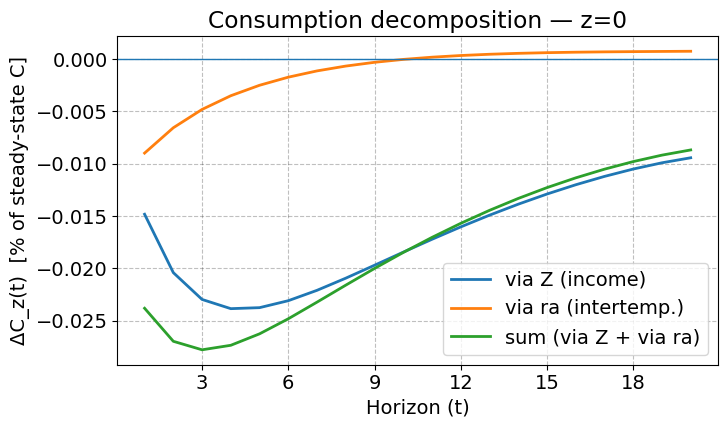

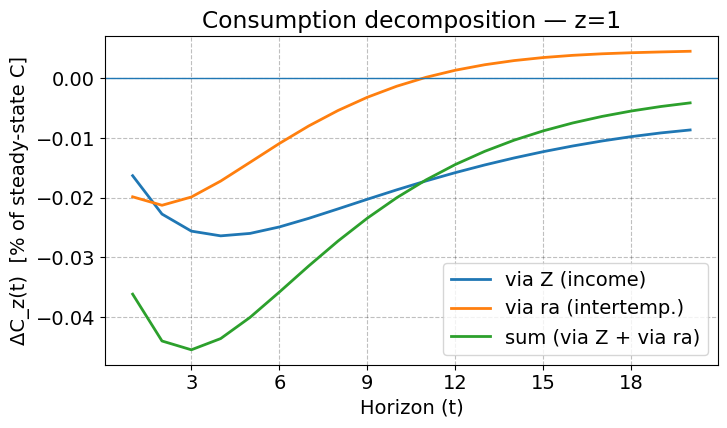

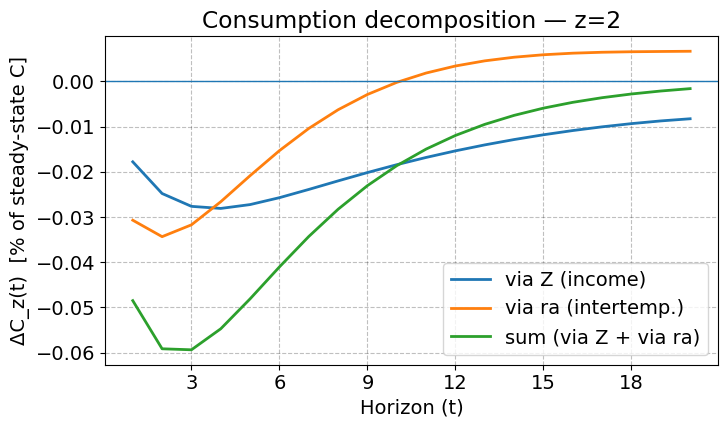

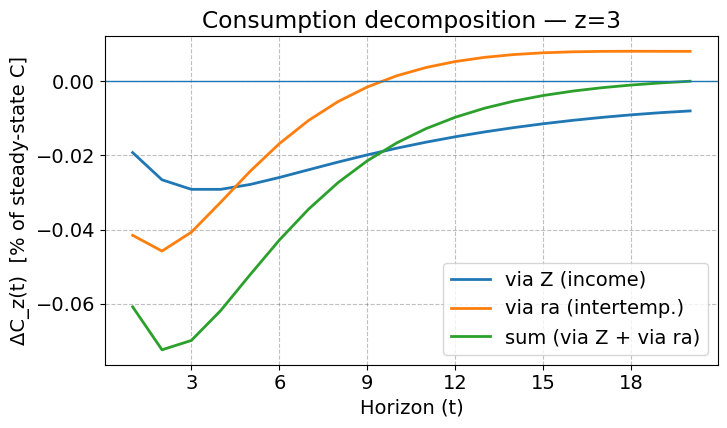

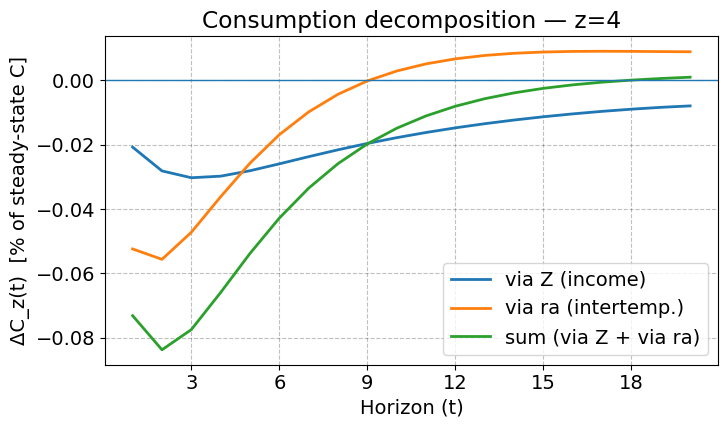

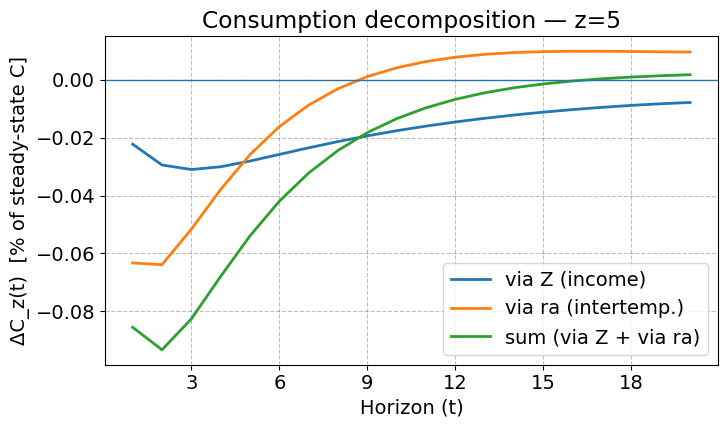

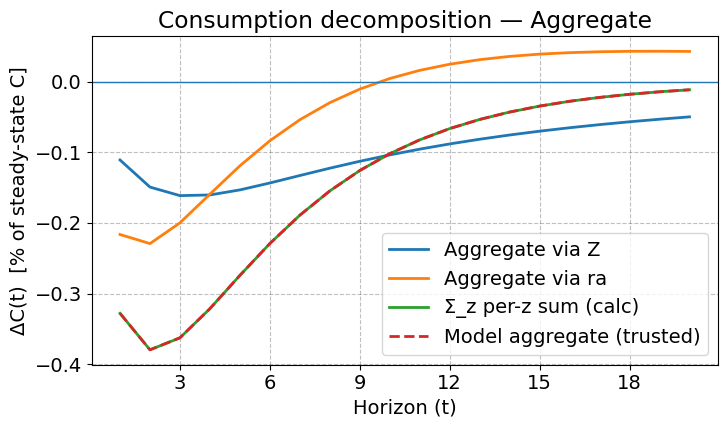

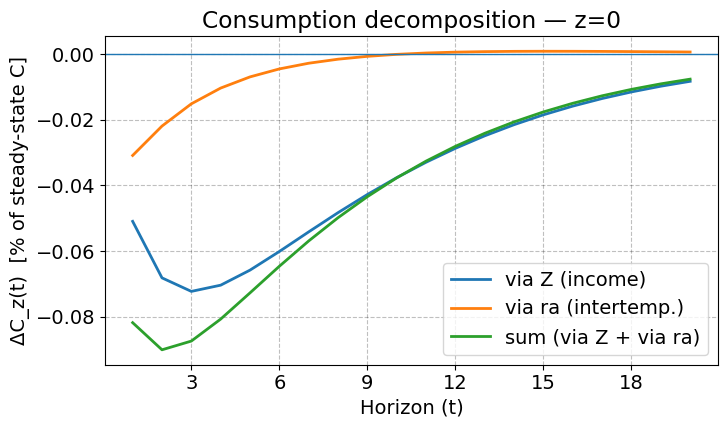

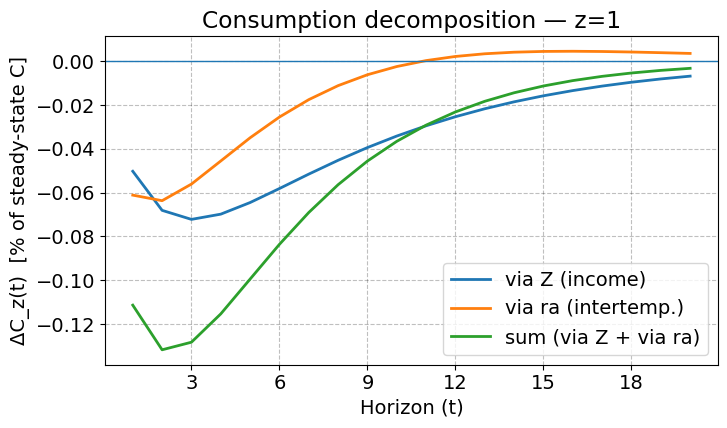

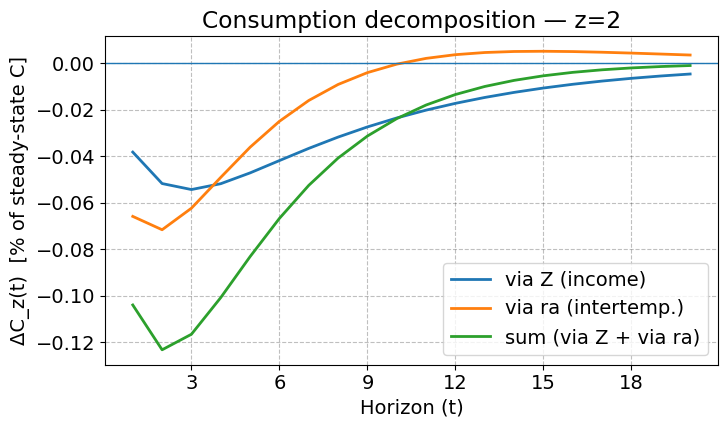

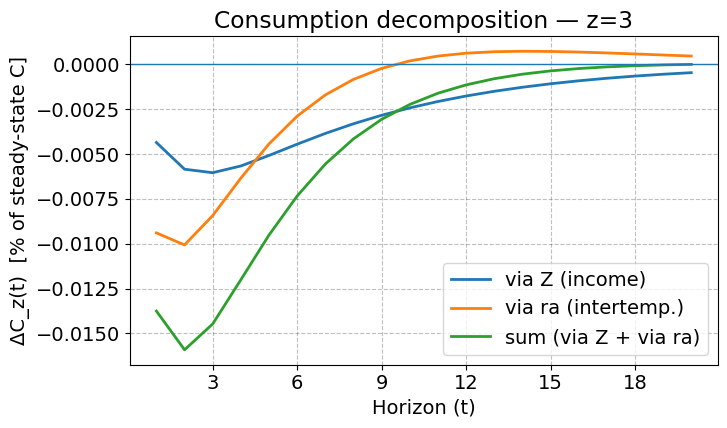

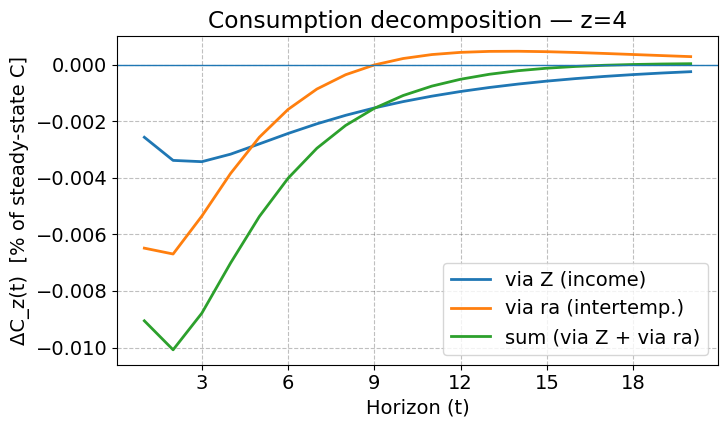

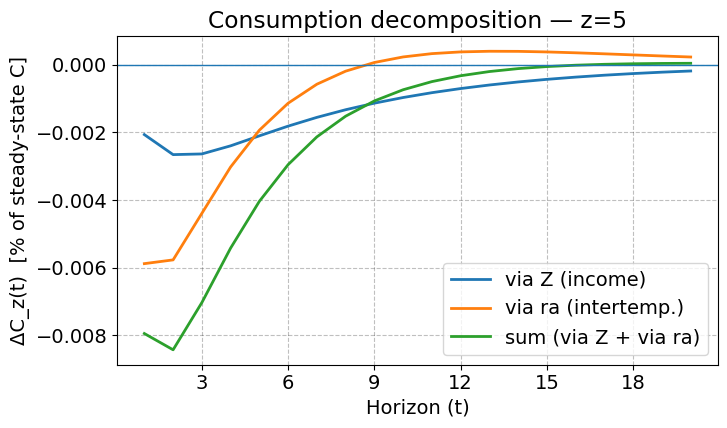

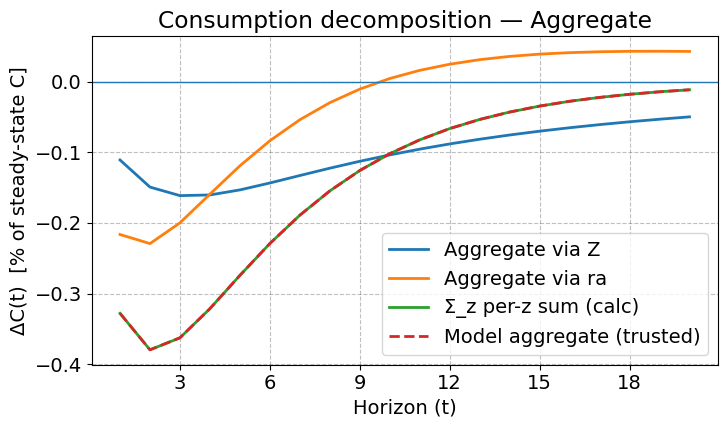

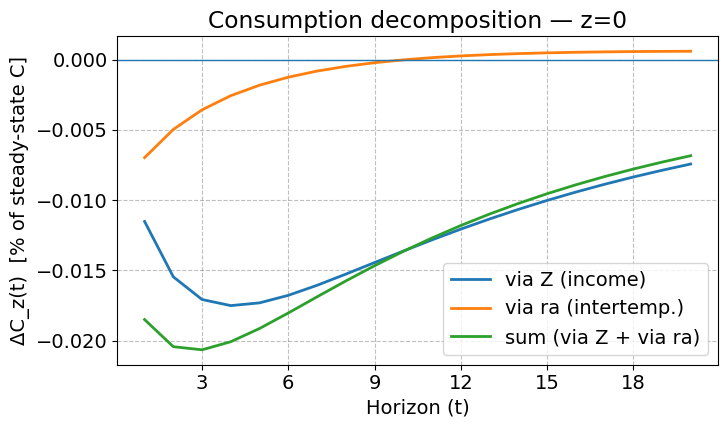

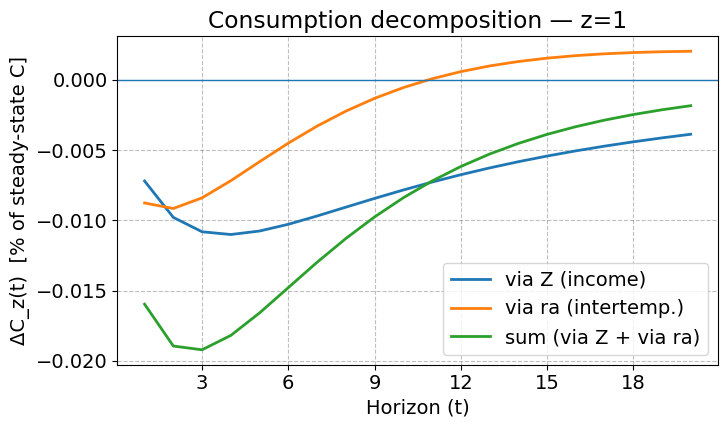

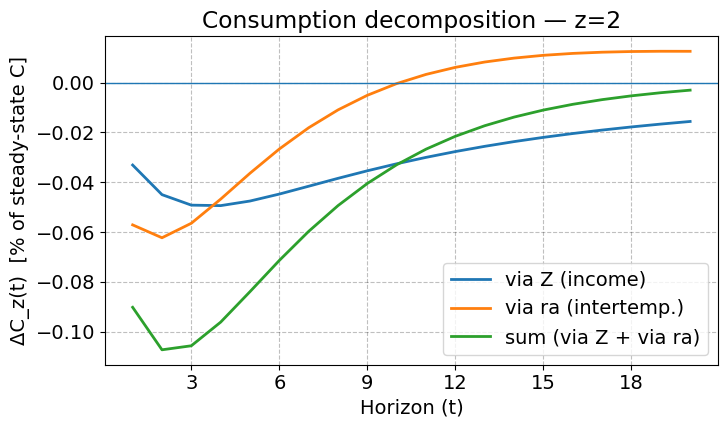

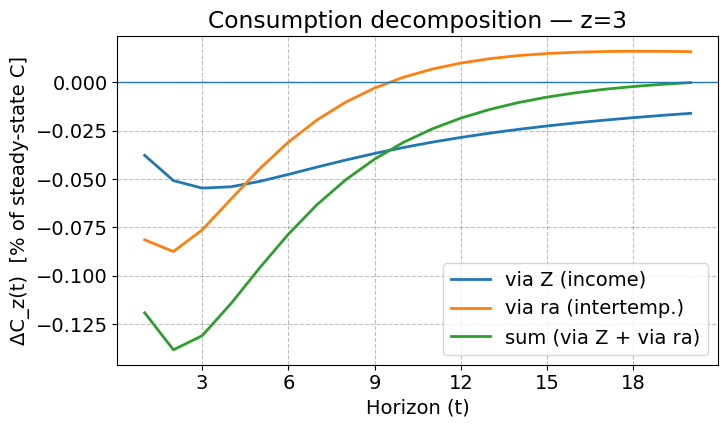

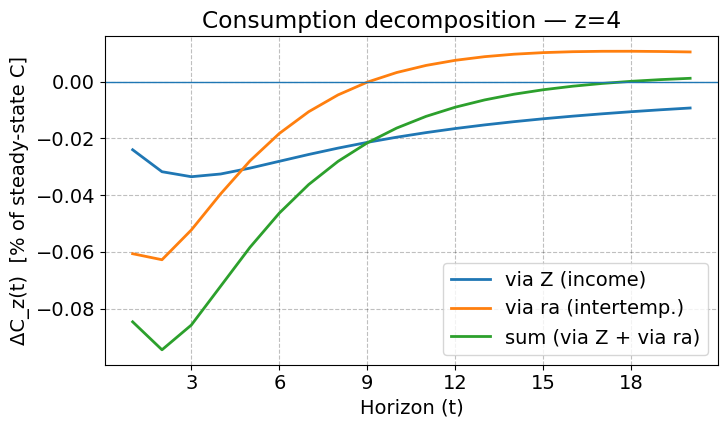

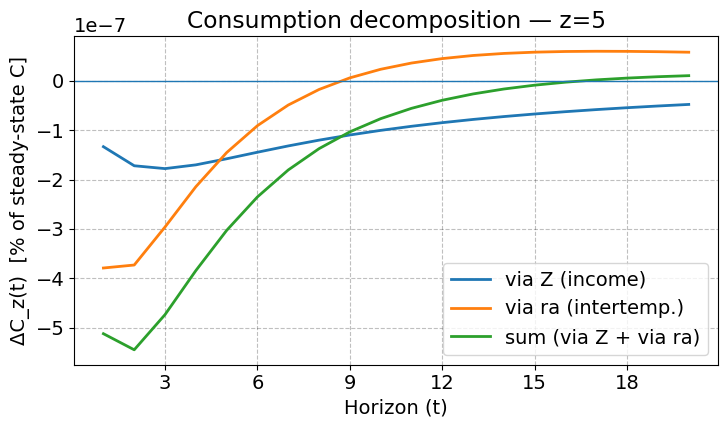

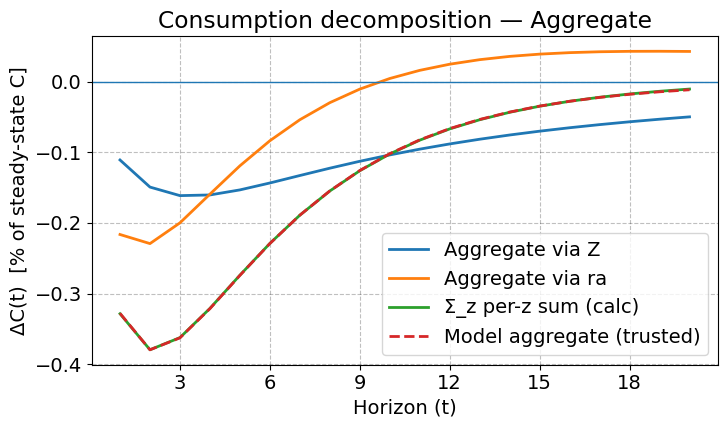

In [71]:
# 1) Keep beliefs as-is; per-z split driven purely by E_by_z
E_by_z = {'Z': E_by_z_sticky['Z'], 'ra': E_by_z_sticky.get('ra', E_by_z_sticky['Z'])}
res = perz_decomp_all(MODEL=model_het, BASE=model, E_by_z=E_by_z, H=20, mode="belief")
plot_perz_and_aggregate_decomp(res, H=20)

# 2) Add structural MPC-style heterogeneity on top (bigger bumps for low z)
res_struct = perz_decomp_all(MODEL=model_het, BASE=model, E_by_z=E_by_z, H=20, mode="mpc")
plot_perz_and_aggregate_decomp(res_struct, H=20)

# 3) Data-driven weights to match TOTAL exactly without per-period scaling
res_fit = perz_decomp_all(MODEL=model_het, BASE=model, E_by_z=E_by_z, H=20, mode="fit", lam=1e-4, floor=1e-6)
plot_perz_and_aggregate_decomp(res_fit, H=20)

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def summarize_assets_by_z(model, percentiles=(0.1, 0.5, 0.9), plot=True, show_pdf=True):
    """
    Summarize steady-state asset holdings by productivity group z.

    Returns a dict with:
      - 'z_weights'   : mass of each productivity group (Nz,)
      - 'mean_a'      : mean assets by z             (Nz,)
      - 'pct_a'       : dict of requested percentiles -> (Nz,) arrays
      - 'pdf_z_a'     : conditional pdf over assets given z  (Nz, Na)
      - 'a_grid'      : asset grid (Na,)

    If plot=True:
      - Figure 1: mean (and requested percentiles) by z (integer x ticks).
      - Figure 2 (optional): conditional pdf(a|z) curves across the asset grid.
    """
    # --- pull steady state objects ---
    ss, par = model.ss, model.par
    D = np.asarray(ss.D)           # (Nfix, Nz, Na) joint distribution
    a = np.asarray(par.a_grid)     # (Na,)
    Nz = int(par.Nz)
    Na = a.size

    # --- collapse over fixed types ---
    Dz_a = D.sum(axis=0)           # (Nz, Na)
    z_weights = Dz_a.sum(axis=1)   # (Nz,)

    # guard against zero-mass groups
    z_weights_safe = np.maximum(z_weights, 1e-16)

    # conditional pdf(a | z)
    pdf_z_a = Dz_a / z_weights_safe[:, None]   # (Nz, Na)

    # means by z
    mean_a = (pdf_z_a @ a)                     # (Nz,)

    # percentiles by z
    pct_a = {}
    cdf_z_a = np.cumsum(pdf_z_a, axis=1)
    for p in percentiles:
        p = float(p)
        # locate first index where CDF >= p for each z
        idx = (cdf_z_a >= p).argmax(axis=1)    # (Nz,)
        # linear interpolation inside the grid cell (optional, robust)
        j_left = np.maximum(idx - 1, 0)
        w_right = np.clip((p - cdf_z_a[np.arange(Nz), j_left]) /
                          np.maximum(cdf_z_a[np.arange(Nz), idx] - cdf_z_a[np.arange(Nz), j_left], 1e-16),
                          0.0, 1.0)
        a_p = a[j_left] + w_right * (a[idx] - a[j_left])
        pct_a[p] = a_p

    out = {
        'z_weights': z_weights,
        'mean_a': mean_a,
        'pct_a': pct_a,
        'pdf_z_a': pdf_z_a,
        'a_grid': a,
    }

    if not plot:
        return out

    # -------- Figure 1: mean & percentiles by z --------
    zs = np.arange(Nz)
    fig = plt.figure(figsize=(7.5, 4.5)); ax = plt.gca()
    ax.plot(zs+1, mean_a, marker='o', linewidth=2, label='Mean a(z)')
    # plot requested percentiles
    for p, arr in pct_a.items():
        ax.plot(zs+1, arr, marker='.', linewidth=1.5, label=f'{int(round(p*100))}th pct')
    ax.set_title("Asset holdings by productivity group")
    ax.set_xlabel("Productivity group (z)")
    ax.set_ylabel("Assets")
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.grid(True, alpha=0.25)
    ax.legend(loc='best')
    fig.tight_layout()
    plt.show()

    # -------- Figure 2: pdf(a | z) across asset grid (optional) --------
    if show_pdf:
        fig = plt.figure(figsize=(7.5, 4.5)); ax = plt.gca()
        for z in range(Nz):
            ax.plot(a, pdf_z_a[z], linewidth=1.7, label=f"z={z}")
        ax.set_title("Conditional distributions pdf(a | z)")
        ax.set_xlabel("Assets (a)")
        ax.set_ylabel("Density")
        ax.legend(ncol=2, fontsize=9)
        ax.grid(True, alpha=0.25)
        fig.tight_layout()
        plt.show()

    return out


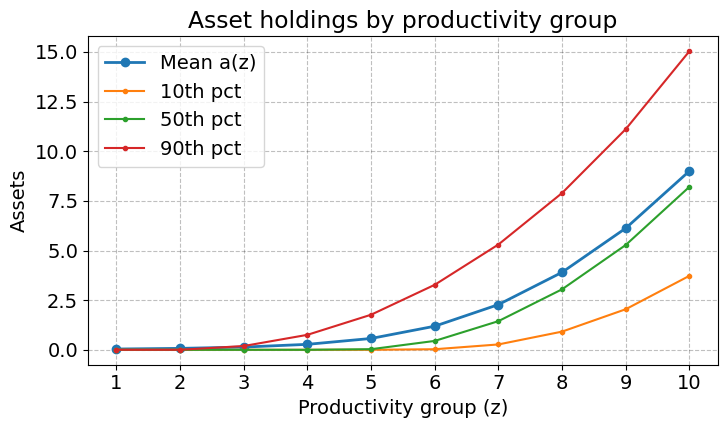

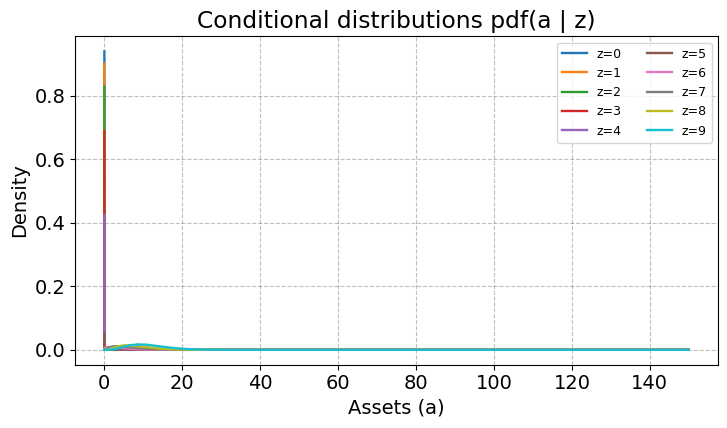

Group masses: [0.00195312 0.01757812 0.0703125  0.1640625  0.24609375 0.24609375
 0.1640625  0.0703125  0.01757812 0.00195312]
Mean assets by z: [0.03905783 0.07147172 0.13702815 0.2747496  0.57057082 1.18774775
 2.27526996 3.90137926 6.12146106 8.99952607]
Median by z: [0.         0.         0.         0.         0.03030236 0.44667102
 1.44203661 3.04629038 5.27666594 8.20495612]


In [44]:
assets = summarize_assets_by_z(model_het, percentiles=(0.1, 0.5, 0.9), plot=True, show_pdf=True)

# Access numbers programmatically:
print("Group masses:", assets['z_weights'])
print("Mean assets by z:", assets['mean_a'])
print("Median by z:", assets['pct_a'][0.5])


In [45]:
import numpy as np
import matplotlib.pyplot as plt

def decompose_C_by_z_and_input(model,
                               inputs=('Z', 'ra'),
                               output='C_hh',
                               T=None,
                               check_consistency=True):
    """
    Decompose the IRF of C_hh into contributions from each input, for each z.

    For each productivity state z, we compute:
        C_z_total(t)  = sum_i J_{C,z,i}(t,s) * IRF[input_i](s)
        C_z_from_inp(t) for inp in inputs

    Parameters
    ----------
    model : GE model object (e.g. model_het)
        Requires:
            model.jac_hh_z[(output, inp)] with shape (Nz, T, T)
            model.IRF[inp] with shape (T,)
            model.IRF[output] with shape (T,)  (for consistency check)
            model.ss.C_hh (steady state level of C_hh)
    inputs : tuple of str
        Inputs to include in the decomposition (default ('Z','ra')).
    output : str
        Household output variable (default 'C_hh').
    T : int or None
        Number of periods to use. If None, use full horizon implied by jacobians.
    check_consistency : bool
        If True, print diagnostic checks.

    Returns
    -------
    C_z_total_pct : np.ndarray, shape (Nz, T)
        Total C_hh^z(t) in percent deviation from steady state.
    C_z_contrib_pct : dict
        Keys are inputs, values are arrays (Nz, T) with percent deviations.
    """

    # 1. Infer Nz and T from one jacobian
    example_key = None
    for inp in inputs:
        key = (output, inp)
        if hasattr(model, 'jac_hh_z') and key in model.jac_hh_z:
            example_key = key
            break
    if example_key is None:
        raise KeyError(f"No per-z Jacobians found for {output} and inputs {inputs}.")

    J_example = model.jac_hh_z[example_key]  # (Nz, T, T)
    Nz, T_jac, _ = J_example.shape

    # Time horizon
    if T is None or T > T_jac:
        T = T_jac

    # 2. Build contributions in levels
    C_z_contrib = {}
    for inp in inputs:
        key = (output, inp)
        if key not in model.jac_hh_z:
            continue

        Jz = model.jac_hh_z[key]        # (Nz, T_jac, T_jac)
        x_irf = model.IRF[inp][:T_jac]  # (T,)

        Cz_inp = np.zeros((Nz, T_jac))
        for iz in range(Nz):
            Cz_inp[iz, :] = Jz[iz] @ x_irf

        C_z_contrib[inp] = Cz_inp[:, :T]  # trim to T

    # 3. Total per z = sum over included inputs
    C_z_total = np.zeros((Nz, T))
    for inp, Cz_inp in C_z_contrib.items():
        C_z_total += Cz_inp

    # 4. Consistency checks
    if check_consistency:

        # a) per-z: total vs sum of contributions
        for iz in range(Nz):
            # recompute sum contributions explicitly for that z
            sum_contrib_z = np.zeros(T)
            for inp in inputs:
                if inp in C_z_contrib:
                    sum_contrib_z += C_z_contrib[inp][iz, :]
            diff_z = C_z_total[iz, :] - sum_contrib_z
            print(f"[decomp] z={iz}: max|total - sum(contrib)| = {np.max(np.abs(diff_z)):.3e}")

        # b) aggregate across z vs model.IRF[output]
        if output in model.IRF:
            C_agg_from_z = C_z_total.sum(axis=0)
            C_agg_model  = model.IRF[output][:T]
            diff_agg = C_agg_from_z - C_agg_model
            print(f"[decomp] aggregate: max|Σ_z total - IRF[{output}]| = {np.max(np.abs(diff_agg)):.3e}")
        else:
            print(f"[decomp] Warning: {output} not in model.IRF, cannot check aggregate consistency.")

    # 5. Convert to percent deviation from steady state
    C_ss = model.ss.C_hh
    if C_ss == 0:
        raise ValueError("Steady-state C_hh is zero — cannot convert to percentages.")

    C_z_total_pct = 100 * C_z_total / C_ss
    C_z_contrib_pct = {inp: 100 * Cz / C_ss for inp, Cz in C_z_contrib.items()}

    return C_z_total_pct, C_z_contrib_pct


def plot_C_by_z_with_input_decomp(model,
                                  inputs=('Z','ra'),
                                  output='C_hh',
                                  T=None,
                                  title_prefix="C_hh IRF by z: total, from Z, from ra"):
    """
    Plot, for each productivity level z, the total C_hh IRF and
    contributions from each input in 'inputs', all in % deviation from SS.

    Returns
    -------
    C_z_total_pct, C_z_contrib_pct as from decompose_C_by_z_and_input.
    """

    C_z_total_pct, C_z_contrib_pct = decompose_C_by_z_and_input(
        model,
        inputs=inputs,
        output=output,
        T=T,
        check_consistency=True
    )

    Nz, T_eff = C_z_total_pct.shape
    t_grid = np.arange(T_eff)

    fig, axes = plt.subplots(Nz, 1, figsize=(7, 2.4 * Nz), sharex=True)
    if Nz == 1:
        axes = [axes]

    for iz in range(Nz):
        ax = axes[iz]

        # total
        ax.plot(t_grid, C_z_total_pct[iz, :], label='total', linewidth=2)

        # contributions from each input
        for inp in inputs:
            if inp in C_z_contrib_pct:
                ax.plot(t_grid, C_z_contrib_pct[inp][iz, :],
                        linestyle='--', linewidth=1.5, label=f'from {inp}')

        ax.axhline(0.0, linestyle=':', linewidth=0.7)
        ax.set_ylabel(f"z={iz}")
        ax.grid(True, alpha=0.3)

        # Put a legend only on first subplot to avoid clutter
        if iz == 0:
            ax.set_title(title_prefix)
            ax.legend(loc='best', fontsize=8)

    axes[-1].set_xlabel("t")
    plt.tight_layout()
    plt.show()

    return C_z_total_pct, C_z_contrib_pct


DET ER RIGTIGT INDTIL HER!!!!

TEST!!::

In [56]:
import numpy as np
import matplotlib.pyplot as plt

# ---- identity cumulative that leaves kernels unchanged under create_alt_M
def _E_identity_cumulative(T: int) -> np.ndarray:
    return np.ones((T, T), dtype=float)

def audit_hh_kernels(model, outs=('C_hh','A_hh'), ins=('Z','ra'), H=None, show_plots=True):
    """
    Run structural and accounting checks on HH kernels:
      - key presence / shapes / finiteness
      - per-z stacks sum to aggregate
      - FIRE identity test (create_alt_M with E≡1 leaves kernels unchanged)
      - triangularity: mass above diagonal
      - reproduce IRFs from kernels and input paths (aggregate & Σz per-z)

    Returns a dict with diagnostics.
    """
    T  = int(model.par.T)
    Nz = int(model.par.Nz)
    H  = min(int(H) if H else T, T)

    report = {'T':T,'Nz':Nz,'H':H,'by_key':{}}

    # 0) guards
    if not hasattr(model, 'jac_hh') or not isinstance(model.jac_hh, dict):
        raise RuntimeError("model.jac_hh missing.")
    if not hasattr(model, 'jac_hh_by_z_stack') or not isinstance(model.jac_hh_by_z_stack, dict):
        raise RuntimeError("model.jac_hh_by_z_stack missing.")

    # 1) loop keys
    for o in outs:
        for i in ins:
            key = (o,i)
            if key not in model.jac_hh:
                print(f"[WARN] aggregate kernel missing: {key}")
                continue
            if key not in model.jac_hh_by_z_stack:
                print(f"[WARN] per-z stack missing: {key}")
                continue

            Kagg = np.asarray(model.jac_hh[key])[:H,:H]
            Kz   = np.asarray(model.jac_hh_by_z_stack[key])[:, :H, :H]  # (Nz,H,H)

            ok_finite = np.isfinite(Kagg).all() and np.isfinite(Kz).all()
            sum_ok = np.allclose(Kagg, Kz.sum(axis=0), atol=1e-12, rtol=1e-12)
            max_abs_diff = float(np.max(np.abs(Kagg - Kz.sum(axis=0))))

            # 2) FIRE identity test (E ≡ 1 must leave kernels unchanged)
            E1 = _E_identity_cumulative(H)
            # test two slices to be quick
            fire_diffs = {}
            for z in (0, Nz-1):
                K_back = create_alt_M(Kz[z], E1)
                fire_diffs[z] = float(np.max(np.abs(K_back - Kz[z])))

            # 3) triangularity (mass above diagonal should be ~0)
            mask_above = np.triu(np.ones((H,H), bool), k=1)
            mass_above_agg = float(np.linalg.norm(Kagg[mask_above]))
            mass_above_z   = [float(np.linalg.norm(Kz[z][mask_above])) for z in range(Nz)]

            # 4) reproduce IRFs from kernels and inputs (levels)
            Zp  = np.asarray(model.IRF.get(i, None))
            if Zp is None:
                # input series may be named differently; try model.IRF paths you use in decomp()
                Zp = np.asarray(model.IRF[i])
            Zp  = Zp[:H]
            contrib_z = np.einsum('zts,s->zt', Kz, Zp)       # (Nz,H)
            contrib_ag_calc = contrib_z.sum(axis=0)          # (H,)
            # Compare to model's output series:
            Yout = np.asarray(model.IRF.get(o, None))
            if Yout is None:
                Yout = np.asarray(model.IRF[o])
            Yout = Yout[:H]
            # Note: this is single-input contribution; the model's Yout includes all inputs.
            # So we only compare the sum across inputs after looping both Z and ra below.

            report['by_key'][key] = {
                'finite': ok_finite,
                'sum_ok': sum_ok,
                'max_abs_sum_error': max_abs_diff,
                'fire_maxdiff_z0': fire_diffs.get(0, np.nan),
                'fire_maxdiff_zLast': fire_diffs.get(Nz-1, np.nan),
                'mass_above_diag_agg': mass_above_agg,
                'mass_above_diag_perz': mass_above_z,
                'contrib_z': contrib_z,           # keep for later aggregation across inputs
                'contrib_ag_calc': contrib_ag_calc
            }

    # 5) Reconstruct output from BOTH inputs and compare to model series
    #    Only for C_hh (most important here).
    if ('C_hh','Z') in report['by_key'] and ('C_hh','ra') in report['by_key']:
        CzZ = report['by_key'][('C_hh','Z')]['contrib_z']     # (Nz,H)
        CzR = report['by_key'][('C_hh','ra')]['contrib_z']
        CzS = CzZ + CzR
        agg_calc = CzS.sum(axis=0)                            # (H,)

        C_model = np.asarray(model.IRF['C_hh'])[:H]
        report['C_reconstruction'] = {
            'max_abs_error': float(np.max(np.abs(agg_calc - C_model))),
            'series_calc': agg_calc,
            'series_model': C_model
        }

        if show_plots:
            x = np.arange(1, H+1)
            plt.figure(figsize=(6.2,4.2))
            plt.plot(x, agg_calc, label='Σz (via Z + via ra) — calc', linewidth=2.2)
            plt.plot(x, C_model, '--', label='model C_hh', linewidth=2.2)
            plt.grid(alpha=0.3); plt.title('Aggregate C_hh reconstruction check'); plt.xlabel('Horizon'); plt.legend(); plt.show()

    # 6) print concise summary
    print("=== Kernel audit summary ===")
    for key, R in report['by_key'].items():
        print(f"{key}: finite={R['finite']}, sum_ok={R['sum_ok']}, "
              f"max|Σz-agg|={R['max_abs_sum_error']:.3e}, "
              f"FIRE z0/zLast max|Δ|=({R['fire_maxdiff_z0']:.3e},{R['fire_maxdiff_zLast']:.3e}), "
              f"||above_diag|| (agg)={R['mass_above_diag_agg']:.3e}")

    if 'C_reconstruction' in report:
        e = report['C_reconstruction']['max_abs_error']
        print(f"[C_hh reconstruction] max abs error vs model: {e:.3e}")

    return report


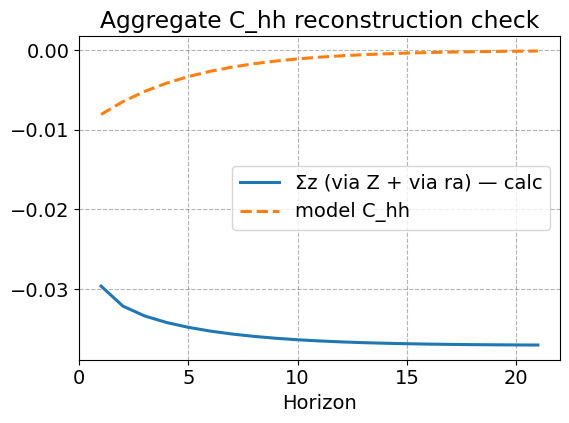

=== Kernel audit summary ===
('C_hh', 'Z'): finite=True, sum_ok=True, max|Σz-agg|=1.665e-15, FIRE z0/zLast max|Δ|=(0.000e+00,0.000e+00), ||above_diag|| (agg)=1.160e+01
('C_hh', 'ra'): finite=True, sum_ok=True, max|Σz-agg|=2.842e-14, FIRE z0/zLast max|Δ|=(0.000e+00,0.000e+00), ||above_diag|| (agg)=1.561e+02
('A_hh', 'Z'): finite=True, sum_ok=True, max|Σz-agg|=4.441e-16, FIRE z0/zLast max|Δ|=(0.000e+00,0.000e+00), ||above_diag|| (agg)=8.302e-01
('A_hh', 'ra'): finite=True, sum_ok=True, max|Σz-agg|=2.309e-14, FIRE z0/zLast max|Δ|=(0.000e+00,0.000e+00), ||above_diag|| (agg)=1.726e+02
[C_hh reconstruction] max abs error vs model: 3.695e-02


In [57]:
# Run this on the model RIGHT AFTER you build jac_hh_by_z_stack (no belief transforms yet)
audit = audit_hh_kernels(model, outs=('C_hh','A_hh'), ins=('Z','ra'), H=21, show_plots=True)


In [58]:
import numpy as np
import matplotlib.pyplot as plt

def reconstruct_C_from_all_hh_inputs(model, H=21, show_plot=True):
    """
    Rebuild C_hh(t) by summing contributions from *all* household inputs that
    appear with ('C_hh', input) in model.jac_hh. Uses the model's realized input
    paths model.IRF[input] for each input.
    """
    T = int(model.par.T)
    H = min(int(H), T)

    # discover all inputs that drive C_hh in the HH Jacobian
    inputs = sorted({ i for (o,i) in model.jac_hh.keys() if o == 'C_hh' })
    if not inputs:
        raise RuntimeError("No ('C_hh', ·) kernels found in model.jac_hh.")

    # sum contributions across inputs (aggregate kernels)
    contrib_sum = np.zeros(H)
    per_input_contrib = {}

    for i in inputs:
        K = np.asarray(model.jac_hh[('C_hh', i)])[:H, :H]   # (H,H)
        x = np.asarray(model.IRF[i])[:H]                    # (H,)
        c = K @ x                                           # (H,)
        per_input_contrib[i] = c
        contrib_sum += c

    C_model = np.asarray(model.IRF['C_hh'])[:H]
    max_err  = float(np.max(np.abs(contrib_sum - C_model)))

    if show_plot:
        x_axis = np.arange(1, H+1)
        plt.figure(figsize=(6.4,4.2))
        for i in inputs:
            plt.plot(x_axis, per_input_contrib[i], label=f"via {i}", linewidth=1.8)
        plt.plot(x_axis, contrib_sum, label="Σ inputs (calc)", linewidth=2.6)
        plt.plot(x_axis, C_model, '--', label="model C_hh", linewidth=2.6)
        plt.grid(alpha=0.3); plt.xlabel("Horizon"); plt.title("C_hh reconstruction from all HH inputs")
        plt.legend(); plt.show()

    return {"inputs": inputs, "calc": contrib_sum, "model": C_model, "max_abs_error": max_err}


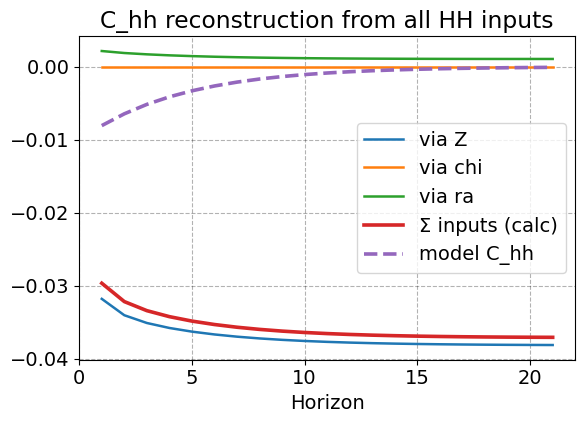

inputs used: ['Z', 'chi', 'ra']
max abs error: 0.03694517350718114


In [59]:
rec = reconstruct_C_from_all_hh_inputs(model, H=21, show_plot=True)
print("inputs used:", rec["inputs"])
print("max abs error:", rec["max_abs_error"])


In [60]:
import numpy as np
import matplotlib.pyplot as plt

def check_units_and_reconstruct_C(model, H=21):
    T = int(model.par.T); H = min(H, T)
    # discover all HH inputs for C_hh
    inputs = sorted({ i for (o,i) in model.jac_hh.keys() if o == 'C_hh' })

    # reconstruct in LEVELS from kernels
    calc_levels = np.zeros(H)
    per_input = {}
    for i in inputs:
        K = np.asarray(model.jac_hh[('C_hh', i)])[:H,:H]  # (H,H)
        x = np.asarray(model.IRF[i])[:H]                  # assume levels
        c = K @ x
        per_input[i] = c
        calc_levels += c

    C_model_raw = np.asarray(model.IRF['C_hh'])[:H]
    Css = float(model.ss.C_hh)

    # Try to infer if IRF['C_hh'] is in % of ss
    # Fit a scalar alpha such that alpha*calc_levels ≈ C_model_raw (least squares)
    alpha = float(np.dot(calc_levels, C_model_raw) / max(np.dot(calc_levels, calc_levels), 1e-30))
    # If model is in %, alpha should be roughly 100/Css (or 1/Css if in fractions)
    print(f"heuristic alpha ≈ {alpha:.6g},  100/Css = {100./Css:.6g},  1/Css = {1./Css:.6g}")

    # Compare both ways
    calc_pct = 100.0 * calc_levels / Css

    err_levels = np.max(np.abs(calc_levels - C_model_raw))
    err_pct    = np.max(np.abs(calc_pct    - C_model_raw))

    which = "levels" if err_levels < err_pct else "percent"
    print(f"Max abs error if model is LEVELS : {err_levels:.3e}")
    print(f"Max abs error if model is PERCENT: {err_pct:.3e}")
    print(f"→ Best match suggests model.IRF['C_hh'] is in **{which}**.")

    # Plot best match
    x = np.arange(1, H+1)
    plt.figure(figsize=(6.4,4.2))
    if which == "levels":
        for i in inputs: plt.plot(x, per_input[i], label=f"via {i}")
        plt.plot(x, calc_levels, label="Σ inputs (calc)")
        plt.plot(x, C_model_raw, '--', label="model C_hh")
        plt.ylabel("levels")
    else:
        for i in inputs: plt.plot(x, 100.0*per_input[i]/Css, label=f"via {i}")
        plt.plot(x, calc_pct, label="Σ inputs (calc)")
        plt.plot(x, C_model_raw, '--', label="model C_hh")
        plt.ylabel("% of ss")
    plt.xlabel("Horizon"); plt.title("C_hh reconstruction (unit check)")
    plt.grid(alpha=0.3); plt.legend(); plt.show()

    return {"unit_guess": which, "alpha_ls": alpha, "calc_levels": calc_levels, "calc_pct": calc_pct}


heuristic alpha ≈ 0.0499383,  100/Css = 100,  1/Css = 1
Max abs error if model is LEVELS : 3.695e-02
Max abs error if model is PERCENT: 3.704e+00
→ Best match suggests model.IRF['C_hh'] is in **levels**.


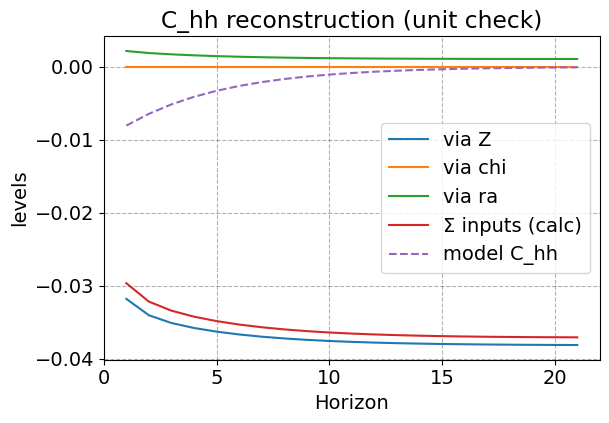

In [61]:
unit_info = check_units_and_reconstruct_C(model, H=21)


In [62]:
import numpy as np

def _canon_out(x): 
    s=str(x).lower(); return 'C_hh' if s.startswith('c') else ('A_hh' if s.startswith('a') else x)
def _canon_in(x):
    s=str(x).lower()
    return 'Z' if s.startswith('z') else ('ra' if s.startswith('ra') or s=='r' else x)

def _normalize_hh_keys_inplace(model):
    if hasattr(model,'jac_hh') and isinstance(model.jac_hh,dict):
        model.jac_hh = {(_canon_out(o),_canon_in(i)):v for (o,i),v in model.jac_hh.items()}
    if hasattr(model,'jac_hh_by_z_stack') and isinstance(model.jac_hh_by_z_stack,dict):
        model.jac_hh_by_z_stack = {(_canon_out(o),_canon_in(i)):v for (o,i),v in model.jac_hh_by_z_stack.items()}
    if hasattr(model,'jac_hh_by_z') and isinstance(model.jac_hh_by_z,dict):
        model.jac_hh_by_z = {((_canon_out(o),_canon_in(i)),int(z)):v for ((o,i),z),v in model.jac_hh_by_z.items()}

def _mirror_perz_attrs(dst, src):
    if (not hasattr(dst,'jac_hh_by_z_stack')) and hasattr(src,'jac_hh_by_z_stack'):
        dst.jac_hh_by_z_stack = {k:v.copy() for k,v in src.jac_hh_by_z_stack.items()}
    if (not hasattr(dst,'jac_hh_by_z')) and hasattr(src,'jac_hh_by_z'):
        dst.jac_hh_by_z = {k:v.copy() for k,v in src.jac_hh_by_z.items()}

def _expand_E_dict(E_by_z, T, Nz, inputs=('Z','ra')):
    if isinstance(E_by_z, dict):
        out={}
        for inp in inputs:
            L = E_by_z.get(inp, E_by_z.get('Z', None))
            if L is None: raise KeyError(f"No E for '{inp}'.")
            if len(L)!=Nz: raise ValueError(f"{inp}: need {Nz} matrices, got {len(L)}.")
            out[inp] = [np.asarray(E)[:T,:T] for E in L]
        return out
    Eh = np.asarray(E_by_z)
    if Eh.shape!=(T,T): raise ValueError(f"Homogeneous E must be {(T,T)}, got {Eh.shape}.")
    return {inp:[Eh for _ in range(Nz)] for inp in inputs}

def solve_alt_exp_perz_transform_only(model, E_by_z, sticky_vars=('Z','ra'), outs=('C_hh','A_hh'),
                                      in_place=False, print_checks=True):
    """
    Exactly the original logic, but per-z:
      J_new^{(z)} = create_alt_M(J_fire^{(z)}, E^{(z)}),  then  J_agg = Σ_z J_new^{(z)}.
    Then refresh upper blocks and IRFs with skip_hh=True.
    """
    ms = model if in_place else model.copy()
    _mirror_perz_attrs(ms, model)
    _normalize_hh_keys_inplace(ms)

    T  = int(ms.par.T); Nz = int(ms.par.Nz)
    E_norm = _expand_E_dict(E_by_z, T, Nz, inputs=tuple(_canon_in(i) for i in sticky_vars))

    # guards
    if not hasattr(ms, 'jac_hh_by_z_stack'):
        raise KeyError("jac_hh_by_z_stack missing; build per-z FIRE stacks first.")
    need = [(_canon_out(o), _canon_in(i)) for o in outs for i in sticky_vars]
    for key in need:
        if key not in ms.jac_hh_by_z_stack:
            have = sorted(ms.jac_hh_by_z_stack.keys())
            raise KeyError(f"Per-z stack missing for {key}. Available: {have}")

    # per-z transform and aggregate
    for o in outs:
        oC = _canon_out(o)
        for i in sticky_vars:
            iC = _canon_in(i)
            key = (oC, iC)

            Jz_fire = np.asarray(ms.jac_hh_by_z_stack[key])          # (Nz,T,T), assumed FIRE
            Ez_list = E_norm[iC]                                     # list of Nz (T,T)
            Jz_new  = np.empty_like(Jz_fire)
            for z in range(Nz):
                Jz_new[z] = create_alt_M(Jz_fire[z], Ez_list[z])

            ms.jac_hh_by_z_stack[key] = Jz_new
            if hasattr(ms, 'jac_hh_by_z'):
                for z in range(Nz):
                    ms.jac_hh_by_z[(key, z)] = Jz_new[z]
            ms.jac_hh[key] = Jz_new.sum(axis=0)

            if print_checks:
                ok = np.allclose(ms.jac_hh[key], Jz_new.sum(axis=0), atol=1e-12, rtol=1e-12)
                print(f"{key}: Σ_z per-z == aggregate? {ok}")

    # Refresh non-HH blocks and IRFs (HH jacs already set)
    ms.compute_jacs(skip_hh=True, skip_shocks=False)
    ms.find_IRFs(shocks=getattr(ms, 'shocks', ['eps_i']), do_print=False)
    return ms


In [63]:
E_by_z = {'Z': E_by_z_sane['Z'], 'ra': E_by_z_sane.get('ra', E_by_z_sane['Z'])}
model_het = solve_alt_exp_perz_transform_only(model, E_by_z,
                                              sticky_vars=('Z','ra'),
                                              outs=('C_hh','A_hh'),
                                              in_place=False,
                                              print_checks=True)


('C_hh', 'Z'): Σ_z per-z == aggregate? True
('C_hh', 'ra'): Σ_z per-z == aggregate? True
('A_hh', 'Z'): Σ_z per-z == aggregate? True
('A_hh', 'ra'): Σ_z per-z == aggregate? True


In [51]:
# ---------- FIXED HELPERS ----------
def _E_identity_cumulative(T: int) -> np.ndarray:
    """
    Identity for your cumulative operator in create_alt_M:
    E ≡ 1  ⇒ ΔE[0,s]=1 and ΔE[k>0,s]=0  ⇒ create_alt_M(M, E) == M.
    """
    return np.ones((T, T), dtype=float)

def invert_alt_M(M_eff, E, eps=1e-14):
    """
    Solve M_eff = create_alt_M(M_base, E) for M_base by back-substitution
    along diagonals. Robust to tiny dE[0,s] via clipping by `eps`.
    """
    T, m = M_eff.shape
    assert T == m and E.shape == (T, T)
    M = np.zeros_like(M_eff)

    # ΔE[tau,s] with ΔE[0,s]=E[0,s]
    dE = E.copy()
    dE[1:, :] -= E[:-1, :]

    for s in range(T):
        dE0 = dE[0, s]
        if abs(dE0) < eps:
            dE0 = eps  # avoid divide-by-zero; identity case should have dE0=1
        for t in range(s, T):
            tau = t - s
            acc = 0.0
            # sum k = 1..tau
            for k in range(1, tau + 1):
                acc += dE[k, s] * M[t - k, s - k]
            M[t, s] = (M_eff[t, s] - acc) / dE0
    return M


In [52]:
def clean_to_FIRE_then_apply(model,
                             E_old_by_z,                 # dict or (T,T)
                             E_new_by_z,                 # dict or (T,T)
                             sticky_vars=('Z','ra'),
                             outs=('C_hh','A_hh'),
                             in_place=False,
                             check=True,
                             diag=False):
    ms = model if in_place else model.copy()
    # mirror custom dicts if copy() dropped them
    if (not hasattr(ms, 'jac_hh_by_z_stack')) and hasattr(model, 'jac_hh_by_z_stack'):
        ms.jac_hh_by_z_stack = {k: v.copy() for k, v in model.jac_hh_by_z_stack.items()}
    if (not hasattr(ms, 'jac_hh_by_z')) and hasattr(model, 'jac_hh_by_z'):
        ms.jac_hh_by_z = {k: v.copy() for k, v in model.jac_hh_by_z.items()}

    # normalize keys
    def _canon_out(x): return 'C_hh' if str(x).lower().startswith('c') else ('A_hh' if str(x).lower().startswith('a') else x)
    def _canon_in(x):
        s = str(x).lower()
        return 'Z' if s.startswith('z') else ('ra' if s.startswith('ra') or s == 'r' else x)
    if isinstance(ms.jac_hh, dict):
        ms.jac_hh = {(_canon_out(o), _canon_in(i)): v for (o, i), v in ms.jac_hh.items()}
    if isinstance(ms.jac_hh_by_z_stack, dict):
        ms.jac_hh_by_z_stack = {(_canon_out(o), _canon_in(i)): v for (o, i), v in ms.jac_hh_by_z_stack.items()}
    if hasattr(ms, 'jac_hh_by_z') and isinstance(ms.jac_hh_by_z, dict):
        ms.jac_hh_by_z = {((_canon_out(o), _canon_in(i)), int(z)): v for ((o, i), z), v in ms.jac_hh_by_z.items()}

    T, Nz = int(ms.par.T), int(ms.par.Nz)

    # normalize E inputs to dict: inp -> list of Nz (T,T)
    def _expand(E_src, inputs=('Z','ra')):
        if isinstance(E_src, dict):
            out = {}
            for inp in inputs:
                L = E_src.get(inp, E_src.get('Z', None))
                if L is None:
                    raise KeyError(f"No E provided for '{inp}'.")
                if len(L) != Nz:
                    raise ValueError(f"{inp}: need {Nz} matrices, got {len(L)}.")
                out[inp] = [np.asarray(E)[:T, :T] for E in L]
            return out
        Eh = np.asarray(E_src)
        if Eh.shape != (T, T):
            raise ValueError(f"Homogeneous E must be {(T,T)}, got {Eh.shape}.")
        return {inp: [Eh for _ in range(Nz)] for inp in inputs}

    Eold = _expand(E_old_by_z, inputs=tuple(_canon_in(i) for i in sticky_vars))
    Enew = _expand(E_new_by_z, inputs=tuple(_canon_in(i) for i in sticky_vars))

    need = [(_canon_out(o), _canon_in(i)) for o in outs for i in sticky_vars]
    if not hasattr(ms, 'jac_hh_by_z_stack'):
        raise KeyError("jac_hh_by_z_stack missing; build per-z stacks first.")
    for key in need:
        if key not in ms.jac_hh_by_z_stack:
            raise KeyError(f"Per-z stack missing for {key}.")

    for o in outs:
        oC = _canon_out(o)
        for i in sticky_vars:
            iC = _canon_in(i)
            key = (oC, iC)

            Jz_eff = np.asarray(ms.jac_hh_by_z_stack[key])  # (Nz,T,T)
            Jz_fire = np.empty_like(Jz_eff)
            Jz_new  = np.empty_like(Jz_eff)

            # 1) invert to FIRE with corrected inverse
            for z in range(Nz):
                Jz_fire[z] = invert_alt_M(Jz_eff[z], Eold[iC][z])

            # 2) apply new beliefs once
            for z in range(Nz):
                Jz_new[z] = create_alt_M(Jz_fire[z], Enew[iC][z])

            # 3) write back and aggregate
            ms.jac_hh_by_z_stack[key] = Jz_new
            if hasattr(ms, 'jac_hh_by_z'):
                for z in range(Nz):
                    ms.jac_hh_by_z[(key, z)] = Jz_new[z]
            ms.jac_hh[key] = Jz_new.sum(axis=0)

            if check:
                ok = np.allclose(ms.jac_hh[key], Jz_new.sum(axis=0), atol=1e-12, rtol=1e-12)
                if not ok:
                    raise AssertionError(f"{key}: Σ_z per-z != aggregate after update.")
            if diag:
                print(f"{key}: wrote per-z and aggregate (Σ_z==agg).")

    # refresh non-HH blocks & IRFs
    ms.compute_jacs(skip_hh=True, skip_shocks=False)
    ms.find_IRFs(shocks=getattr(ms, 'shocks', ['eps_i']), do_print=False)
    return ms


In [53]:
T, Nz = int(model.par.T), int(model.par.Nz)

# Identity for "current stacks are FIRE" case:
E_id = _E_identity_cumulative(T)            # <-- all ones, not tril
E_old = {'Z': [E_id]*Nz, 'ra': [E_id]*Nz}

# Your heterogeneous beliefs to apply:
E_new = {'Z': E_by_z_sane['Z'], 'ra': E_by_z_sane.get('ra', E_by_z_sane['Z'])}

model_het = clean_to_FIRE_then_apply(
    model,
    E_old_by_z=E_old,
    E_new_by_z=E_new,
    sticky_vars=('Z','ra'),
    outs=('C_hh','A_hh'),
    in_place=False,
    check=True,
    diag=True
)


('C_hh', 'Z'): wrote per-z and aggregate (Σ_z==agg).
('C_hh', 'ra'): wrote per-z and aggregate (Σ_z==agg).
('A_hh', 'Z'): wrote per-z and aggregate (Σ_z==agg).
('A_hh', 'ra'): wrote per-z and aggregate (Σ_z==agg).


In [49]:
# ============================ ONE DROP-IN ============================
import numpy as np

# ---- your forward operator is used as-is
# def create_alt_M(M, E): ...  # <- already defined in your code

# ---- helpers
def _canon_out(x):
    s = str(x).lower()
    return 'C_hh' if s.startswith('c') else ('A_hh' if s.startswith('a') else x)

def _canon_in(x):
    s = str(x).lower()
    if s.startswith('z'):   return 'Z'
    if s.startswith('ra') or s == 'r': return 'ra'
    return x

def _normalize_hh_keys_inplace(model):
    if hasattr(model, 'jac_hh') and isinstance(model.jac_hh, dict):
        model.jac_hh = {(_canon_out(o), _canon_in(i)): v for (o,i), v in model.jac_hh.items()}
    if hasattr(model, 'jac_hh_by_z_stack') and isinstance(model.jac_hh_by_z_stack, dict):
        model.jac_hh_by_z_stack = {(_canon_out(o), _canon_in(i)): v
                                   for (o,i), v in model.jac_hh_by_z_stack.items()}
    if hasattr(model, 'jac_hh_by_z') and isinstance(model.jac_hh_by_z, dict):
        model.jac_hh_by_z = {((_canon_out(o), _canon_in(i)), int(z)): v
                             for ((o,i), z), v in model.jac_hh_by_z.items()}

def _mirror_perz_attrs(dst, src):
    """Ensure a copy() keeps your custom per-z dicts."""
    if (not hasattr(dst, 'jac_hh_by_z_stack')) and hasattr(src, 'jac_hh_by_z_stack'):
        dst.jac_hh_by_z_stack = {k: v.copy() for k, v in src.jac_hh_by_z_stack.items()}
    if (not hasattr(dst, 'jac_hh_by_z')) and hasattr(src, 'jac_hh_by_z'):
        dst.jac_hh_by_z = {k: v.copy() for k, v in src.jac_hh_by_z.items()}

def _E_identity_cumulative(T):
    """Lower-triangular ones = identity under your cumulative operator."""
    return np.tril(np.ones((T,T), dtype=float))

def _expand_E_dict(E_by_z, T, Nz, inputs=('Z','ra')):
    """
    Normalize expectations into dict: inp -> list of Nz (T,T) arrays.
    Accepts either: dict with lists, or a single (T,T) to broadcast.
    """
    if isinstance(E_by_z, dict):
        out = {}
        for inp in inputs:
            L = E_by_z.get(inp, E_by_z.get('Z', None))
            if L is None:
                raise KeyError(f"No E provided for input '{inp}'.")
            if len(L) != Nz:
                raise ValueError(f"{inp}: need {Nz} matrices, got {len(L)}.")
            out[inp] = [np.asarray(E)[:T,:T] for E in L]
        return out
    else:
        Eh = np.asarray(E_by_z)
        if Eh.shape != (T,T):
            raise ValueError(f"Homogeneous E must be {(T,T)}, got {Eh.shape}.")
        return {inp: [Eh for _ in range(Nz)] for inp in inputs}

# ---- exact inverse of your create_alt_M (back-substitution along diagonals)
def invert_alt_M(M_eff, E):
    """
    Solve for M_base in  M_eff = create_alt_M(M_base, E).
    E is cumulative; we use ΔE[0,s] and ΔE[k>0,s] to back out M_base[t,s].
    """
    T, m = M_eff.shape
    assert T == m and E.shape == (T,T)
    M = np.zeros_like(M_eff)

    dE = E.copy()
    dE[1:,:] -= E[:-1,:]  # ΔE[tau,s]

    for s in range(T):
        for t in range(s, T):
            tau = t - s
            # M_eff[t,s] = sum_{k=0..tau} ΔE[k,s] * M[t-k, s-k]
            # isolate k=0 term
            acc = 0.0
            for k in range(1, tau+1):
                acc += dE[k, s] * M[t-k, s-k]
            M[t, s] = (M_eff[t, s] - acc) / dE[0, s]
    return M

# ---- main: clean current stacks back to FIRE, then apply new beliefs once
def clean_to_FIRE_then_apply(model,
                             E_old_by_z,                 # dict or (T,T): beliefs CURRENTLY baked into stacks
                             E_new_by_z,                 # dict or (T,T): beliefs you WANT to apply
                             sticky_vars=('Z','ra'),
                             outs=('C_hh','A_hh'),
                             in_place=False,
                             check=True,                 # confirm Σz==agg after writeback
                             diag=False):                # print small diagnostics
    """
    1) Read per-z HH stacks Jz_eff = model.jac_hh_by_z_stack[(OUT,IN)] (Nz,T,T).
    2) FIRE recovery:  Jz_fire[z] = invert_alt_M(Jz_eff[z], E_old_by_z[input][z])
    3) Apply new beliefs: Jz_new[z] = create_alt_M(Jz_fire[z], E_new_by_z[input][z])
    4) Write back per-z and aggregate; refresh non-HH blocks and IRFs.

    If your current stacks are already FIRE, pass E_old_by_z as identity.
    """
    ms = model if in_place else model.copy()
    _mirror_perz_attrs(ms, model)
    _normalize_hh_keys_inplace(ms)

    T  = int(ms.par.T)
    Nz = int(ms.par.Nz)

    # normalize expectations
    Eold = _expand_E_dict(E_old_by_z, T, Nz, inputs=tuple(_canon_in(i) for i in sticky_vars))
    Enew = _expand_E_dict(E_new_by_z, T, Nz, inputs=tuple(_canon_in(i) for i in sticky_vars))

    # guards
    if not hasattr(ms, 'jac_hh_by_z_stack'):
        raise KeyError("jac_hh_by_z_stack missing; build per-z stacks first.")
    need = [(_canon_out(o), _canon_in(i)) for o in outs for i in sticky_vars]
    missing = [k for k in need if k not in ms.jac_hh_by_z_stack]
    if missing:
        have = sorted(ms.jac_hh_by_z_stack.keys())
        raise KeyError(f"Per-z stacks missing for {missing}. Available: {have}")

    # transform per (OUT,IN)
    for o in outs:
        oC = _canon_out(o)
        for i in sticky_vars:
            iC = _canon_in(i)
            key = (oC, iC)
            Jz_eff = np.asarray(ms.jac_hh_by_z_stack[key])      # (Nz,T,T)
            Jz_fire = np.empty_like(Jz_eff)
            Jz_new  = np.empty_like(Jz_eff)

            # 1) invert to FIRE
            for z in range(Nz):
                Jz_fire[z] = invert_alt_M(Jz_eff[z], Eold[iC][z])

            # 2) apply new beliefs once
            for z in range(Nz):
                Jz_new[z] = create_alt_M(Jz_fire[z], Enew[iC][z])

            # 3) write back and aggregate
            ms.jac_hh_by_z_stack[key] = Jz_new
            if hasattr(ms, 'jac_hh_by_z'):
                for z in range(Nz):
                    ms.jac_hh_by_z[(key, z)] = Jz_new[z]
            ms.jac_hh[key] = Jz_new.sum(axis=0)

            if check:
                ok = np.allclose(ms.jac_hh[key], Jz_new.sum(axis=0), atol=1e-10)
                if not ok:
                    raise AssertionError(f"{key}: Σ_z per-z != aggregate after update.")
            if diag:
                # quick magnitude report
                m_eff = float(np.linalg.norm(Jz_eff))
                m_fire = float(np.linalg.norm(Jz_fire))
                m_new = float(np.linalg.norm(Jz_new))
                print(f"{key}: ||eff||={m_eff:.4g},  ||FIRE||={m_fire:.4g},  ||new||={m_new:.4g}")

    # refresh non-HH blocks & IRFs
    ms.compute_jacs(skip_hh=True, skip_shocks=False)
    ms.find_IRFs(shocks=getattr(ms, 'shocks', ['eps_i']), do_print=False)
    return ms
# ========================== / ONE DROP-IN ===========================


In [50]:
T = int(model.par.T); Nz = int(model.par.Nz)
E_id = np.tril(np.ones((T,T)))
E_id_by_z = {'Z': [E_id]*Nz, 'ra': [E_id]*Nz}

E_new = {'Z': E_by_z_sane['Z'], 'ra': E_by_z_sane.get('ra', E_by_z_sane['Z'])}

model_het = clean_to_FIRE_then_apply(
    model,
    E_old_by_z=E_id_by_z,    # current stacks are FIRE
    E_new_by_z=E_new,
    sticky_vars=('Z','ra'),
    outs=('C_hh','A_hh'),
    in_place=False,
    check=True,
    diag=True
)


C:\Users\B307102\AppData\Local\Temp\ipykernel_36424\2591212487.py:81: RuntimeWarning: divide by zero encountered in scalar divide
  M[t, s] = (M_eff[t, s] - acc) / dE[0, s]
C:\Users\B307102\AppData\Local\Temp\ipykernel_36424\2591212487.py:80: RuntimeWarning: invalid value encountered in scalar multiply
  acc += dE[k, s] * M[t-k, s-k]


AssertionError: ('C_hh', 'Z'): Σ_z per-z != aggregate after update.

In [48]:
def perz_effective_kernels_from_FIRE(Kz_fire, E_list):
    """
    Kz_fire: (Nz,T,T) per-z FIRE kernels
    E_list : list of Nz cumulative E matrices (T,T) for one input
    return : (Nz,T,T) per-z effective kernels
    """
    Nz, T, _ = Kz_fire.shape
    out = np.empty_like(Kz_fire)
    for z in range(Nz):
        out[z] = create_alt_M(Kz_fire[z], E_list[z])
    return out

def perz_decomp_offline(model_TRUSTED,      # the model you trust (aggregate IRFs are correct)
                        Kz_fire_Z, Kz_fire_ra,   # (Nz,T,T) FIRE stacks for ('C_hh','Z') and ('C_hh','ra')
                        E_by_z, H=21, to_pct=True):
    T  = min(int(model_TRUSTED.par.T), int(H))
    Nz = int(model_TRUSTED.par.Nz)

    KzZ_eff = perz_effective_kernels_from_FIRE(Kz_fire_Z[:, :T, :T], E_by_z['Z'])
    Kzr_eff = perz_effective_kernels_from_FIRE(Kz_fire_ra[:, :T, :T], E_by_z.get('ra', E_by_z['Z']))

    Zp  = np.asarray(model_TRUSTED.IRF['Z'])[:T]
    rap = np.asarray(model_TRUSTED.IRF['ra'])[:T]
    CzZ = np.einsum('zts,s->zt', KzZ_eff, Zp)
    CzR = np.einsum('zts,s->zt', Kzr_eff, rap)
    CzS = CzZ + CzR

    out = {'per_z': {'viaZ': CzZ, 'viaRa': CzR, 'sum': CzS}, 'T': T, 'Nz': Nz}
    if to_pct:
        denom = float(model_TRUSTED.ss.C_hh)
        for k in ('viaZ','viaRa','sum'):
            out['per_z'][k] = 100.0 * out['per_z'][k] / denom
    return out


In [43]:
import numpy as np

# --- same identity cumulative operator your create_alt_M expects ---
def _E_identity_cumulative(T: int) -> np.ndarray:
    """
    Lower-triangular ones. With create_alt_M, this yields ΔE[0,s]=1 and ΔE[tau>0,s]=0,
    so create_alt_M(M, E_id) == M (FIRE).
    """
    return np.tril(np.ones((T, T), dtype=float))

def _canon_out(x):
    s = str(x).lower()
    return 'C_hh' if s.startswith('c') else ('A_hh' if s.startswith('a') else x)

def _canon_in(x):
    s = str(x).lower()
    if s.startswith('z'):   return 'Z'
    if s.startswith('ra') or s == 'r': return 'ra'
    return x

def _normalize_hh_keys_inplace(model):
    if hasattr(model, 'jac_hh') and isinstance(model.jac_hh, dict):
        model.jac_hh = {(_canon_out(o), _canon_in(i)): v for (o,i), v in model.jac_hh.items()}
    if hasattr(model, 'jac_hh_by_z_stack') and isinstance(model.jac_hh_by_z_stack, dict):
        model.jac_hh_by_z_stack = {(_canon_out(o), _canon_in(i)): v
                                   for (o,i), v in model.jac_hh_by_z_stack.items()}
    if hasattr(model, 'jac_hh_by_z') and isinstance(model.jac_hh_by_z, dict):
        model.jac_hh_by_z = {((_canon_out(o), _canon_in(i)), int(z)): v
                             for ((o,i), z), v in model.jac_hh_by_z.items()}

def _mirror_perz_attrs(dst, src):
    # copy over ad-hoc dicts that model.copy() may drop
    if (not hasattr(dst, 'jac_hh_by_z_stack')) and hasattr(src, 'jac_hh_by_z_stack'):
        dst.jac_hh_by_z_stack = {k: v.copy() for k, v in src.jac_hh_by_z_stack.items()}
    if (not hasattr(dst, 'jac_hh_by_z')) and hasattr(src, 'jac_hh_by_z'):
        dst.jac_hh_by_z = {k: v.copy() for k, v in src.jac_hh_by_z.items()}

def solve_alt_exp_perz_minimal(model,
                               E_by_z,                 # {'Z':[E_z], 'ra':[E_z]}  OR single (T,T)
                               sticky_vars=('Z','ra'),
                               outs=('C_hh','A_hh'),
                               in_place=False,
                               fire_check='soft',      # 'off' | 'soft' (print) | 'hard' (assert)
                               fire_tol=1e-11,         # tolerance for the identity check
                               do_print=True):
    """
    Do exactly what your original create_alt_M/solve_alt_exp does, but per z:
      1) read FIRE per-z kernels in model.jac_hh_by_z_stack[(OUT,IN)][z]
      2) Jz_new[z] = create_alt_M(Jz_fire[z], E_by_z[input][z])
      3) set aggregate model.jac_hh[(OUT,IN)] = sum_z Jz_new[z]
      4) refresh upper blocks and IRFs (skip_hh=True)

    No rebuilding, no dpols, no re-weighting.
    """
    ms = model if in_place else model.copy()
    _mirror_perz_attrs(ms, model)
    _normalize_hh_keys_inplace(ms)

    T  = int(ms.par.T)
    Nz = int(ms.par.Nz)

    # guards
    need = [(_canon_out(o), _canon_in(i)) for o in outs for i in sticky_vars]
    if not hasattr(ms, 'jac_hh_by_z_stack'):
        raise KeyError("jac_hh_by_z_stack missing; build per-z FIRE stacks first.")
    for key in need:
        if key not in ms.jac_hh_by_z_stack:
            have = sorted(ms.jac_hh_by_z_stack.keys())
            raise KeyError(f"Per-z stack missing for {key}. Available: {have}")

    # normalize E input → list of Nz matrices per input
    def Ez_list(inp):
        inpC = _canon_in(inp)
        if isinstance(E_by_z, dict):
            L = E_by_z.get(inpC, E_by_z.get('Z', None))
            if L is None: raise KeyError(f"No E provided for input '{inpC}'.")
            if len(L) != Nz: raise ValueError(f"{inpC}: need {Nz} matrices, got {len(L)}.")
            return [np.asarray(E)[:T,:T] for E in L]
        else:
            Eh = np.asarray(E_by_z)
            if Eh.shape != (T,T): raise ValueError(f"Homogeneous E must be {(T,T)}, got {Eh.shape}.")
            return [Eh for _ in range(Nz)]

    # optional FIRE sanity check
    if fire_check != 'off':
        E1 = _E_identity_cumulative(T)
        for key in need:
            Jz = np.asarray(ms.jac_hh_by_z_stack[key])  # (Nz,T,T)
            for z in (0, Nz-1):                         # spot-check ends
                J_back = create_alt_M(Jz[z], E1)
                maxdiff = float(np.max(np.abs(J_back - Jz[z])))
                if fire_check == 'hard' and maxdiff > fire_tol:
                    raise AssertionError(f"{key}, z={z}: per-z stack not FIRE (max|Δ|={maxdiff:.3g} > tol).")
                if fire_check == 'soft' and do_print:
                    print(f"[FIRE check] {key}, z={z}: max|Δ|={maxdiff:.3g} (tol {fire_tol})")

    # transform per z and refresh aggregates
    for o in outs:
        oC = _canon_out(o)
        for i in sticky_vars:
            iC = _canon_in(i)
            key = (oC, iC)
            Jz_fire = np.asarray(ms.jac_hh_by_z_stack[key])   # (Nz,T,T)
            Ez = Ez_list(iC)

            Jz_new = np.empty_like(Jz_fire)
            for z in range(Nz):
                Jz_new[z] = create_alt_M(Jz_fire[z], Ez[z])

            ms.jac_hh_by_z_stack[key] = Jz_new
            if hasattr(ms, 'jac_hh_by_z'):
                for z in range(Nz):
                    ms.jac_hh_by_z[(key, z)] = Jz_new[z]
            ms.jac_hh[key] = Jz_new.sum(axis=0)

            if do_print:
                ok = np.allclose(ms.jac_hh[key], Jz_new.sum(axis=0), atol=1e-10)
                print(f"{key}: Σ_z per-z == aggregate? {ok}")

    # refresh non-HH blocks & IRFs
    ms.compute_jacs(skip_hh=True, skip_shocks=False)
    ms.find_IRFs(shocks=getattr(ms, 'shocks', ['eps_i']), do_print=False)
    return ms


In [44]:
E_by_z = {'Z': E_by_z_sane['Z'], 'ra': E_by_z_sane.get('ra', E_by_z_sane['Z'])}

model_het_min = solve_alt_exp_perz_minimal(
    model,
    E_by_z,
    sticky_vars=('Z','ra'),
    outs=('C_hh','A_hh'),
    in_place=False,
    fire_check='soft',   # prints max|Δ| instead of asserting
    fire_tol=1e-11,
    do_print=True
)


[FIRE check] ('C_hh', 'Z'), z=0: max|Δ|=0.00137 (tol 1e-11)
[FIRE check] ('C_hh', 'Z'), z=5: max|Δ|=0.046 (tol 1e-11)
[FIRE check] ('C_hh', 'ra'), z=0: max|Δ|=0.00696 (tol 1e-11)
[FIRE check] ('C_hh', 'ra'), z=5: max|Δ|=1.24 (tol 1e-11)
[FIRE check] ('A_hh', 'Z'), z=0: max|Δ|=0.00137 (tol 1e-11)
[FIRE check] ('A_hh', 'Z'), z=5: max|Δ|=0.0578 (tol 1e-11)
[FIRE check] ('A_hh', 'ra'), z=0: max|Δ|=0.00696 (tol 1e-11)
[FIRE check] ('A_hh', 'ra'), z=5: max|Δ|=1.42 (tol 1e-11)
('C_hh', 'Z'): Σ_z per-z == aggregate? True
('C_hh', 'ra'): Σ_z per-z == aggregate? True
('A_hh', 'Z'): Σ_z per-z == aggregate? True
('A_hh', 'ra'): Σ_z per-z == aggregate? True


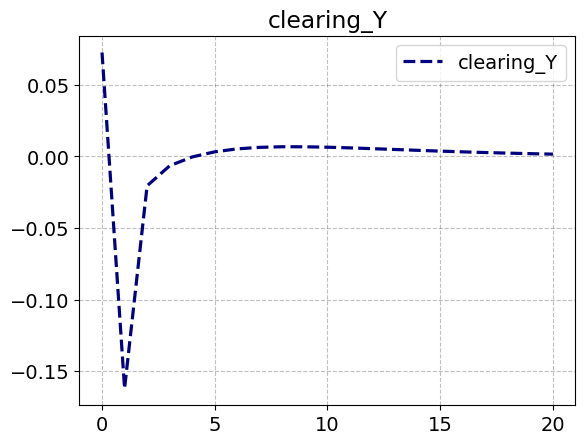

In [64]:
plt.plot(model_het.IRF['Y'][:21]-model_het.IRF['C_hh'][:21], label='clearing_Y', linestyle='--', linewidth=2.3, color='navy')
plt.title('clearing_Y')
plt.legend()
plt.show()

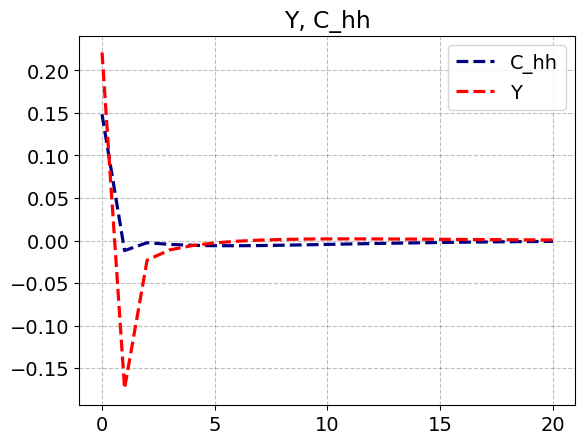

In [55]:
plt.plot(model_het_min.IRF['C_hh'][:21], label='C_hh', linestyle='--', linewidth=2.3, color='navy')
plt.plot(model_het_min.IRF['Y'][:21], label='Y', linestyle='--', linewidth=2.3, color='red')
plt.title('Y, C_hh')
plt.legend()
plt.show()

In [40]:
import re
import numpy as np

# ---------- Key canonicalizers ----------
def canon_out(name: str) -> str:
    """
    Map any variant like 'C_HH_hh', 'C_HH', 'c_hh', 'C', 'consumption_hh' -> 'C_hh'
    and 'A_HH_hh', 'A_HH', 'a_hh', 'A', 'assets_hh' -> 'A_hh'.
    """
    s = str(name).strip()
    s = s.replace('__','_')
    s_low = s.lower()

    # strip non-letters for robust matching
    s_letters = re.sub('[^a-z]', '', s_low)

    if s_letters.startswith('c'):
        return 'C_hh'
    if s_letters.startswith('a'):
        return 'A_hh'

    # fallbacks: look for tokens
    if ('c' in s_low) or ('cons' in s_low):
        return 'C_hh'
    if ('a' in s_low) or ('asset' in s_low):
        return 'A_hh'

    # last resort: raise so we notice unexpected names
    raise ValueError(f"Unrecognized HH output label: {name!r}")

def canon_in(name: str) -> str:
    """
    Canonicalize inputs to exactly 'Z' or 'ra' (tolerates variants).
    """
    s = str(name).strip().lower()
    if s.startswith('z'):
        return 'Z'
    if s == 'r' or s == 'ra' or s.startswith('ra'):
        return 'ra'
    # keep untouched if truly something else
    return name

def canon_pair_key(key):
    """Canonicalize a (OUT, IN) pair key."""
    out, inn = key
    return (canon_out(out), canon_in(inn))

def canon_triplet_key(key):
    """Canonicalize a ((OUT, IN), iz) key."""
    pair, iz = key
    return (canon_pair_key(pair), int(iz))

# ---------- Normalizer over model dicts ----------
def normalize_hh_keys(model, verbose=True):
    """
    Rewrites keys of model.jac_hh, model.jac_hh_by_z_stack, model.jac_hh_by_z
    to canonical forms; removes duplicates by letting later entries overwrite earlier.
    """
    if hasattr(model, 'jac_hh') and isinstance(model.jac_hh, dict):
        new = {}
        for k,v in list(model.jac_hh.items()):
            try:
                ck = canon_pair_key(k)
            except Exception as e:
                if verbose: print(f"[normalize] skip jac_hh key {k!r}: {e}")
                continue
            new[ck] = v
        model.jac_hh = new

    if hasattr(model, 'jac_hh_by_z_stack') and isinstance(model.jac_hh_by_z_stack, dict):
        new = {}
        for k,v in list(model.jac_hh_by_z_stack.items()):
            try:
                ck = canon_pair_key(k)
            except Exception as e:
                if verbose: print(f"[normalize] skip jac_hh_by_z_stack key {k!r}: {e}")
                continue
            new[ck] = v
        model.jac_hh_by_z_stack = new

    if hasattr(model, 'jac_hh_by_z') and isinstance(model.jac_hh_by_z, dict):
        new = {}
        for k,v in list(model.jac_hh_by_z.items()):
            try:
                ck = canon_triplet_key(k)
            except Exception as e:
                if verbose: print(f"[normalize] skip jac_hh_by_z key {k!r}: {e}")
                continue
            new[ck] = v
        model.jac_hh_by_z = new

    if verbose:
        print("Canonical keys present now:")
        if hasattr(model,'jac_hh'):
            print("  jac_hh keys:", sorted(model.jac_hh.keys()))
        if hasattr(model,'jac_hh_by_z_stack'):
            print("  jac_hh_by_z_stack keys:", sorted(model.jac_hh_by_z_stack.keys()))
        if hasattr(model,'jac_hh_by_z'):
            print("  sample jac_hh_by_z keys:",
                  list(model.jac_hh_by_z.keys())[:min(5,len(model.jac_hh_by_z))])

# ---------- Builder that only writes canonical keys ----------
def build_hh_jacs_per_z(
    model,
    E_by_z,                              # {'Z':[E_z], 'ra':[E_z]} cumulative (T,T) per z
    hh_outputs=('C_hh','A_hh'),
    hh_inputs=None,                      # defaults to model.inputs_hh_all
    shockname=None,                      # defaults to model.shocks[0]
    include_distribution=False,          # False => impact-only (matches decomp)
    normalize_before_store=True,
):
    """
    Creates BOTH aggregate and per-z HH Jacobians under heterogeneous expectations,
    and stores them under canonical keys only.
    """
    # optional: normalize any existing junk keys first
    if normalize_before_store:
        normalize_hh_keys(model, verbose=False)

    par, ss = model.par, model.ss
    T  = int(par.T); Nz = int(par.Nz); Nfix = int(par.Nfix)

    if shockname is None:
        if not getattr(model, 'shocks', None):
            raise RuntimeError("model.shocks empty; run find_IRFs() once so shocks list exists.")
        shockname = model.shocks[0]

    # canonicalize requested outputs and inputs
    outs_canon = [canon_out(O) for O in hh_outputs]
    inputs = list(hh_inputs) if hh_inputs is not None else list(model.inputs_hh_all)
    inputs_canon = [canon_in(x) for x in inputs]

    Dss = np.asarray(ss.D)  # (Nfix,Nz,Na)
    c_ss = getattr(ss, 'c', None)
    a_ss = getattr(ss, 'a', None)

    if not hasattr(model, 'jac_hh_by_z'):
        model.jac_hh_by_z = {}
    if not hasattr(model, 'jac_hh_by_z_stack'):
        model.jac_hh_by_z_stack = {}

    # forwarders only if you turn on distribution cumulation
    def _forward_endo(IRF_pols):
        from GEModelTools.simulate_hh import simulate_hh_forwards_endo_transpose
        i = np.ascontiguousarray(ss.pol_indices)
        w = np.ascontiguousarray(ss.pol_weights)
        A = IRF_pols[('a', shockname)]
        out = []
        for t in range(T):
            Dbeg_plus_t = np.ascontiguousarray(A[..., t])
            dD_t = simulate_hh_forwards_endo_transpose(Dbeg_plus_t, i, w)
            out.append(dD_t)
        return out

    def _forward_exo(dD_endo_T):
        from GEModelTools.simulate_hh import simulate_hh_forwards_exo_transpose
        zT = np.ascontiguousarray(getattr(ss, 'z_trans'))
        out = []
        for t in range(T):
            Dbeg_t = np.ascontiguousarray(dD_endo_T[t])
            out.append(simulate_hh_forwards_exo_transpose(Dbeg_t, zT))
        return out

    def _agg_level(level_arr, dD):
        if level_arr is None: return 0.0
        return float(np.sum(level_arr * dD))

    def _agg_level_by_z(level_arr, dD):
        if level_arr is None: return np.zeros(Nz)
        return np.sum(level_arr * dD, axis=(0,2))  # -> (Nz,)

    # policy name per output
    def out_to_pol(out: str) -> str:
        return 'c' if out == 'C_hh' else 'a'

    # ------------ main loop ------------
    for in_name_raw, in_name in zip(inputs, inputs_canon):

        # collectors
        F_agg = {Oc: np.zeros((T, T)) for Oc in outs_canon}
        F_z   = {Oc: np.zeros((Nz, T, T)) for Oc in outs_canon}

        # allocate container for policy IRFs once
        if 'pols' not in model.IRF:
            model.IRF['pols'] = {}
        for pol in model.outputs_hh:  # typically ['a','c']
            model.IRF['pols'][(pol, shockname)] = np.zeros((*Dss.shape, T))

        for s in range(T):
            e_s = np.zeros(T); e_s[s] = 1.0

            # perceived path per z (use canonical input name to lookup E_by_z)
            lookup = in_name if in_name in E_by_z else in_name_raw
            if (lookup in E_by_z) and (len(E_by_z[lookup]) == Nz):
                Pz = np.vstack([np.asarray(E_by_z[lookup][iz]) @ e_s for iz in range(Nz)])  # (Nz,T)
            else:
                Pz = np.tile(e_s, (Nz, 1))

            # convolve policies
            for pol in model.outputs_hh:
                d = model.dpols[(pol, in_name_raw)]                 # (T,Nfix,Nz,Na)
                IRFpol = model.IRF['pols'][(pol, shockname)]        # (Nfix,Nz,Na,T)
                for i_fix in range(Nfix):
                    for iz in range(Nz):
                        pz = Pz[iz]
                        for t in range(T):
                            IRFpol[i_fix, iz, :, t] = d[:T-t, i_fix, iz, :].T @ pz[t:]

            # impact columns
            for Oc in outs_canon:
                pol = out_to_pol(Oc)
                IRFpol = model.IRF['pols'][(pol, shockname)]
                # aggregate
                F_agg[Oc][:, s] = np.sum(IRFpol * Dss[..., None], axis=(0,1,2))
                # per-z
                F_z[Oc][:, :, s] = np.sum(IRFpol * Dss[..., None], axis=(0,2))  # (Nz,T)

            # add distribution rows if requested
            if include_distribution:
                dD_endo_T = _forward_endo(model.IRF['pols'])
                dD_T      = _forward_exo(dD_endo_T)
                for Oc in outs_canon:
                    level = c_ss if Oc == 'C_hh' else a_ss
                    if level is None: continue
                    for tau in range(1, T):
                        F_agg[Oc][tau, s]  += _agg_level(level, dD_T[tau-1])
                        F_z[Oc][:, tau, s] += _agg_level_by_z(level, dD_T[tau-1])

        # cumulation across columns if dist included
        for Oc in outs_canon:
            if include_distribution:
                Jagg = np.zeros_like(F_agg[Oc])
                Jagg[:, 0] = F_agg[Oc][:, 0]
                for s in range(1, T):
                    Jagg[:, s]  = F_agg[Oc][:, s]
                    Jagg[1:, s] += Jagg[:-1, s-1]
                Jz_stack = np.zeros_like(F_z[Oc])
                for iz in range(Nz):
                    Jz_stack[iz, :, 0] = F_z[Oc][iz, :, 0]
                    for s in range(1, T):
                        Jz_stack[iz, :, s]  = F_z[Oc][iz, :, s]
                        Jz_stack[iz, 1:, s] += Jz_stack[iz, :-1, s-1]
            else:
                Jagg = F_agg[Oc].copy()
                Jz_stack = F_z[Oc].copy()

            # -------- store with canonical keys only --------
            outkey = (Oc, in_name)       # e.g. ('C_hh','Z') or ('A_hh','ra')
            model.jac_hh[outkey] = Jagg
            model.jac_hh_by_z_stack[outkey] = Jz_stack
            for iz in range(Nz):
                model.jac_hh_by_z[(outkey, iz)] = Jz_stack[iz]

    # final pass to canonicalize anything that slipped through
    normalize_hh_keys(model, verbose=False)
    return model.jac_hh_by_z, model.jac_hh_by_z_stack


In [41]:
# 1) Canonicalize any existing keys (optional but helpful now)
normalize_hh_keys(model)

# 2) Build per-z kernels under your heterogeneous beliefs
E_by_z = {'Z': E_by_z_sane['Z'], 'ra': E_by_z_sane.get('ra', E_by_z_sane['Z'])}
jac_by_z, jac_by_z_stack = build_hh_jacs_per_z(
    model, E_by_z,
    hh_outputs=('C_hh','A_hh'),   # even if you typo these, they’ll be canonicalized
    include_distribution=False
)

# 3) Inspect the dictionary keys (should now be exactly ('C_hh','Z'), ('C_hh','ra'), etc.)
print(sorted(model.jac_hh.keys()))
print(sorted(model.jac_hh_by_z_stack.keys()))


Canonical keys present now:
  jac_hh keys: [('A_hh', 'Z'), ('A_hh', 'chi'), ('A_hh', 'ra'), ('C_hh', 'Z'), ('C_hh', 'chi'), ('C_hh', 'ra')]
[('A_hh', 'Z'), ('A_hh', 'chi'), ('A_hh', 'ra'), ('C_hh', 'Z'), ('C_hh', 'chi'), ('C_hh', 'ra')]
[('A_hh', 'Z'), ('A_hh', 'chi'), ('A_hh', 'ra'), ('C_hh', 'Z'), ('C_hh', 'chi'), ('C_hh', 'ra')]


In [42]:
# identity check (impact-only)
J_agg = model.jac_hh[('C_hh','Z')]
J_z   = model.jac_hh_by_z_stack[('C_hh','Z')]
assert np.allclose(J_agg, J_z.sum(axis=0), atol=1e-10)
print("OK: ∑_z per-z == aggregate for ('C_hh','Z').")

OK: ∑_z per-z == aggregate for ('C_hh','Z').


In [ ]:
import numpy as np

def list_jac_hh_by_z_stack(model_or_dict, as_csv=False, sep=','):
    """
    Print only the entry names in jac_hh_by_z_stack.
    model_or_dict: model with .jac_hh_by_z_stack or the dict itself.
    as_csv=True  -> prints like C_hh,Z
    as_csv=False -> prints the raw tuple keys
    """
    d = getattr(model_or_dict, 'jac_hh_by_z_stack', model_or_dict)
    if not isinstance(d, dict):
        print("jac_hh_by_z_stack missing or not a dict.")
        return
    keys = sorted(d.keys())
    print(f"{len(keys)} entries:")
    if as_csv:
        for o,i in keys:
            print(f"{o}{sep}{i}")
    else:
        for k in keys:
            print(k)

# Usage examples:
list_jac_hh_by_z_stack(model)              # tuple form
list_jac_hh_by_z_stack(model, as_csv=True) # A_hh,Z etc.

In [ ]:
import numpy as np

def show_jac_hh_by_z_stack(obj, keys=None, preview_z=2, preview=6, max_keys=None):
    """
    Print a concise summary of jac_hh_by_z_stack entries.
    obj  : model with .jac_hh_by_z_stack OR the dict itself
    keys : optional iterable of keys like ('C_hh','Z'), ('C_hh','ra'), ...
    preview_z : number of z-slices to preview per key
    preview   : top-left size (rows/cols) to print from each z-slice
    max_keys  : optional cap on number of keys to print
    """
    d = getattr(obj, 'jac_hh_by_z_stack', obj)
    if not isinstance(d, dict) or len(d) == 0:
        print("jac_hh_by_z_stack is missing or empty.")
        return

    all_keys = sorted(d.keys())
    sel_keys = all_keys if keys is None else [k for k in all_keys if k in set(keys)]
    if max_keys is not None:
        sel_keys = sel_keys[:max_keys]

    print(f"jac_hh_by_z_stack: {len(d)} entries; showing {len(sel_keys)}")
    for k in sel_keys:
        A = np.asarray(d[k])
        if A.ndim != 3:
            print(f"  {k}: unexpected shape {A.shape} (expected (Nz,T,T))")
            continue
        Nz, T1, T2 = A.shape
        finite = np.isfinite(A).all()
        amin, amax = float(np.nanmin(A)), float(np.nanmax(A))
        print(f"  {k}: shape=(Nz={Nz}, T={T1},{T2}), dtype={A.dtype}, finite={finite}, min={amin:.3g}, max={amax:.3g}")

        # choose a few z-slices to preview: first, middle, last
        z_idx = [0, Nz//2, Nz-1]
        z_idx = list(dict.fromkeys([z for z in z_idx if 0 <= z < Nz]))[:max(preview_z, 0)]

        r = min(preview, T1); c = min(preview, T2)
        for z in z_idx:
            print(f"    z={z}, top-left {r}x{c}:")
            with np.printoptions(precision=3, suppress=True):
                print(A[z, :r, :c])

show_jac_hh_by_z_stack(model.jac_hh_by_z_stack)

In [ ]:
import numpy as np

# --- tiny helpers to keep keys consistent (same as your aggregate solver expects) ---
def _canon_out(x):
    s = str(x).lower()
    return 'C_hh' if s.startswith('c') else ('A_hh' if s.startswith('a') else x)

def _canon_in(x):
    s = str(x).lower()
    if s.startswith('z'):  return 'Z'
    if s.startswith('ra') or s == 'r': return 'ra'
    return x

def _normalize_hh_keys_inplace(model):
    if hasattr(model, 'jac_hh') and isinstance(model.jac_hh, dict):
        model.jac_hh = {(_canon_out(o), _canon_in(i)): v for (o,i), v in model.jac_hh.items()}
    if hasattr(model, 'jac_hh_by_z_stack') and isinstance(model.jac_hh_by_z_stack, dict):
        model.jac_hh_by_z_stack = {(_canon_out(o), _canon_in(i)): v
                                   for (o,i), v in model.jac_hh_by_z_stack.items()}
    if hasattr(model, 'jac_hh_by_z') and isinstance(model.jac_hh_by_z, dict):
        model.jac_hh_by_z = {((_canon_out(o), _canon_in(i)), int(z)): v
                             for ((o,i), z), v in model.jac_hh_by_z.items()}

def _mirror_perz_attrs(dst, src):
    """Ensure the copy `dst` carries the per-z dicts made on `src` (since model.copy() may drop them)."""
    if (not hasattr(dst, 'jac_hh_by_z_stack')) and hasattr(src, 'jac_hh_by_z_stack'):
        dst.jac_hh_by_z_stack = {k: v.copy() for k, v in src.jac_hh_by_z_stack.items()}
    if (not hasattr(dst, 'jac_hh_by_z')) and hasattr(src, 'jac_hh_by_z'):
        dst.jac_hh_by_z = {k: v.copy() for k, v in src.jac_hh_by_z.items()}

def _identity_cumulative(T):
    """Lower-triangular ones (the FIRE identity for your cumulative operator)."""
    return np.tril(np.ones((T,T)))

# ======================= MINIMAL per-z solver (transform only) =======================
def solve_alt_exp_perz_minimal(model,
                               E_by_z,                 # {'Z':[E_z], 'ra':[E_z]} or one (T,T)
                               sticky_vars=('Z','ra'),
                               outs=('C_hh','A_hh'),
                               in_place=False,
                               assert_fire=False,
                               print_checks=True):
    """
    Minimal per-z expectations solver:
      - assumes model.jac_hh_by_z_stack[(OUT,IN)] already holds per-z FIRE kernels (Nz,T,T)
      - applies create_alt_M per z with your E_by_z
      - sums across z to refresh aggregate jac_hh[(OUT,IN)]
      - recomputes upper blocks (skip_hh=True) and IRFs

    Nothing else is touched. No dpols, no rebuilding, no reweighting.
    """
    ms = model if in_place else model.copy()
    _mirror_perz_attrs(ms, model)          # keep your per-z dicts if copy() dropped them
    _normalize_hh_keys_inplace(ms)

    T  = int(ms.par.T)
    Nz = int(ms.par.Nz)

    # basic guards
    need = [(_canon_out(o), _canon_in(i)) for o in outs for i in sticky_vars]
    if not hasattr(ms, 'jac_hh_by_z_stack'):
        raise KeyError("jac_hh_by_z_stack missing; build per-z FIRE stacks first.")
    for key in need:
        if key not in ms.jac_hh_by_z_stack:
            have = sorted(ms.jac_hh_by_z_stack.keys())
            raise KeyError(f"Per-z stack missing for {key}. Available: {have}")

    # normalize E input → list of Nz matrices per input
    def Ez_list(inp):
        inpC = _canon_in(inp)
        if isinstance(E_by_z, dict):
            L = E_by_z.get(inpC, E_by_z.get('Z', None))
            if L is None: raise KeyError(f"No E provided for input '{inpC}'.")
            if len(L) != Nz: raise ValueError(f"{inpC}: need {Nz} matrices, got {len(L)}.")
            return [np.asarray(E)[:T,:T] for E in L]
        else:
            Eh = np.asarray(E_by_z)
            if Eh.shape != (T,T):
                raise ValueError(f"Homogeneous E must be {(T,T)}, got {Eh.shape}.")
            return [Eh for _ in range(Nz)]

    # optional check: confirm stacks are FIRE by testing E=identity leaves them unchanged
    if assert_fire:
        E1 = _identity_cumulative(T)
        for key in need:
            Jz = np.asarray(ms.jac_hh_by_z_stack[key])  # (Nz,T,T)
            # test a couple of z slices (0 and last) to be quick
            for z in (0, Nz-1):
                J_test = create_alt_M(Jz[z], E1)
                if not np.allclose(J_test, Jz[z], atol=1e-10, rtol=1e-10):
                    raise AssertionError(
                        f"{key}, z={z}: per-z stack does not look like FIRE "
                        f"(create_alt_M with identity changed it)."
                    )

    # transform per z and refresh aggregates
    for o in outs:
        oC = _canon_out(o)
        for i in sticky_vars:
            iC = _canon_in(i)
            key = (oC, iC)

            Jz_fire = np.asarray(ms.jac_hh_by_z_stack[key])   # (Nz,T,T) — assumed FIRE
            Ez = Ez_list(iC)                                  # list of Nz (T,T)

            Jz_new = np.empty_like(Jz_fire)
            for z in range(Nz):
                Jz_new[z] = create_alt_M(Jz_fire[z], Ez[z])

            # write back per-z and aggregate
            ms.jac_hh_by_z_stack[key] = Jz_new
            if hasattr(ms, 'jac_hh_by_z'):
                for z in range(Nz):
                    ms.jac_hh_by_z[(key, z)] = Jz_new[z]
            ms.jac_hh[key] = Jz_new.sum(axis=0)

            if print_checks:
                ok = np.allclose(ms.jac_hh[key], Jz_new.sum(axis=0), atol=1e-10)
                print(f"{key}: Σ_z per-z == aggregate? {ok}")

    # refresh non-HH blocks & IRFs
    ms.compute_jacs(skip_hh=True, skip_shocks=False)
    ms.find_IRFs(shocks=getattr(ms, 'shocks', ['eps_i']), do_print=False)
    return ms


In [ ]:
# Heterogeneous expectations, cumulative (your E_by_z_sane)
E_by_z = {'Z': E_by_z_sane['Z'], 'ra': E_by_z_sane.get('ra', E_by_z_sane['Z'])}

# Make sure the stacks you have are FIRE; if unsure, set assert_fire=True to catch double-apply
model_het_min = solve_alt_exp_perz_minimal(
    model, E_by_z, sticky_vars=('Z','ra'), outs=('C_hh','A_hh'),
    in_place=False, assert_fire=True, print_checks=True
)


In [ ]:
# 1) Aggregate identity per key
for key in [('C_hh','Z'), ('C_hh','ra')]:
    agg_ok = np.allclose(model_het_min.jac_hh[key],
                         model_het_min.jac_hh_by_z_stack[key].sum(axis=0), atol=1e-10)
    print(key, "sum_z==agg?", agg_ok)

# 2) Aggregate vs your trusted decomp() path (should match up to plotting tolerance)
# decomp(model_het_min, ...)  # your trusted decomposition


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_C_components_perz(model, H=21, as_percent=True, save_prefix=None, show_total=True):
    """
    For each productivity level z, plot the decomposition of C_hh into
    contributions from Z and ra using the *current* per-z stacks:
        model.jac_hh_by_z_stack[('C_hh','Z')]  and  ...[('C_hh','ra')].

    Parameters
    ----------
    model : solved model with per-z stacks and IRFs populated
    H : int
        Horizon to display (truncated by model T).
    as_percent : bool
        If True, plot in % of steady-state C_hh.
    save_prefix : str or None
        If given, saves each plot as f"{save_prefix}_z{z}.png".
    show_total : bool
        If True, also plot (viaZ + viaRa) as a thin dashed line.

    Returns
    -------
    dict with arrays for further analysis:
      {
        'viaZ': (Nz,H),
        'viaRa': (Nz,H),
        'sum': (Nz,H),
        'H': H, 'Nz': Nz
      }
    """
    # Sizes and data
    T  = int(model.par.T)
    Nz = int(model.par.Nz)
    H  = min(int(H), T)

    # Per-z effective kernels
    KzZ = np.asarray(model.jac_hh_by_z_stack[('C_hh','Z')])[:, :H, :H]   # (Nz,H,H)
    Kzr = np.asarray(model.jac_hh_by_z_stack[('C_hh','ra')])[:, :H, :H]  # (Nz,H,H)

    # Realized input paths (levels)
    Z_path  = np.asarray(model.IRF['Z'])[:H]   # (H,)
    ra_path = np.asarray(model.IRF['ra'])[:H]  # (H,)

    # Contributions by z
    CzZ = np.einsum('zts,s->zt', KzZ, Z_path)     # (Nz,H)
    CzR = np.einsum('zts,s->zt', Kzr, ra_path)    # (Nz,H)
    CzS = CzZ + CzR

    # Optional scaling to % of steady-state C
    if as_percent:
        denom = float(model.ss.C_hh)
        scale = 100.0 / denom
        CzZ = CzZ * scale
        CzR = CzR * scale
        CzS = CzS * scale
        ylab = "ΔC (percent of steady state)"
    else:
        ylab = "ΔC (levels)"

    # Plot per z
    x = np.arange(H)                       # 0..H-1
    tick_positions = x                     # positions
    tick_labels    = [str(i+1) for i in x] # labels 1..H (no decimals)

    for z in range(Nz):
        fig, ax = plt.subplots(figsize=(7.2, 4.2))
        ax.plot(x, CzZ[z, :], label="via Z", linewidth=2)
        ax.plot(x, CzR[z, :], label="via ra", linewidth=2)
        if show_total:
            ax.plot(x, CzS[z, :], '--', label="sum (via Z + via ra)", linewidth=1.5)

        ax.set_title(f"C decomposition by z (z = {z})")
        ax.set_xlabel("Horizon")
        ax.set_ylabel(ylab)
        ax.grid(True, alpha=0.3)
        # integer ticks only, labeled 1..H
        ax.set_xticks(tick_positions)
        ax.set_xticklabels(tick_labels)
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        ax.legend()

        if save_prefix:
            fig.tight_layout()
            fig.savefig(f"{save_prefix}_z{z}.png", dpi=150, bbox_inches='tight')
        plt.show()

    return {'viaZ': CzZ, 'viaRa': CzR, 'sum': CzS, 'H': H, 'Nz': Nz}


In [ ]:
# After you’ve applied your E_by_z (so the stacks reflect your beliefs)
out = plot_C_components_perz(model_het_simple, H=21, as_percent=True, save_prefix=None)


In [ ]:
# Your heterogeneous beliefs (unchanged)
E_by_z = {'Z': E_by_z_sane['Z'], 'ra': E_by_z_sane.get('ra', E_by_z_sane['Z'])}

# Transform existing per-z stacks and update aggregates (no rebuilding, no dpols)
model_het_simple = apply_E_perz_transform_only(
    model,
    E_by_z,
    sticky_vars=('Z','ra'),
    outs=('C_hh','A_hh'),
    in_place=False
)


In [ ]:
import numpy as np

# compat: normalize with/without 'verbose'
def _normalize_keys_safe(model):
    try:
        normalize_hh_keys(model, verbose=False)
    except TypeError:
        normalize_hh_keys(model)

def _identity_E_by_z(T, Nz, inputs=('Z','ra')):
    E1 = np.tril(np.ones((T,T)))
    return {inp: [E1.copy() for _ in range(Nz)] for inp in inputs}

def _canon_out(x):
    x = str(x).lower()
    return 'C_hh' if x.startswith('c') else ('A_hh' if x.startswith('a') else x)

def _canon_in(x):
    s = str(x).lower()
    if s.startswith('z'):  return 'Z'
    if s.startswith('ra') or s == 'r': return 'ra'
    return x

def apply_E_perz_on_existing_stacks(model,
                                    E_by_z,                      # {'Z':[E_z], 'ra':[E_z]} or one (T,T)
                                    sticky_vars=('Z','ra'),
                                    outs=('C_hh','A_hh'),
                                    rebuild_fire=False,          # rebuild per-z FIRE before applying new E
                                    in_place=False,
                                    do_print=True):
    """
    Transform existing per-z stacks (model.jac_hh_by_z_stack[(OUT,IN)]) with create_alt_M,
    then sum to aggregates. If rebuild_fire=True, rebuild per-z FIRE stacks first using
    identity expectations via your build_hh_jacs_per_z(...).
    """
    ms = model if in_place else model.copy()
    T  = int(ms.par.T); Nz = int(ms.par.Nz)

    # 0) normalize keys up front
    _normalize_keys_safe(ms)

    # 1) optionally rebuild per-z stacks to FIRE first (identity E) using your builder
    if rebuild_fire:
        E_id = _identity_E_by_z(T, Nz, inputs=sticky_vars)
        _normalize_keys_safe(ms)
        # Call builder in a way that's compatible with either signature
        try:
            _ = build_hh_jacs_per_z(ms, E_id,
                                    hh_outputs=outs, hh_inputs=sticky_vars,
                                    include_distribution=False,
                                    normalize_before_store=False)   # <-- avoid verbose call
        except TypeError:
            # older builder without 'normalize_before_store'
            _ = build_hh_jacs_per_z(ms, E_id,
                                    hh_outputs=outs, hh_inputs=sticky_vars,
                                    include_distribution=False)

        _normalize_keys_safe(ms)

    # 2) guard: do we have stacks?
    need = [(_canon_out(o), _canon_in(i)) for o in outs for i in sticky_vars]
    if not hasattr(ms, 'jac_hh_by_z_stack'):
        raise KeyError("ms.jac_hh_by_z_stack is missing. Build per-z stacks first.")
    missing = [k for k in need if k not in ms.jac_hh_by_z_stack]
    if missing:
        have = sorted(ms.jac_hh_by_z_stack.keys())
        raise KeyError(f"Per-z stacks missing for {missing}. Available keys: {have}")

    # 3) normalize E input to list-of-Nz per input
    def Ez_list(varname):
        varname = _canon_in(varname)
        if isinstance(E_by_z, dict):
            L = E_by_z.get(varname, E_by_z.get('Z', None))
            if L is None: raise KeyError(f"No E provided for input '{varname}'")
            if len(L) != Nz: raise ValueError(f"{varname}: need {Nz} matrices, got {len(L)}")
            return [np.asarray(E)[:T,:T] for E in L]
        else:
            Eh = np.asarray(E_by_z)
            if Eh.shape != (T,T):
                raise ValueError(f"Homogeneous E must be {(T,T)}, got {Eh.shape}")
            return [Eh for _ in range(Nz)]

    # 4) apply per-z transform and sum
    n_upd = 0
    for o in outs:
        oC = _canon_out(o)
        for i in sticky_vars:
            iC = _canon_in(i)
            key = (oC, iC)
            Jz_fire = np.asarray(ms.jac_hh_by_z_stack[key])   # (Nz,T,T)
            Ez = Ez_list(iC)
            Jz_new = np.empty_like(Jz_fire)
            for z in range(Nz):
                Jz_new[z] = create_alt_M(Jz_fire[z], Ez[z])   # your original function
            # write back
            ms.jac_hh_by_z_stack[key] = Jz_new
            if hasattr(ms, 'jac_hh_by_z'):
                for z in range(Nz):
                    ms.jac_hh_by_z[(key, z)] = Jz_new[z]
            ms.jac_hh[key] = Jz_new.sum(axis=0)
            n_upd += 1

    if do_print:
        print(f"Applied alternative expectations to {n_upd} HH kernels (per-z transform).")
        for key in need:
            ok = np.allclose(ms.jac_hh[key], ms.jac_hh_by_z_stack[key].sum(axis=0), atol=1e-10)
            print(f"  {key}: Σ_z per-z == aggregate? {ok}")

    # 5) refresh upper blocks & IRFs
    ms.compute_jacs(skip_hh=True, skip_shocks=False)
    ms.find_IRFs(shocks=getattr(ms, 'shocks', ['eps_i']), do_print=False)
    return ms




In [ ]:
model_het_simple = apply_E_perz_on_existing_stacks(
    model,
    E_by_z={'Z': E_by_z_sane['Z'], 'ra': E_by_z_sane.get('ra', E_by_z_sane['Z'])},
    sticky_vars=('Z','ra'),
    outs=('C_hh','A_hh'),
    rebuild_fire=True,   # important if your existing per-z stacks already had beliefs baked in
    in_place=False
)


In [ ]:
print("STACK KEYS:", sorted(model.jac_hh_by_z_stack.keys()))


In [ ]:
E_by_z = {'Z': E_by_z_sane['Z'], 'ra': E_by_z_sane.get('ra', E_by_z_sane['Z'])}

# This will NOT rebuild any HH Jacobians. It only transforms the already-stored per-z stacks.
model_het_simple = apply_E_perz_on_existing_stacks(
    model, E_by_z, sticky_vars=('Z','ra'), outs=('C_hh','A_hh'), in_place=False
)


In [ ]:
# ----------------------------
# Ensure per-z kernels exist, then apply per-z expectations
# ----------------------------
import numpy as np

def _identity_E_by_z(T, Nz, inputs=('Z','ra')):
    """Lower-triangular ones (full info at/after s, no anticipation) per z."""
    E1 = np.tril(np.ones((T,T)))
    return {inp: [E1.copy() for _ in range(Nz)] for inp in inputs}

def ensure_perz_kernels(model, inputs=('Z','ra'), outs=('C_hh','A_hh'),
                        E_by_z=None, include_distribution=False):
    """
    If model.jac_hh_by_z_stack[(OUT,IN)] is missing, (re)build per-z HH kernels.
    Requires that model.dpols is populated (run compute_jacs(skip_hh=False, ...) once on baseline).
    """
    # do we already have per-z stacks for all needed keys?
    need = [(o,i) for o in outs for i in inputs]
    have_all = hasattr(model, 'jac_hh_by_z_stack') and all(
        k in model.jac_hh_by_z_stack for k in need
    )
    if have_all:
        return  # nothing to do

    # we need to build them (impact-only by default)
    # if no E_by_z was given, use identity (full-info) per z
    T  = int(model.par.T)
    Nz = int(model.par.Nz)
    if E_by_z is None:
        E_by_z = _identity_E_by_z(T, Nz, inputs=inputs)

    # --- minimal builder (impact-only) ---
    # uses dpols and ss.D to construct per-z impact kernels; no distribution cumulation
    if not hasattr(model, 'jac_hh_by_z_stack'):
        model.jac_hh_by_z_stack = {}
    if not hasattr(model, 'jac_hh_by_z'):
        model.jac_hh_by_z = {}

    Dss   = np.asarray(model.ss.D)  # (Nfix,Nz,Na)
    Nfix  = int(model.par.Nfix)
    pol_of = {'C_hh':'c','A_hh':'a'}

    if 'pols' not in model.IRF:
        model.IRF['pols'] = {}
    shockname = model.shocks[0] if getattr(model,'shocks',None) else 'eps_i'

    for o in outs:
        pol = pol_of[o]
        for i in inputs:
            # prepare containers
            Kz = np.zeros((Nz, T, T))
            # loop columns (news dates)
            for s in range(T):
                e_s = np.zeros(T); e_s[s] = 1.0
                # perceived path by z for input i
                Pz = np.vstack([np.asarray(E_by_z[i][iz]) @ e_s for iz in range(Nz)])  # (Nz,T)
                # compute policy IRFs on the asset grid
                IRFpol = np.zeros((*Dss.shape, T))  # (Nfix,Nz,Na,T)
                d = self.dpols[(pol, i)]           # (T,Nfix,Nz,Na)
                for f in range(Nfix):
                    for iz in range(Nz):
                        pz = Pz[iz]
                        for t in range(T):
                            IRFpol[f, iz, :, t] = d[:T-t, f, iz, :].T @ pz[t:]
                # aggregate by z (impact rows)
                y0_z = np.sum(IRFpol * Dss[..., None], axis=(0,2))  # (Nz,T)
                # store into the s-th column
                Kz[:, :, s] = y0_z
            # write per-z stack and aggregate
            model.jac_hh_by_z_stack[(o,i)] = Kz
            for iz in range(Nz):
                model.jac_hh_by_z[((o,i), iz)] = Kz[iz]
            model.jac_hh[(o,i)] = Kz.sum(axis=0)

def solve_alt_exp_perz(model,
                       E_or_Ebyz,
                       sticky_vars=('Z','ra'),
                       outs=('C_hh','A_hh'),
                       update_perz=True,
                       do_print=True):
    """
    Apply alternative expectations per z directly to HH Jacobians.
    Requires per-z stacks; builds them on the fly if missing (with identity beliefs).
    """
    model_sticky = model.copy()
    T  = int(model_sticky.par.T)
    Nz = int(model_sticky.par.Nz)

    # Make sure per-z stacks exist (build with identity beliefs if absent)
    ensure_perz_kernels(model_sticky, inputs=sticky_vars, outs=outs, E_by_z=None)

    # normalize expectations input
    hetero = isinstance(E_or_Ebyz, dict)
    if hetero:
        def Ez_list(varname):
            if varname in E_or_Ebyz:
                L = E_or_Ebyz[varname]
            else:
                L = E_or_Ebyz.get('Z', None)
                if L is None:
                    raise KeyError(f"No expectations provided for input '{varname}'")
            if len(L) != Nz:
                raise ValueError(f"{varname}: need {Nz} matrices, got {len(L)}")
            return [np.asarray(E)[:T,:T] for E in L]
    else:
        E_h = np.asarray(E_or_Ebyz)
        if E_h.shape != (T,T):
            raise ValueError(f"Homogeneous E must be {(T,T)}, got {E_h.shape}")
        def Ez_list(_): return [E_h for _ in range(Nz)]

    # apply E to each z-slice, sum back to aggregate
    n_updated = 0
    for o in outs:
        for i in sticky_vars:
            key = (o,i)
            if key not in model_sticky.jac_hh_by_z_stack:
                raise KeyError(f"Per-z stack missing for {key} even after ensure_perz_kernels.")
            Jz = np.asarray(model_sticky.jac_hh_by_z_stack[key])   # (Nz,T,T)
            Ez = Ez_list(i)
            Jz_new = np.empty_like(Jz)
            for z in range(Nz):
                Jz_new[z] = create_alt_M(Jz[z], Ez[z])             # your njit kernel
            if update_perz:
                model_sticky.jac_hh_by_z_stack[key] = Jz_new
                if hasattr(model_sticky, 'jac_hh_by_z'):
                    for z in range(Nz):
                        model_sticky.jac_hh_by_z[(key, z)] = Jz_new[z]
            model_sticky.jac_hh[key] = Jz_new.sum(axis=0)
            n_updated += 1

    if do_print:
        mode_txt = "heterogeneous (per-z)" if hetero else "homogeneous"
        print(f"Applied alternative expectations to {n_updated} HH kernels — {mode_txt}.")
        for o in outs:
            for i in sticky_vars:
                k=(o,i)
                ok = np.allclose(model_sticky.jac_hh[k],
                                 model_sticky.jac_hh_by_z_stack[k].sum(axis=0),
                                 atol=1e-10)
                print(f"  {k}: ∑_z per-z == aggregate? {ok}")

    # refresh upper blocks & IRFs
    model_sticky.compute_jacs(skip_hh=True, skip_shocks=False)
    model_sticky.find_IRFs(shocks=getattr(model_sticky, 'shocks', ['eps_i']), do_print=False)
    return model_sticky


In [ ]:
model.compute_jacs(skip_hh=False, skip_shocks=False, do_print=False)

# Heterogeneous expectations (per z)
E_by_z = {'Z': E_by_z_sane['Z'], 'ra': E_by_z_sane.get('ra', E_by_z_sane['Z'])}

# Solve with per-z update (keeps A_hh and C_hh consistent)
model_het2 = solve_alt_exp_perz(model, E_by_z, sticky_vars=('Z','ra'))

# Or homogeneous expectations matrix for everyone
# model_homo = solve_alt_exp_perz(model_base, E_homo, sticky_vars=('Z','ra'))


In [ ]:
K_perz = {
    ('C_hh','Z'):  model.jac_hh_by_z_stack[('C_hh','Z')],
    ('C_hh','ra'): model.jac_hh_by_z_stack[('C_hh','ra')],
}
res_true = decompose_C_by_z_consistent(
    model=model_het, K_perz=K_perz, H=21,
    enforce_identity=True, return_percent=True
)
plot_perz_and_aggregate_decomp(res_true, H=21)


In [ ]:
def bump_stats(res):
    # sum contribution per z (percent)
    S = res['per_z']['sum_pct']  # (Nz,T)
    peak_mag = S.min(axis=1)     # most negative value (assuming your shock makes C drop)
    peak_t   = S.argmin(axis=1) + 1  # +1 because your x-axis starts at 1
    return peak_mag, peak_t

peak_mag, peak_t = bump_stats(res)
for z, (m, t) in enumerate(zip(peak_mag, peak_t)):
    print(f"z={z}: peak ΔC = {m:.3f}% at t={t}")


In [ ]:
import numpy as np

def ra_share_by_z(res, t=3):
    t_idx = min(max(t,1), res['T']) - 1
    viaZ  = res['per_z']['viaZ_pct'][:, t_idx]
    viaRa = res['per_z']['viaRa_pct'][:, t_idx]
    denom = viaZ + viaRa
    with np.errstate(divide='ignore', invalid='ignore'):
        share = np.where(np.abs(denom) > 1e-14, viaRa/denom, np.nan)
    return share

for t in (2, 3, 5, 10):
    s = ra_share_by_z(res, t=t)
    print(f"t={t}: ra-share by z =", np.round(s, 3))


In [ ]:
import numpy as np

def show_E_by_z(E_by_z, preview=6, max_items=6):
    # Handles dict -> (list/dict/array), or a single matrix/array
    print("E_by_z type:", type(E_by_z))
    if hasattr(E_by_z, "items"):
        print("keys:", list(E_by_z.keys()))
        for key, mats in E_by_z.items():
            print(f"\nE_by_z['{key}']:")
            # normalize to iterable of matrices
            if isinstance(mats, dict):
                items = list(mats.items())
            else:
                try:
                    items = list(enumerate(mats))
                except TypeError:
                    items = [(0, mats)]
            for j, (idx, M) in enumerate(items):
                A = np.asarray(M)
                print(f"  [{idx}] shape={A.shape}, dtype={A.dtype}", end="")
                if A.ndim == 2:
                    finite = np.isfinite(A).all()
                    print(f", finite={finite}")
                    r = min(preview, A.shape[0]); c = min(preview, A.shape[1])
                    print(A[:r, :c])
                else:
                    print("")
                if j+1 >= max_items:
                    print("  ... (truncated)")
                    break
    else:
        A = np.asarray(E_by_z)
        print("Single value shape:", A.shape, "dtype:", A.dtype)
        if A.ndim == 2:
            r = min(preview, A.shape[0]); c = min(preview, A.shape[1])
            print(A[:r, :c])

# Usage
show_E_by_z(E_by_z_sane, preview=6, max_items=6)

In [15]:
import numpy as np

# --- core: sanitize ONE cumulative E (T,T) ---
def _sanitize_cumulative_E_single(E):
    """
    Input E: cumulative expectations matrix (T,T) that may violate [0,1] / monotonicity.
    Output:   E_san of the same shape with:
              - for each column s: E_san[t,s] is nondecreasing in t, in [0,1], with E_san[s,s]=1
              - pre-entries t<s kept (clipped to [0,1])
    """
    E = np.asarray(E, dtype=float)
    T = E.shape[0]
    E_san = np.zeros_like(E)

    for s in range(T):
        col = E[:, s].copy()

        # 1) handle pre-announcement part (t < s)
        pre = np.clip(col[:s], 0.0, 1.0)  # keep and clip to [0,1]
        E_san[:s, s] = pre

        # 2) ensure diagonal is 1 (fully known at t=s)
        base = max(0.0, min(1.0, col[s])) if s < T else 1.0
        if base == 0.0:
            base = 1.0
        E_san[s, s] = 1.0

        # 3) incremental "news weights" for t >= s:
        #    raw increments ΔE_raw[t] = E[t,s] - E[t-1,s]; then clip negatives; renormalize to sum=1
        #    finally re-cumulate to enforce bounded monotone cumulative ≤ 1
        # construct raw increments on t>=s
        inc = np.zeros(T - s)
        inc[0] = 1.0                             # force E_san[s,s] = 1
        if s + 1 < T:
            raw = np.diff(col[s:s+1+(T-s-1)], prepend=col[s])  # zeros, but explicit
            # Better: compute from original (we already set inc[0]=1). For t>s:
            raw = col[s:(T)] - np.r_[col[s], col[s:(T-1)]]
            raw[0] = 1.0  # override to ensure diag=1
            # clip negatives
            raw = np.maximum(raw, 0.0)
            # if sum(raw) == 0, fall back to a point mass at t=s already (we set raw[0]=1)
            if raw.sum() == 0.0:
                inc[:] = 0.0
                inc[0] = 1.0
            else:
                # renormalize to sum 1
                inc = raw / raw.sum()
        # re-cumulate to get a proper bounded cumulative on t>=s
        post_cum = np.cumsum(inc)
        post_cum = np.clip(post_cum, 0.0, 1.0)

        # write back (ensuring t=s matches 1.0)
        E_san[s:, s] = post_cum

    # final clip for numerical safety
    np.clip(E_san, 0.0, 1.0, out=E_san)
    return E_san

# --- helpers to accept many shapes for per-z collections ---
def _ensure_TxT(E, T):
    E = np.asarray(E)
    if E.ndim != 2: raise ValueError(f"E must be 2D, got {E.shape}")
    if E.shape[0] < T or E.shape[1] < T: raise ValueError(f"E too small: {E.shape} < ({T},{T})")
    if E.shape != (T, T): E = E[:T, :T]
    return E

def _iter_perz(perz, Nz, T):
    """Yield per-z matrices from many input formats, returning a list of (T,T)."""
    out = []
    if isinstance(perz, dict):
        if len(perz) != Nz:
            raise ValueError(f"per-z dict has {len(perz)} entries but Nz={Nz}.")
        for k in perz.keys():
            out.append(_ensure_TxT(perz[k], T))
        return out
    arr = np.asarray(perz, dtype=object)
    if arr.ndim == 3:
        if arr.shape[0] == Nz:
            return [_ensure_TxT(arr[z], T) for z in range(Nz)]
        if arr.shape[-1] == Nz:
            return [_ensure_TxT(arr[:, :, z], T) for z in range(Nz)]
        raise ValueError(f"3D per-z has incompatible shape {arr.shape}.")
    if arr.ndim == 2:
        E = _ensure_TxT(arr, T)
        return [E for _ in range(Nz)]
    if arr.ndim == 1:
        # If you passed lambdas (length Nz), build bounded cumulative form <= 1
        if arr.size != Nz:
            raise ValueError(f"lambda vector length {arr.size} != Nz={Nz}.")
        mats = []
        for lam in arr:
            lam = float(lam)
            # bounded sticky-like cumulative for t>=s:
            # pre-announcement set to 0 here; change if you want leakage
            E = np.zeros((T, T))
            for s in range(T):
                E[s, s] = 1.0
                for t in range(s+1, T):
                    h = t - s
                    E[t, s] = 1.0 - (1.0 - lam) ** (h+1)
            mats.append(E)
        return mats
    raise ValueError(f"Unsupported per-z spec with shape {arr.shape}.")

# --- top-level: sanitize E_by_z in any of the forms we used earlier ---
def sanitize_E_by_z(E_by_z, T, Nz):
    """
    Accepts:
      - dict {'Z': perzZ, 'ra': perzR}, where perzZ/perzR can be dict/list/array of (T_full,T_full) or lambdas
      - OR a single per-z collection (applied to both channels upstream if you reuse)
    Returns a structure with the same top-level form, but with each per-z matrix sanitized to be a proper cumulative CDF.
    """
    # If it's the two-channel dict, sanitize each channel separately
    if isinstance(E_by_z, dict) and set(E_by_z.keys()) >= {'Z', 'ra'}:
        out = {}
        for key in ['Z', 'ra']:
            perz = _iter_perz(E_by_z[key], Nz, T)  # list of (T,T)
            out[key] = [ _sanitize_cumulative_E_single(Ez) for Ez in perz ]
        return out
    # Otherwise treat as a single per-z collection
    perz = _iter_perz(E_by_z, Nz, T)
    return [ _sanitize_cumulative_E_single(Ez) for Ez in perz ]


In [ ]:
# Suppose your model_het has par.T, par.Nz
T = int(model_het.par.T)
Nz = int(model_het.par.Nz)

# 1) Sanitize once
E_by_z_sane = sanitize_E_by_z(E_by_z, T=T, Nz=Nz)

# 2) Feed into the decomposition (works because it accepts dict {'Z','ra'} with per-z lists):
decompose_and_plot_C_by_z(
    model_het, kind='hetero',
    E_by_z=E_by_z_sane,
    #which_for_hetero='Z',  # choose which channel’s E to use if your function needs one stack;
                           # for the C decomposition I wrote, this is fine since it builds per-z channels with KCZ,KCr separately
    H=21, normalize_pct=True,
    title_prefix="Heterogeneous (sanitized E)"
)


In [ ]:
print(E_sticky)

In [ ]:
def E_per_z_sticky_style(T, lam):
    E = np.zeros((T, T))
    if lam == 1.0:
        pre = np.arange(1, T+1, dtype=float)
    else:
        tau = np.arange(T, dtype=float)
        pre = lam * (1.0 - lam**(tau + 1)) / (1.0 - lam)
    for s in range(T):
        E[:s+1, s] = pre[:s+1]
        E[s:,   s] = 1.0
    return E

def build_E_by_z_from_lambda_sticky_post(T, lambda_by_z, inputs=('Z','ra')):
    mats = [E_per_z_sticky_style(T, float(lam)) for lam in lambda_by_z]
    return {i: [M.copy() for M in mats] for i in inputs}

lambda_by_z = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
E_by_z = build_E_by_z_from_lambda_sticky_post(model.par.T, lambda_by_z, inputs=('Z','ra'))

model_het = solve_alt_exp(model, E_by_z, sticky_vars=('Z','ra'))
res_het = decomp_per_z_C(model_het, E_spec=E_by_z, inputs=('Z','ra'), H=21,
                         title='Heterogeneous per-z — C decomposition')


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ---------- helpers ----------
def _z_weights_from_ss(model):
    D = model.ss.D  # (Nfix, Nz, Na)
    w0 = np.sum(D, axis=(0,2))
    w0 = w0 / np.sum(w0)
    return w0

def _find_markov_P(model, Nz):
    for name in ['Pi','P','pi_z','Pz','Pi_z','PiZ','P_Z']:
        if hasattr(model.par, name):
            P = np.asarray(getattr(model.par, name))
            if P.ndim == 2 and P.shape == (Nz, Nz) and np.allclose(P.sum(axis=1), 1.0):
                return P
    return None

def _weight_history(w0, P, T):
    if P is None:
        W = np.tile(w0, (T, 1))  # constant weights
        return W
    W = np.zeros((T, w0.size))
    w = w0.copy()
    for t in range(T):
        W[t] = w
        w = w @ P
    return W

def _Wz_matrix(W_hist, T, iz):
    # W_z[tau,s] = weight for group z at calendar time (s - tau)
    Wz = np.zeros((T, T))
    for s in range(T):
        for tau in range(s+1):
            Wz[tau, s] = W_hist[s - tau, iz]
    return Wz

def _normalize_E_spec(E_spec, T, Nz, inputs=('Z','ra')):
    # None -> FIRE (=ones); (T,T) -> copy per-z; dict -> pass-through
    def _E_fire(T): return np.ones((T, T))
    if E_spec is None:
        Ez = [_E_fire(T) for _ in range(Nz)]
        return {i: [E.copy() for E in Ez] for i in inputs}
    if isinstance(E_spec, dict):
        out = {}
        for i in inputs:
            mats = E_spec[i]
            assert len(mats) == Nz, f"E_spec['{i}'] must have length {Nz}"
            out[i] = [np.asarray(M) for M in mats]
        return out
    E = np.asarray(E_spec); assert E.shape == (T, T)
    return {i: [E.copy() for _ in range(Nz)] for i in inputs}

# ---------- main ----------
def decomp_per_z_C(model_like,
                   E_spec=None,
                   inputs=('Z','ra'),
                   H=21,
                   title='per-z C decomposition',
                   mode='rebuild',
                   tol=5e-11,
                   plot_test=False):
    """
    Decompose C_hh into per-z contributions from 'inputs' (default: ('Z','ra')).

    Modes:
      - 'rebuild'  : J_z = create_alt_M(M_FIRE, E_z ⊙ W_z)  (uses model_like.jac_hh_fire if present)
      - 'allocate' : split the *in-use* HH Jacobian M_USE elementwise across z by W_z weights
                     (identity-preserving: Σ_z contrib_z == C_hh(model))

    If mode='rebuild' but add-up error > tol, the function auto-runs 'allocate' for plotting.

    Returns a dict with both rebuild and allocate results (when available).
    """
    T  = int(model_like.par.T)
    Nz = int(model_like.par.Nz)
    H  = min(H, T)

    # inputs & IRFs
    x = {i: model_like.IRF[i][:T] for i in inputs}
    C_path = model_like.IRF['C_hh'][:T]
    C_ss = float(model_like.ss.C_hh)

    # z weights and calendars
    w0 = _z_weights_from_ss(model_like)
    P  = _find_markov_P(model_like, Nz)
    W_hist = _weight_history(w0, P, T)
    Wz_by_z = [ _Wz_matrix(W_hist, T, iz) for iz in range(Nz) ]

    # normalize E_spec
    E_by_z = _normalize_E_spec(E_spec, T, Nz, inputs=inputs)

    # choose FIRE Jacobians (preferred) or fallback to in-use
    use_fire = hasattr(model_like, 'jac_hh_fire')
    J_fire = model_like.jac_hh_fire if use_fire else model_like.jac_hh
    J_use  = model_like.jac_hh  # in-use (whatever the model solved with)

    # ---------- REBUILD path ----------
    contrib_rebuild = {i: np.zeros((Nz, T)) for i in inputs}
    total_rebuild = np.zeros(T)

    if mode in ('rebuild','both'):
        for i in inputs:
            M_fire = J_fire[('C_hh', i)]
            for iz in range(Nz):
                E = E_by_z[i][iz]
                Wz = Wz_by_z[iz]
                Jz = create_alt_M(M_fire, E * Wz)  # per-z Jacobian (rebuild)
                contrib_rebuild[i][iz,:] = Jz @ x[i]
            total_rebuild += contrib_rebuild[i].sum(axis=0)

    add_err = float('nan') if mode not in ('rebuild','both') else float(np.max(np.abs(total_rebuild - C_path)))

    # ---------- ALLOCATE path (identity-preserving) ----------
    contrib_alloc = {i: np.zeros((Nz, T)) for i in inputs}
    total_alloc = np.zeros(T)

    if (mode == 'allocate') or (mode == 'rebuild' and not np.isfinite(add_err)) or (mode == 'rebuild' and add_err > tol):
        for i in inputs:
            M_use = J_use[('C_hh', i)]  # already transformed HH map in the model
            # split each (t,s) cell across z by W_z[tau,s], tau=s-t
            # do it by building Jz = M_use ⊙ Wz and applying to x[i]
            for iz in range(Nz):
                Jz = Wz_by_z[iz] * M_use
                contrib_alloc[i][iz,:] = Jz @ x[i]
            total_alloc += contrib_alloc[i].sum(axis=0)

    # ---- choose what to plot ----
    plot_source = 'rebuild'
    if mode == 'allocate' or (mode == 'rebuild' and add_err > tol):
        plot_source = 'allocate'

    if plot_source == 'rebuild':
        per_input_z = contrib_rebuild
        total = total_rebuild
    else:
        per_input_z = contrib_alloc
        total = total_alloc

    # convert to % of C_ss
    def to_pct(a): return a / C_ss * 100.0
    per_input_z_pct = {i: to_pct(per_input_z[i]) for i in inputs}
    total_pct = to_pct(total)
    C_pct = to_pct(C_path)
    sum_per_z_pct = np.zeros((Nz, T))
    for i in inputs:
        sum_per_z_pct += per_input_z_pct[i]
    sum_by_input_pct = {i: per_input_z_pct[i].sum(axis=0) for i in inputs}

    # report identity errors
    if plot_source == 'rebuild':
        print(f"[rebuild] max |Σ_z Σ_inputs − C_hh(model)| = {add_err:.3e}")
    else:
        add_err_alloc = float(np.max(np.abs(total_alloc - C_path)))
        print(f"[allocate] max |Σ_z Σ_inputs − C_hh(model)| = {add_err_alloc:.3e}")

    # ---------- plotting ----------
    n_rows, n_cols = 4, 2
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(11, 12), sharex=True)
    axes = axes.ravel()
    colors = ['navy', 'firebrick', 'forestgreen', 'orange']
    lw = 2.0

    for iz in range(Nz):
        ax = axes[iz]
        for j, i in enumerate(inputs):
            ax.plot(per_input_z_pct[i][iz, :H], label=f'via {i}', linewidth=lw, color=colors[1+j])
        ax.plot(sum_per_z_pct[iz, :H], label='sum (Z+ra)', ls='--', lw=lw+0.4, color=colors[0])
        ax.axhline(0, color='black', lw=0.8)
        ax.set_title(f'z = {iz}')
        ax.legend(fontsize=8, ncol=2)
        ax.grid(True, alpha=0.25)

    ax = axes[6]
    for j, i in enumerate(inputs):
        ax.plot(sum_by_input_pct[i][:H], label=f'Σ_z via {i}', lw=lw, color=colors[1+j])
    ax.plot(total_pct[:H], label='Σ_z (Z+ra)', lw=lw+0.6, color=colors[0])
    ax.plot(C_pct[:H], label='C_hh (model)', ls='--', lw=lw, color='gray')
    ax.axhline(0, color='black', lw=0.8)
    ax.set_title('Aggregate')
    ax.legend(fontsize=9, ncol=2)
    ax.grid(True, alpha=0.25)

    axes[7].axis('off')
    fig.suptitle(f"{title} • mode: {plot_source}", fontsize=14, y=0.98)
    axes[6].set_xlabel('Quarters'); axes[-2].set_xlabel('Quarters')
    plt.tight_layout(rect=[0,0,1,0.965]); plt.show()

    return {
        'mode_plotted': plot_source,
        'inputs': inputs,
        'per_input_z_pct': per_input_z_pct,   # dict: input -> (Nz,T)
        'sum_per_z_pct': sum_per_z_pct,       # (Nz,T)
        'sum_by_input_pct': sum_by_input_pct, # dict: input -> (T,)
        'total_pct': total_pct,               # (T,)
        'C_pct': C_pct,                       # (T,)
        'add_err_rebuild': None if 'rebuild' not in locals() else add_err,
    }


In [ ]:
decomp_per_z_C(model, E_spec=None, title='Baseline (FIRE)', mode='rebuild')


In [ ]:
E = E_sticky_exp(theta=0.935, T=model.par.T)
res_sticky = decomp_per_z_C(model_sticky, E_spec=E, title='Sticky (hom)')


In [ ]:
res_het = decomp_per_z_C(model_het, E_spec=E_by_z, title='Heterogeneous per-z')


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ---- helpers ----
def _z_weights_from_ss(model):
    D = model.ss.D  # (Nfix, Nz, Na)
    w0 = np.sum(D, axis=(0,2))
    w0 = w0 / np.sum(w0)
    return w0

def _find_markov_P(model, Nz):
    for name in ['Pi','P','pi_z','Pz','Pi_z','PiZ','P_Z']:
        if hasattr(model.par, name):
            P = np.asarray(getattr(model.par, name))
            if P.ndim == 2 and P.shape == (Nz, Nz) and np.allclose(P.sum(axis=1), 1.0):
                return P
    return None

def _weight_history(w0, P, T):
    if P is None:
        return np.tile(w0, (T,1))  # constant by time
    W = np.zeros((T, w0.size))
    w = w0.copy()
    for t in range(T):
        W[t] = w
        w = w @ P
    return W

def _normalize_E_spec(E_spec, T, Nz, inputs=('Z','ra')):
    def _E_fire(T): return np.ones((T,T))
    if E_spec is None:
        Ez = [_E_fire(T) for _ in range(Nz)]
        return {i: [E.copy() for E in Ez] for i in inputs}
    if isinstance(E_spec, dict):
        out = {}
        for i in inputs:
            mats = E_spec[i]
            assert len(mats) == Nz, f"E_spec['{i}'] must have length {Nz}"
            out[i] = [np.asarray(M) for M in mats]
        return out
    E = np.asarray(E_spec); assert E.shape == (T,T)
    return {i: [E.copy() for _ in range(Nz)] for i in inputs}

# ---- main ----
def decomp_per_z_C(model_like,
                   E_spec=None,
                   inputs=('Z','ra'),
                   H=21,
                   title='per-z C_hh decomposition',
                   mode='allocate',            # <-- default to the stable exact-add split
                   alloc_timing='col',         # 'col' = W[s,z]; 'row' = W[t,z]; 'tau' = W[s-t,z]
                   tol=5e-11):
    """
    Decompose C_hh into per-z contributions via the specified inputs.

    mode:
      - 'rebuild' : J_z = create_alt_M(M_FIRE, E_z ⊙ W_z) using jac_hh_fire if available
      - 'allocate': exact-add column-weight split of the *in-use* HH Jacobian (default)

    alloc_timing (only for 'allocate'):
      - 'col' : W_z[t,s] = W[s,z]  (recommended; shock-date weights)
      - 'row' : W_z[t,s] = W[t,z]
      - 'tau' : W_z[t,s] = W[s-t,z]
    """
    T  = int(model_like.par.T)
    Nz = int(model_like.par.Nz)
    H  = min(H, T)

    x = {i: model_like.IRF[i][:T] for i in inputs}
    C_path = model_like.IRF['C_hh'][:T]
    C_ss   = float(model_like.ss.C_hh)

    w0     = _z_weights_from_ss(model_like)
    P      = _find_markov_P(model_like, Nz)
    W_hist = _weight_history(w0, P, T)

    E_by_z = _normalize_E_spec(E_spec, T, Nz, inputs=inputs)

    use_fire = hasattr(model_like, 'jac_hh_fire')
    J_fire   = model_like.jac_hh_fire if use_fire else model_like.jac_hh
    J_use    = model_like.jac_hh

    # ---- REBUILD (optional) ----
    contrib_rebuild = {i: np.zeros((Nz, T)) for i in inputs}
    total_rebuild   = np.zeros(T)
    add_err_rebuild = np.nan
    if mode == 'rebuild':
        for i in inputs:
            M_fire = J_fire[('C_hh', i)]
            for iz in range(Nz):
                # weights by timing; default 'col' (shock-date)
                if alloc_timing == 'row':
                    Wz = np.zeros((T,T)); 
                    for s in range(T): Wz[:s+1,s] = W_hist[:s+1, iz]  # W[t,z]
                elif alloc_timing == 'tau':
                    Wz = np.zeros((T,T)); 
                    for s in range(T):
                        for t in range(s+1):
                            Wz[t,s] = W_hist[s-t, iz]                    # W[s-t,z]
                else: # 'col'
                    Wz = np.zeros((T,T)); 
                    for s in range(T): Wz[:s+1,s] = W_hist[s, iz]       # W[s,z]
                Jz = create_alt_M(M_fire, E_by_z[i][iz] * Wz)
                contrib_rebuild[i][iz,:] = Jz @ x[i]
            total_rebuild += contrib_rebuild[i].sum(axis=0)
        add_err_rebuild = float(np.max(np.abs(total_rebuild - C_path)))
        print(f"[rebuild] max |Σ_z Σ_inputs − C_hh(model)| = {add_err_rebuild:.3e}")

    # ---- ALLOCATE (exact-add) ----
    contrib_alloc = {i: np.zeros((Nz, T)) for i in inputs}
    total_alloc   = np.zeros(T)
    if (mode == 'allocate') or (mode == 'rebuild' and add_err_rebuild > tol):
        for i in inputs:
            M_use = J_use[('C_hh', i)]  # already-in-use mapping in the model
            for iz in range(Nz):
                if alloc_timing == 'row':
                    # W_z[t,s] = W[t,z]
                    Wz = np.zeros((T,T)); 
                    for s in range(T): Wz[:s+1,s] = W_hist[:s+1, iz]
                elif alloc_timing == 'tau':
                    # W_z[t,s] = W[s-t,z]
                    Wz = np.zeros((T,T)); 
                    for s in range(T):
                        for t in range(s+1):
                            Wz[t,s] = W_hist[s-t, iz]
                else:
                    # 'col': W_z[t,s] = W[s,z]   <-- recommended
                    Wz = np.zeros((T,T)); 
                    for s in range(T): Wz[:s+1,s] = W_hist[s, iz]
                Jz = Wz * M_use
                contrib_alloc[i][iz,:] = Jz @ x[i]
            total_alloc += contrib_alloc[i].sum(axis=0)
        add_err_alloc = float(np.max(np.abs(total_alloc - C_path)))
        print(f"[allocate] max |Σ_z Σ_inputs − C_hh(model)| = {add_err_alloc:.3e}")

    # pick what to plot
    if mode == 'rebuild' and add_err_rebuild <= tol:
        per_input_z = contrib_rebuild
        total = total_rebuild
        plotted_mode = 'rebuild'
    else:
        per_input_z = contrib_alloc
        total = total_alloc
        plotted_mode = 'allocate'

    # to percentages
    def pct(a): return a / C_ss * 100.0
    per_input_z_pct = {i: pct(per_input_z[i]) for i in inputs}
    total_pct       = pct(total)
    C_pct           = pct(C_path)
    sum_per_z_pct   = np.zeros((Nz, T))
    for i in inputs:
        sum_per_z_pct += per_input_z_pct[i]
    sum_by_input_pct = {i: per_input_z_pct[i].sum(axis=0) for i in inputs}

    # ---- plotting ----
    n_rows, n_cols = 4, 2
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(11,12), sharex=True)
    axes = axes.ravel()
    colors = ['navy','firebrick','forestgreen','orange']; lw=2.0

    for iz in range(Nz):
        ax = axes[iz]
        for j,i in enumerate(inputs):
            ax.plot(per_input_z_pct[i][iz, :H], label=f'via {i}', lw=lw, color=colors[1+j])
        ax.plot(sum_per_z_pct[iz, :H], label='sum (Z+ra)', ls='--', lw=lw+0.4, color=colors[0])
        ax.axhline(0, color='black', lw=0.8)
        ax.set_title(f'z = {iz}')
        ax.legend(fontsize=8, ncol=2)
        ax.grid(True, alpha=0.25)

    ax = axes[6]
    for j,i in enumerate(inputs):
        ax.plot(sum_by_input_pct[i][:H], label=f'Σ_z via {i}', lw=lw, color=colors[1+j])
    ax.plot(total_pct[:H], label='Σ_z (Z+ra)', lw=lw+0.6, color=colors[0])
    ax.plot(C_pct[:H],   label='C_hh (model)', ls='--', lw=lw, color='gray')
    ax.axhline(0, color='black', lw=0.8)
    ax.set_title('Aggregate')
    ax.legend(fontsize=9, ncol=2)
    ax.grid(True, alpha=0.25)

    axes[7].axis('off')
    fig.suptitle(f"{title} • mode: {plotted_mode}, alloc={alloc_timing}", fontsize=14, y=0.98)
    axes[6].set_xlabel('Quarters'); axes[-2].set_xlabel('Quarters')
    plt.tight_layout(rect=[0,0,1,0.965]); plt.show()

    return {
        'mode_plotted': plotted_mode,
        'alloc_timing': alloc_timing,
        'per_input_z_pct': per_input_z_pct,
        'sum_per_z_pct': sum_per_z_pct,
        'sum_by_input_pct': sum_by_input_pct,
        'total_pct': total_pct,
        'C_pct': C_pct
    }


In [ ]:
res_base = decomp_per_z_C(
    model_like = model,
    E_spec     = None,              # FIRE
    inputs     = ('Z','ra'),
    H          = 21,
    title      = 'Baseline (FIRE)',
    mode       = 'rebuild'          # rebuild is fine for FIRE
)


In [76]:
# sticky matrix you already use
E_sticky = E_sticky_exp(theta=0.935, T=model.par.T)

In [75]:
# sticky matrix you already use
E_sticky = E_sticky_exp(theta=0.935, T=model.par.T)

# (assuming you already solved model_sticky with E_sticky)
res_sticky = decomp_per_z_C(
    model_like = model_sticky,
    E_spec     = E_sticky,          # (T,T) homogeneous E
    inputs     = ('Z','ra'),
    H          = 21,
    title      = 'Sticky (hom)',
    mode       = 'allocate',        # exact identity on aggregate
    alloc_timing = 'col'            # W[s,z] split (recommended)
)


NameError: name 'decomp_per_z_C' is not defined

In [ ]:
def E_per_z_sticky_style(T, lam):
    E = np.zeros((T, T))
    if lam == 1.0:
        pre = np.arange(1, T+1, dtype=float)
    else:
        tau = np.arange(T, dtype=float)
        pre = lam * (1.0 - lam**(tau + 1)) / (1.0 - lam)  # cumulative pre-s
    for s in range(T):
        E[:s+1, s] = pre[:s+1]
        E[s:,   s] = 1.0                                  # full info post-s
    return E

def build_E_by_z_from_lambda_sticky_post(T, lambda_by_z, inputs=('Z','ra')):
    mats = [E_per_z_sticky_style(T, float(l)) for l in lambda_by_z]
    return {i: [M.copy() for M in mats] for i in inputs}

lambda_by_z = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
E_by_z = build_E_by_z_from_lambda_sticky_post(model.par.T, lambda_by_z, inputs=('Z','ra'))

# (assuming you already solved model_het with E_by_z)
res_het = decomp_per_z_C(
    model_like   = model_het,
    E_spec       = E_by_z,          # dict {'Z':[Ez0..], 'ra':[Ez0..]}
    inputs       = ('Z','ra'),
    H            = 21,
    title        = 'Heterogeneous per-z',
    mode         = 'allocate',      # exact identity on aggregate
    alloc_timing = 'col'            # W[s,z] split
)


In [ ]:
plt.plot((m.IRF['Y'])[:101], label='clearing_Y'); plt.legend(); plt.show()

In [ ]:
lambda_by_z = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]           # low→high productivity
E_by_z = {
    'Z':  [E_from_lambda_cumulative(model.par.T, lam) for lam in lambda_by_z],
    'ra': [E_from_lambda_cumulative(model.par.T, lam) for lam in lambda_by_z],
}
model_het = solve_alt_exp(model, E_by_z, sticky_vars=('Z','ra'))

In [ ]:
import numpy as np

def _format_matrix_1dec(A):
    A = np.asarray(A)
    if A.ndim != 2:
        return np.array2string(np.round(A, 1), precision=1, suppress_small=True, max_line_width=10**6)
    rows = ["[" + " ".join(f"{x:.1f}" for x in row) + "]" for row in A]
    return "[\n  " + "\n  ".join(rows) + "\n]"

def dump_E_by_z(E_by_z, name="E_by_z_test", to_file=None):
    if not hasattr(E_by_z, "items"):
        print(f"{name} is not a dict-like object.")
        return
    parts = []
    for key, mats in E_by_z.items():
        parts.append(f"\n{name}['{key}'] — {len(mats)} matrix/matrices")
        for iz, M in enumerate(mats):
            A = np.asarray(M)
            parts.append(f"  [{iz}] shape={A.shape}")
            parts.append(_format_matrix_1dec(A))
    text = "\n".join(parts)
    if to_file:
        with open(to_file, "w", encoding="utf-8") as f:
            f.write(text)
        print(f"Wrote full dump to {to_file}")
    else:
        print(text)

# Use either print to cell or write to file
dump_E_by_z(E_by_z, name="E_by_z_test")                     # print everything
# dump_E_by_z(E_by_z_test, name="E_by_z_test", to_file="E_by_z_test_dump.txt")  # or save to file

In [ ]:
print(E_sticky)

In [ ]:
model_het.draw_DAG(figsize=(10,10))

In [ ]:
model_het.find_ss(); model_het.compute_jacs(do_print=False)

In [ ]:
# in your steady-state routine (after a_ss is found)
import numpy as np
a_grid = np.asarray(model_het.par.a_grid, dtype=float)        # (Na,)
z_grid = np.asarray(model_het.par.z_grid, dtype=float)        # (Nz,)
a_state = np.broadcast_to(a_grid[None,None,:], model_het.ss.D.shape)  # (Nfix,Nz,Na)
z_state = np.broadcast_to(z_grid[None,:,None], model_het.ss.D.shape)

# exactly the same identity as in household_problem.py
model_het.ss.c = (1.0 + float(model_het.ss.ra))*a_state + float(model_het.ss.Z)*z_state - float(model_het.ss.chi) - np.asarray(model_het.ss.a, dtype=float)


In [ ]:
# where you prepare model.dpols (same shapes as your ('a',•) kernels): (T, Nfix, Nz, Na)
T = model_het.par.T
Nfix, Nz, Na = model_het.ss.D.shape
a_state = np.broadcast_to(np.asarray(model_het.par.a_grid)[None,None,:], (Nfix,Nz,Na))
z_state = np.broadcast_to(np.asarray(model_het.par.z_grid)[None,:,None], (1,Nz,1)).repeat(Nfix,0).repeat(Na,2)

for i_name in ('ra','Z','chi'):
    model_het.dpols.setdefault(('C_hh', i_name), np.zeros((T, Nfix, Nz, Na)))

# impact at t (row 0): a*Δr + z*ΔZ − Δχ
model_het.dpols[('C_hh','ra')][0] += a_state
model_het.dpols[('C_hh','Z')][0]  += z_state
model_het.dpols[('C_hh','chi')][0] += -1.0

# for any input j that also moves a′, include the -Δa′ channel:
for j in ('ra','Z','chi'):
    if ('a', j) in model_het.dpols:
        model_het.dpols[('C_hh', j)] += - np.asarray(model_het.dpols[('a', j)], dtype=float)


In [ ]:
jac_hh_alt = rebuild_jac_hh_hetero_fakenews(
    model_het, E_by_z,
    hh_outputs=('C_hh','A_hh'),
    forward_endo=None,
    forward_exo=None
    # no forward_endo/exo => impact-only
)

In [ ]:
model_het.jac_hh.update(jac_hh_alt)
model_het.compute_jacs(skip_hh=True, do_print=False)

In [ ]:
model_het.find_IRFs(shocks=['eps_i'], reuse_G_U=False, do_print=False)

In [ ]:
plt.plot(model_het.IRF['Y'][:21]-model_het.IRF['C_hh'][:21], label='clearing_Y', linestyle='--', linewidth=2.3, color='navy')
plt.title('clearing_Y')
plt.legend()
plt.show()

In [ ]:
plt.plot(model_het.IRF['pD'][:21]+model_het.IRF['B'][:21]-model_het.IRF['A_hh'][:21], label='Y', linestyle='--', linewidth=2.3, color='navy')
plt.title('A_hh, C_hh and Y')
plt.legend()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def _get_irf(IRF, var, shock_key=None):
    """
    Return a 1D array for the IRF of `var`.
    Tries several layouts:
      • IRF[var]                                  (no shock key)
      • IRF[(var, shock_key)]
      • IRF[var][shock_key]
      • IRF[shock_key][var]
      • IRF[f"{var}_{shock_key}"]
    """
    # 0) simplest: IRF[var]
    try:
        arr = IRF[var]
        return np.asarray(arr).ravel()
    except Exception:
        pass

    if shock_key is None:
        raise KeyError(f"IRF for {var} not found and no shock_key provided.")

    # 1) tuple key
    try:
        return np.asarray(IRF[(var, shock_key)]).ravel()
    except Exception:
        pass
    # 2) nested var->shock
    try:
        return np.asarray(IRF[var][shock_key]).ravel()
    except Exception:
        pass
    # 3) nested shock->var
    try:
        return np.asarray(IRF[shock_key][var]).ravel()
    except Exception:
        pass
    # 4) flat "var_shock"
    try:
        return np.asarray(IRF[f"{var}_{shock_key}"]).ravel()
    except Exception:
        pass

    raise KeyError(f"Could not find IRF for ({var}, {shock_key}).")

def show_clearing_Y(model, shock_key="eps_i", T=None, title_suffix=""):
    IRF = model.IRF

    # try to get clearing_Y directly; if missing, compute Y - C_hh as proxy
    try:
        clearing = _get_irf(IRF, "clearing_Y", shock_key=None)
    except Exception:
        try:
            clearing = _get_irf(IRF, "clearing_Y", shock_key=shock_key)
        except Exception:
            # fallback: implied goods wedge
            Y   = _get_irf(IRF, "Y", shock_key=None)
            C   = _get_irf(IRF, "C_hh", shock_key=None)
            clearing = np.asarray(Y).ravel() - np.asarray(C).ravel()

    if T is None:
        T = len(clearing)
    t = np.arange(T)

    # print a few diagnostics
    print(f"clearing_Y (first 10, shock={shock_key}):")
    print(np.round(clearing[:10], 6))
    print(f"\nSummary over T={T}:")
    print(f"  max |clearing_Y| = {np.max(np.abs(clearing[:T])):.6e}")
    print(f"  mean clearing_Y  = {np.mean(clearing[:T]):.6e}")
    print(f"  last value       = {clearing[T-1]:.6e}")

    # plot
    plt.figure(figsize=(8, 4.5))
    plt.axhline(0, linewidth=1)
    plt.plot(t, clearing[:T], label="clearing_Y (stored or implied)")
    plt.xlabel("quarters")
    plt.ylabel("deviation (IRF units)")
    ttl = "clearing_Y after shock"
    if title_suffix:
        ttl += f" — {title_suffix}"
    plt.title(ttl)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Usage:
# show_clearing_Y(model_het, shock_key="eps_i", T=40, title_suffix="model_het")

In [ ]:
show_clearing_Y(model_het, shock_key="eps_i", T=40, title_suffix="model")

In [ ]:
# Hetero-beliefs version (also 6 states)
model_het_test_low = HANKModelClass(name='hank_het6')
model_het_test_low.find_ss()
model_het_test_low._compute_jac_hh()
model_het_test_low.calc_MPC()
model_het_test_low.compute_jacs(do_print=False)

# 0) solve once
model_het_test_low.find_ss(); model_het_test_low.compute_jacs(do_print=False)

jac_hh_alt_low = rebuild_jac_hh_hetero_fakenews(
    model_het_test_low, E_by_z_test_same_low,
    hh_outputs=('C_hh','A_hh'),
    # no forward_endo/exo => impact-only
)

model_het_test_low.jac_hh.update(jac_hh_alt_low)
model_het_test_low.compute_jacs(skip_hh=True, do_print=False)

model_het_test_low.find_IRFs(shocks=['eps_i'], reuse_G_U=False, do_print=False)

show_clearing_Y(model_het_test_low, shock_key="eps_i", T=40, title_suffix="model")

In [ ]:
# Hetero-beliefs version (also 6 states)
model_het_test_mid = HANKModelClass(name='hank_het6')
model_het_test_mid.find_ss()
model_het_test_mid._compute_jac_hh()
model_het_test_mid.calc_MPC()
model_het_test_mid.compute_jacs(do_print=False)

# 0) solve once
model_het_test_mid.find_ss(); model_het_test_mid.compute_jacs(do_print=False)

jac_hh_alt_mid = rebuild_jac_hh_hetero_fakenews(
    model_het_test_mid, E_by_z_test_same_mid,
    hh_outputs=('C_hh','A_hh'),
    # no forward_endo/exo => impact-only
)

model_het_test_mid.jac_hh.update(jac_hh_alt_mid)
model_het_test_mid.compute_jacs(skip_hh=True, do_print=False)

model_het_test_mid.find_IRFs(shocks=['eps_i'], reuse_G_U=False, do_print=False)

show_clearing_Y(model_het_test_mid, shock_key="eps_i", T=40, title_suffix="model")

In [ ]:
# Hetero-beliefs version (also 6 states)
model_het_test_high = HANKModelClass(name='hank_het6')
model_het_test_high.find_ss()
model_het_test_high._compute_jac_hh()
model_het_test_high.calc_MPC()
model_het_test_high.compute_jacs(do_print=False)

# 0) solve once
model_het_test_high.find_ss(); model_het_test_high.compute_jacs(do_print=False)

jac_hh_alt_high = rebuild_jac_hh_hetero_fakenews(
    model_het_test_high, E_by_z_test_same_high,
    hh_outputs=('C_hh','A_hh'),
    # no forward_endo/exo => impact-only
)

model_het_test_high.jac_hh.update(jac_hh_alt_high)
model_het_test_high.compute_jacs(skip_hh=True, do_print=False)

model_het_test_high.find_IRFs(shocks=['eps_i'], reuse_G_U=False, do_print=False)

show_clearing_Y(model_het_test_high, shock_key="eps_i", T=40, title_suffix="model")

In [ ]:
# Hetero-beliefs version (also 6 states)
model_het_test_rational = HANKModelClass(name='hank_het6')
model_het_test_rational.find_ss()
model_het_test_rational._compute_jac_hh()
model_het_test_rational.calc_MPC()
model_het_test_rational.compute_jacs(do_print=False)

# 0) solve once
model_het_test_rational.find_ss(); model_het_test_rational.compute_jacs(do_print=False)

jac_hh_alt_rational = rebuild_jac_hh_hetero_fakenews(
    model_het_test_rational, E_by_z_test_same_rational,
    hh_outputs=('C_hh','A_hh'),
    # no forward_endo/exo => impact-only
)

model_het_test_rational.jac_hh.update(jac_hh_alt_rational)
model_het_test_rational.compute_jacs(skip_hh=True, do_print=False)

model_het_test_rational.find_IRFs(shocks=['eps_i'], reuse_G_U=False, do_print=False)

show_clearing_Y(model_het_test_rational, shock_key="eps_i", T=40, title_suffix="model")

In [ ]:
show_clearing_Y(model, shock_key="eps_i", T=40, title_suffix="model")

In [ ]:
def rebuild_jac_hh_hetero_fakenews_with_z(
    model,
    E_by_z: dict,
    hh_outputs=('C_hh','A_hh'),
    hh_inputs=None,
    shockname=None,
    forward_endo=None,   # optional: forward_endo(IRF_pols, ss, par) -> list of ΔD_t (Nfix,Nz,Na)
    forward_exo=None,    # optional: forward_exo(dD_endo_T, ss, par) -> list of ΔD_t (Nfix,Nz,Na)
):
    """
    Rebuild T×T household Jacobians under per-z beliefs, and ALSO store
    per-productivity Jacobians.

    Writes:
      - model.jac_hh[(OUT, IN)]                     -> (T,T) aggregate
      - model.jac_hh_by_z[((OUT, IN), iz)]          -> (T,T) for each z
      - model.jac_hh_by_z_stack[(OUT, IN)]          -> (Nz,T,T) stacked by ascending z_grid
      - model.jac_hh_meta['z_order']                -> sorting index for z_grid

    Notes
    -----
    • If forward_endo/exo are provided, the “fake-news” distribution term is added
      before cumulation across columns (same logic as your fakenews builder).
    • Keys for IN must exist in model.dpols[(pol, IN)] for each output’s policy pol.
    """

    par, ss = model.par, model.ss
    T, Nz, Nfix = par.T, par.Nz, par.Nfix
    Dss = ss.D                        # (Nfix, Nz, Na)
    c_ss = getattr(ss, 'c', None)     # (Nfix, Nz, Na) or None
    a_ss = getattr(ss, 'a', None)

    # shock name
    if shockname is None:
        if not getattr(model, 'shocks', None):
            raise RuntimeError("model.shocks is empty; run find_IRFs() once to initialize IRF store.")
        shockname = model.shocks[0]

    # inputs to build for
    inputs = list(hh_inputs) if hh_inputs is not None else list(model.inputs_hh_all)

    # map HH output name -> policy symbol used in dpols / IRF['pols']
    pol_for_out = {'C_hh': 'c', 'A_hh': 'a'}

    # resolve OUT keys to match model storage (case-insensitive safety)
    def _resolve_hh_outkey(want):
        want_low = want.lower()
        for (o,_i) in getattr(model, 'jac_hh', {}).keys():
            if isinstance(o,str) and o.lower() == want_low: return o
        for o in getattr(model,'outputs_hh',[]):
            if isinstance(o,str) and o.lower() == want_low: return o
        return want
    OUTKEY = {O: _resolve_hh_outkey(O) for O in hh_outputs}

    # ensure IRF['pols'] exists
    if 'pols' not in model.IRF:
        model.IRF['pols'] = {}

    # helper: build policy IRFs for ONE input path (1D) applying per-z beliefs
    def _build_pols_perceived_paths(i_name, path_1d):
        # zero-init for this shock and for each HH policy
        for pol in model.outputs_hh:
            model.IRF['pols'][(pol, shockname)] = np.zeros((*Dss.shape, T))
        # perceived path per z
        if i_name in E_by_z:
            Pz = np.vstack([E_by_z[i_name][iz] @ path_1d for iz in range(Nz)])  # (Nz, T)
        else:
            Pz = np.tile(path_1d, (Nz, 1))
        # convolve with dpols
        for pol in model.outputs_hh:
            key = (pol, i_name)
            if key not in model.dpols:
                raise KeyError(f"Missing kernel dpols{key}")
            d = model.dpols[key]                                 # (T, Nfix, Nz, Na)
            IRFpol = model.IRF['pols'][(pol, shockname)]         # (Nfix, Nz, Na, T)
            for i_fix in range(Nfix):
                for iz in range(Nz):
                    pz = Pz[iz]
                    for t in range(T):
                        IRFpol[i_fix, iz, :, t] = d[:T-t, i_fix, iz, :].T @ pz[t:]

    # inner products for distribution term
    def _agg_level(level_arr, dD):
        if level_arr is None: return 0.0
        return float(np.sum(level_arr * dD))

    # per-z inner product
    def _agg_level_by_z(level_arr, dD):
        # returns (Nz,) with <level[:,:,iz,:], dD[:,:,iz,:]>
        if level_arr is None:
            return np.zeros(Nz)
        return np.sum(level_arr * dD, axis=(0,2))  # sum over (i_fix, a)

    jac_alt_agg = {}                   # aggregate J’s to (also) install on model.jac_hh
    jac_hh_by_z = {}                   # per-z dict: key ((OUT, IN), iz) -> (T,T)
    jac_hh_by_z_stack = {}             # per OUT,IN -> stacked (Nz,T,T)

    # ---------- main: loop inputs ----------
    for i_name in inputs:

        # F matrices BEFORE fake-news cumulation (impact + optional distribution rows)
        F_by_O_agg = {O: np.zeros((T, T)) for O in hh_outputs}
        F_by_O_z   = {O: np.zeros((Nz, T, T)) for O in hh_outputs}  # [iz, t, s]

        for s in range(T):
            # basis column
            e_s = np.zeros(T); e_s[s] = 1.0

            # policies (perceived) for this input + column s
            _build_pols_perceived_paths(i_name, e_s)

            # impact pieces (aggregate and by-z)
            for O in hh_outputs:
                pol = pol_for_out[O]
                IRFpol = model.IRF['pols'][(pol, shockname)]  # (Nfix, Nz, Na, T)

                # aggregate impact column (t = 0..T-1)
                y0_vec = np.sum(IRFpol * Dss[..., None], axis=(0,1,2))    # (T,)
                F_by_O_agg[O][:, s] = y0_vec

                # per-z impact columns
                # y0_vec_z[iz,t] = sum_{i_fix,a} IRFpol[i_fix,iz,:,t] * Dss[i_fix,iz,:]
                y0_z = np.sum(IRFpol * Dss[..., None], axis=(0,2))        # (Nz, T)
                F_by_O_z[O][:, :, s] = y0_z                               # (Nz,T) -> (Nz,T,s)

            # distribution term (optional)
            if (forward_endo is not None) and (forward_exo is not None):
                dD_endo_T = forward_endo(model.IRF['pols'], ss, par)  # list length T, each (Nfix,Nz,Na)
                dD_T      = forward_exo(dD_endo_T, ss, par)           # same

                for O in hh_outputs:
                    level = c_ss if O == 'C_hh' else a_ss if O == 'A_hh' else None
                    if level is None: 
                        continue
                    # aggregate rows τ>=1
                    for tau in range(1, T):
                        F_by_O_agg[O][tau, s] += _agg_level(level, dD_T[tau-1])
                    # per-z rows τ>=1
                    for tau in range(1, T):
                        add_z = _agg_level_by_z(level, dD_T[tau-1])   # (Nz,)
                        F_by_O_z[O][:, tau, s] += add_z

        # fake-news cumulation across columns → final Jacobians
        for O in hh_outputs:
            # aggregate
            F = F_by_O_agg[O]
            if (forward_endo is None) or (forward_exo is None):
                Jagg = F.copy()
            else:
                Jagg = np.zeros_like(F)
                Jagg[:, 0] = F[:, 0]
                for s in range(1, T):
                    Jagg[:, s]  = F[:, s]
                    Jagg[1:, s] += Jagg[:-1, s-1]
            jac_alt_agg[(OUTKEY[O], i_name)] = Jagg

            # per-z (do the SAME cumulation independently for each iz)
            Fz = F_by_O_z[O]                      # (Nz,T,T)
            Jz_stack = np.zeros_like(Fz)          # (Nz,T,T)
            if (forward_endo is None) or (forward_exo is None):
                Jz_stack[:] = Fz
            else:
                for iz in range(Nz):
                    Jz_stack[iz,:,0] = Fz[iz,:,0]
                    for s in range(1, T):
                        Jz_stack[iz,:,s]  = Fz[iz,:,s]
                        Jz_stack[iz,1:,s] += Jz_stack[iz,:-1,s-1]

            # store by individual z and as a stacked, z-sorted array
            z_order = np.argsort(par.z_grid)
            Jz_sorted = Jz_stack[z_order,:,:]
            for rank, iz in enumerate(z_order):
                jac_hh_by_z[((OUTKEY[O], i_name), iz)] = Jz_stack[iz].copy()
            jac_hh_by_z_stack[(OUTKEY[O], i_name)] = Jz_sorted

    # install on the model
    if not hasattr(model, 'jac_hh'): model.jac_hh = {}
    model.jac_hh.update(jac_alt_agg)
    model.jac_hh_by_z = jac_hh_by_z
    model.jac_hh_by_z_stack = jac_hh_by_z_stack
    # small meta bag
    if not hasattr(model, 'jac_hh_meta'): model.jac_hh_meta = {}
    model.jac_hh_meta['z_order'] = np.argsort(par.z_grid)

    return jac_alt_agg, jac_hh_by_z, jac_hh_by_z_stack


In [ ]:
# (after find_ss, compute_jacs)
jac_agg, jac_by_z, jac_stack = rebuild_jac_hh_hetero_fakenews_with_z(
    model_het,
    E_by_z,
    hh_outputs=('C_hh','A_hh'),
    # hh_inputs=('Z','ra'),            # optional: restrict inputs
    # forward_endo=make_forward_endo(shockname),  # if you already use these
    # forward_exo=forward_exo,
)

# Example: get per-z Jacobian for C_hh wrt Z, for highest productivity group:
z_order = model_het.jac_hh_meta['z_order']
iz_hi = z_order[-1]
J_hi = model_het.jac_hh_by_z[(('C_hh','Z'), iz_hi)]    # shape (T,T)

# Example: stacked per-z matrix (Nz,T,T), sorted by z_grid:
J_stack = model_het.jac_hh_by_z_stack[('C_hh','Z')]


In [ ]:
# ---------- helpers ----------
def _pick_first_path(IRF, shockname, candidates):
    """Return the first available finite 1D path for this shock among candidate names."""
    for nm in candidates:
        if (nm, shockname) in IRF:
            arr = IRF[(nm, shockname)]
            if arr.ndim == 1 and np.all(np.isfinite(arr)):
                return arr
        if nm in IRF:
            arr = IRF[nm]
            if arr.ndim == 1 and np.all(np.isfinite(arr)):
                return arr
    return None

def _pick_first_jac(jac_dict, candidates):
    """Return the first available Jacobian matrix among candidate keys."""
    for k in candidates:
        if k in jac_dict:
            return jac_dict[k]
    return None

# canonical alias sets
_R_ALIASES = ['ra','r','R','realrate']
_Z_ALIASES = ['Z','wL','wl','labor_income','YL']

# ---------- core: compute IRFs from J_z @ path ----------
def _c_irf_from_jac_z(model, shockname, iz):
    """
    Build ΔC_z(t) from per-z Jacobians:
      ΔC_z = J_z(C_hh, Z) @ path_Z  +  J_z(C_hh, r) @ path_r
    Missing pieces default to zero contribution.
    Returns (T,) vector.
    """
    T = model.par.T

    # 1) get GE paths
    path_Z = _pick_first_path(model.IRF, shockname, _Z_ALIASES)
    path_r = _pick_first_path(model.IRF, shockname, _R_ALIASES)
    if path_Z is None and path_r is None:
        raise KeyError("No usable GE paths found for Z or r.")
    if path_Z is None: path_Z = np.zeros(T)
    if path_r is None: path_r = np.zeros(T)

    # 2) fetch per-z Jacobians (T×T). If missing, treat as zeros.
    Jz_Z = _pick_first_jac(
        model.jac_hh_by_z,
        [ (('C_hh', kZ), iz) for kZ in _Z_ALIASES ]
    )
    Jz_r = _pick_first_jac(
        model.jac_hh_by_z,
        [ (('C_hh', kR), iz) for kR in _R_ALIASES ]
    )

    vZ = Jz_Z @ path_Z if Jz_Z is not None else  np.zeros(T)
    vr = Jz_r @ path_r if Jz_r is not None else  np.zeros(T)

    return vZ + vr, vZ, vr

def _c_irf_from_jac_agg(model, shockname):
    """
    Aggregate ΔC_hh(t) via aggregate Jacobians:
      ΔC = J(C_hh, Z) @ path_Z + J(C_hh, r) @ path_r
    """
    T = model.par.T
    path_Z = _pick_first_path(model.IRF, shockname, _Z_ALIASES)
    path_r = _pick_first_path(model.IRF, shockname, _R_ALIASES)
    if path_Z is None and path_r is None:
        raise KeyError("No usable GE paths found for Z or r (aggregate).")
    if path_Z is None: path_Z = np.zeros(T)
    if path_r is None: path_r = np.zeros(T)

    JZ = _pick_first_jac(model.jac_hh, [ ('C_hh', kZ) for kZ in _Z_ALIASES ])
    Jr = _pick_first_jac(model.jac_hh, [ ('C_hh', kR) for kR in _R_ALIASES ])

    vZ = JZ @ path_Z if JZ is not None else np.zeros(T)
    vr = Jr @ path_r if Jr is not None else np.zeros(T)
    return vZ + vr, vZ, vr

# ---------- public: plotting ----------
def plot_c_from_jac_onefig_per_z(model, shockname='eps_i', Tplot=40, save_prefix=None):
    """
    Makes one figure per productivity group (z), showing:
      - Total (from Z + r)
      - Direct (r)
      - Indirect (Z)
    Normalization: 100 * ΔC / C_hh_ss  (aggregate denominator, like your spec).
    Also returns the per-z series and aggregate series in a dict.
    """
    T = model.par.T
    Nz = model.par.Nz
    z_order = getattr(model, 'jac_hh_meta', {}).get('z_order', np.argsort(model.par.z_grid))
    C_hh_ss = float(model.ss.C_hh)
    H = min(Tplot, T)
    tt = np.arange(H)

    # storage
    total_by_z = np.zeros((Nz, T))
    r_by_z     = np.zeros((Nz, T))
    Z_by_z     = np.zeros((Nz, T))

    # --- per-z plots
    for iz in z_order:
        tot, vZ, vr = _c_irf_from_jac_z(model, shockname, iz)
        total_by_z[iz] = tot
        Z_by_z[iz]     = vZ
        r_by_z[iz]     = vr

        # normalize by aggregate C_ss (your convention)
        total_n = 100.0 * tot / C_hh_ss
        r_n     = 100.0 * vr  / C_hh_ss
        Z_n     = 100.0 * vZ  / C_hh_ss

        zval = float(model.par.z_grid[iz])
        plt.figure(figsize=(8,4.6))
        plt.plot(tt, total_n[:H], lw=2.2, label="Total")
        plt.plot(tt, r_n[:H],     lw=2.0, label="Direct (r)")
        plt.plot(tt, Z_n[:H],     lw=2.0, ls='--', label="Indirect (Z)")
        plt.axhline(0, lw=1)
        plt.title(f"Consumption IRF from Jacobians — z = {zval:.3f}")
        plt.xlabel("quarters"); plt.ylabel("% of aggregate C_ss")
        plt.legend()
        plt.tight_layout()
        if save_prefix:
            plt.savefig(f"{save_prefix}_z{iz}.png", dpi=150)
        plt.show()

    # --- aggregate figure (sum over z)
    agg_tot = total_by_z.sum(axis=0)
    agg_r   = r_by_z.sum(axis=0)
    agg_Z   = Z_by_z.sum(axis=0)

    plt.figure(figsize=(8,5))
    plt.plot(tt, 100.0 * agg_tot[:H] / C_hh_ss, lw=2.5, label="Total C_hh")
    plt.plot(tt, 100.0 * agg_r[:H]   / C_hh_ss, lw=2.0, label="Direct (r)")
    plt.plot(tt, 100.0 * agg_Z[:H]   / C_hh_ss, lw=2.0, ls='--', label="Indirect (Z)")
    plt.axhline(0, lw=1)
    plt.title("Aggregate consumption IRF from Jacobians")
    plt.xlabel("quarters"); plt.ylabel("% of aggregate C_ss")
    plt.legend(); plt.tight_layout()
    if save_prefix:
        plt.savefig(f"{save_prefix}_aggregate.png", dpi=150)
    plt.show()

    return {
        'total_by_z': total_by_z,
        'from_r_by_z': r_by_z,
        'from_Z_by_z': Z_by_z,
        'agg_total': agg_tot,
        'agg_from_r': agg_r,
        'agg_from_Z': agg_Z,
        'z_order': z_order
    }

In [ ]:
out = plot_c_from_jac_onefig_per_z(model_het, shockname='eps_i', Tplot=40)

STICKY EXPECTATIONS TO COMPARE

In [21]:
def E_sticky_exp(theta, T=300):
    col = 1 - theta**(1 + np.arange(T))
    E = np.tile(col[:, np.newaxis], (1, T))
    E = np.triu(E, +1) + np.tril(np.ones((T, T)))
    return E 

# Create expectations matrix 
E_sticky = E_sticky_exp(theta=0.935, T=model.par.T)

In [ ]:
def solve_alt_exp_sticky(model, E, sticky_vars=['Z','ra']):

    # Copy models 
    model_sticky = model.copy()

    # Modify Jacobian 
    for o in ['C_hh', 'A_hh']:
        for i in sticky_vars:
            model_sticky.jac_hh[(o,i)] = create_alt_M(model.jac_hh[(o,i)].copy(), E)    
    
    print(f'Alternative expectations applied w.r.t {sticky_vars}')

    model_sticky.compute_jacs(skip_hh=True,skip_shocks=False)

    model_sticky.find_IRFs(shocks=['eps_i'],do_print=False)


    plt.plot(model.IRF['Y'][:21]*100, label='HANK', linewidth=2.3, color='navy')
    plt.plot(model_sticky.IRF['Y'][:21]*100, label='HANK - Alt. E', linestyle='--', linewidth=2.3, color='navy')
    plt.plot(model_het.IRF['Y'][:21]*100, label='HANK', linewidth=2.3, color='red')
    plt.legend()
    plt.show()

In [19]:
@nb.njit
def create_alt_M(M, E):
    """ Here, E is the expectation matrix, M is the FIRE Jacobian """
    T, m = M.shape
    assert T == m
    assert E.shape == (T, T)
    
    M_beh = np.empty_like(M)
    for t in range(T):
        for s in range(T):
            summand = 0
            for tau in range(min(s,t)+1):
                if tau > 0:
                    summand += (E[tau, s] - E[tau-1, s]) * M[t - tau, s - tau]
                else:
                    summand += E[tau, s] * M[t - tau, s - tau]
            M_beh[t, s] = summand
    return M_beh

In [ ]:
solve_alt_exp(model, E_sticky, sticky_vars=['Z','ra'])


In [16]:
sticky_vars=['Z','ra']

In [17]:
# Copy models 
model_sticky = model.copy()

In [22]:


# Modify Jacobian 
for o in ['C_hh', 'A_hh']:
        for i in sticky_vars:
            model_sticky.jac_hh[(o,i)] = create_alt_M(model.jac_hh[(o,i)].copy(), E_sticky)    
    
print(f'Alternative expectations applied w.r.t {sticky_vars}')

model_sticky.compute_jacs(skip_hh=True,skip_shocks=False)

model_sticky.find_IRFs(shocks=['eps_i'],do_print=False)

Alternative expectations applied w.r.t ['Z', 'ra']


In [ ]:
show_clearing_Y(model_sticky, shock_key="eps_i", T=40, title_suffix="model")

In [ ]:
plt.plot(model.IRF['C_hh'][:21]*100, label='HANK', linewidth=2.3, color='navy')
plt.plot(model_sticky.IRF['C_hh'][:21]*100, label='HANK - STICKY E', linestyle='--', linewidth=2.3, color='navy')
plt.plot(model_het.IRF['C_hh'][:21]*100, label='HANK HET E', linewidth=2.3, color='red')
plt.title('C_hh')
plt.legend()
plt.show()

In [ ]:
plt.plot(model.IRF['A_hh'][:21]*100, label='HANK', linewidth=2.3, color='navy')
plt.plot(model_sticky.IRF['A_hh'][:21]*100, label='HANK - STICKY E', linestyle='--', linewidth=2.3, color='navy')
plt.plot(model_het.IRF['A_hh'][:21]*100, label='HANK HET E', linewidth=2.3, color='red')
plt.title('A_hh')
plt.legend()
plt.show()

In [ ]:
plt.plot(model.IRF['Y'][:21]*100, label='HANK', linewidth=2.3, color='navy')
plt.plot(model_sticky.IRF['Y'][:21]*100, label='HANK - STICKY E', linestyle='--', linewidth=2.3, color='navy')
plt.plot(model_het.IRF['Y'][:21]*100, label='HANK HET E', linewidth=2.3, color='red')
plt.title('Y')
plt.legend()
plt.show()

In [ ]:
plt.plot(model_het.IRF['Y'][:21]*100, label='Y', linestyle='--', linewidth=2.3, color='navy')
plt.plot(model_het.IRF['C_hh'][:21]*100, label='C_hh', linewidth=2.3, color='red')
plt.plot(model_het.IRF['A_hh'][:21]*100, label='A_hh', linewidth=2.3, color='green')
plt.title('A_hh, C_hh and Y')
plt.legend()
plt.show()

In [ ]:
plt.plot(model.IRF['Y'][:21]*100, label='Y', linestyle='--', linewidth=2.3, color='navy')
plt.plot(model.IRF['C_hh'][:21]*100, label='C_hh', linewidth=2.3, color='red')
plt.plot(model.IRF['A_hh'][:21]*100, label='A_hh', linewidth=2.3, color='green')
plt.title('A_hh, C_hh and Y')
plt.legend()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_bellman_objective_all_z(model, a_idx, i_fix=0, a_prime_grid=None, mark_argmax=True):
    """
    Plot Bellman objective B_z(a' ; a,z) = u(c) + beta * E_z[ V^{beg}(a', z') ]
    for ALL productivity levels z, fixing the current asset index a_idx (i_fix fixed type).

    Assumptions:
      - Steady-state evaluation (uses ss.*). If you store a level value function as
        ss.vbeg / ss.V / ss.v, it will use it. Otherwise it falls back to ss.vbeg_a
        (marginal value) and warns (the curve won't be the true Bellman objective then).
      - Simple income y = w * z. Adapt if your budget has taxes/transfers/etc.
    """
    par, ss = model.par, model.ss
    a_grid  = par.a_grid
    Nz      = par.Nz

    # fixed current state (a,z varies over all z)
    a_now   = float(a_grid[a_idx])
    if a_prime_grid is None:
        a_prime_grid = a_grid.copy()

    # primitives
    beta  = float(par.beta)
    sigma = float(getattr(par, 'sigma', 2.0))
    r     = float(getattr(ss, 'r', getattr(ss, 'ra', 0.0)))
    w     = float(getattr(ss, 'w', 1.0))

    def u(c):
        if sigma == 1.0:
            return np.log(c)
        return c**(1.0 - sigma) / (1.0 - sigma)

    # z transition: matrix for this i_fix
    zT = ss.z_trans
    if zT.ndim == 3:           # (Nfix, Nz, Nz)
        Pz = zT[i_fix, :, :]   # (Nz, Nz)
    elif zT.ndim == 2:         # (Nz, Nz)
        Pz = zT
    else:
        raise ValueError(f"Unexpected z_trans shape: {zT.shape}")

    # try to find a LEVEL value function for continuation
    Vnext_level = None
    for cand in ['vbeg', 'Vbeg', 'V', 'v']:
        if hasattr(ss, cand):
            Vcand = getattr(ss, cand)
            if Vcand is not None and Vcand.ndim == 3:
                Vnext_level = Vcand[i_fix, :, :]  # (Nz, Na)
                break

    if Vnext_level is None:
        # fallback to marginal value (not ideal but lets you visualize)
        print("Warning: using ss.vbeg_a (marginal value). For the true Bellman objective you need a level value (ss.vbeg / ss.V).")
        Vcand = getattr(ss, 'vbeg_a', None)
        if Vcand is None:
            raise RuntimeError("No level value (ss.vbeg/ss.V) and no ss.vbeg_a found.")
        Vnext_level = Vcand[i_fix, :, :]          # (Nz, Na)

    # helper: continuation value at a' for each z'
    def V_at_ap(ap):
        ap_clipped = np.clip(ap, a_grid[0], a_grid[-1])
        vals = np.empty(Nz)
        for zp in range(Nz):
            vals[zp] = np.interp(ap_clipped, a_grid, Vnext_level[zp, :])
        return vals  # (Nz,)

    # build and plot for all z
    plt.figure(figsize=(9,6))
    best_points = []

    for z_idx in range(Nz):
        z_val = float(par.z_grid[z_idx])
        y = w * z_val
        Prow = Pz[z_idx, :]              # (Nz,)

        obj = np.empty_like(a_prime_grid, dtype=float)
        obj[:] = np.nan
        for j, ap in enumerate(a_prime_grid):
            c = (1.0 + r) * a_now + y - ap
            if c <= 0.0 or not np.isfinite(c):
                continue
            EV = float(Prow @ V_at_ap(ap))
            obj[j] = u(c) + beta * EV

        plt.plot(a_prime_grid, obj, lw=2.0, label=f'productivity: {z_idx+1}')
        if mark_argmax and np.isfinite(obj).any():
            jstar = np.nanargmax(obj)
            best_points.append((z_idx, a_prime_grid[jstar], obj[jstar]))

    if mark_argmax and best_points:
        for z_idx, ap_star, v_star in best_points:
            plt.plot(ap_star, v_star, 'o', ms=5)

    plt.xlabel(r"choice $a'$ (savings)")
    plt.ylabel(r"Bellman objective $u(c)+\beta \mathbb{E}[V^{beg}(a',z')]\,$")
    a_txt = f"a={a_now:.3f}"
    plt.title(f"Bellman objective for all productivity levels (at {a_txt}, i_fix={i_fix})")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return {"a_now": a_now, "best_points": best_points}


In [ ]:
# pick current asset grid index (e.g. middle of grid)
a_idx = 10
#len(model_het.par.a_grid)//2
plot_bellman_objective_all_z(model_het, a_idx=a_idx, i_fix=0)


In [ ]:
fig = plt.figure(figsize=(24,8),dpi=100)
ax = fig.add_subplot(1,2,1)
a_max=50
I= model_het.par.a_grid < a_max
for i in range(6):
    ax.plot(model_het.par.a_grid[I],v_values[i,I], label=f'productivity: {i+1}')
ax.legend()
ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('Utility, $v_t$')

In [ ]:
z_idx = 5; i_fix = 0
a_grid = model_het.par.a_grid
V = model_het.ss.vbeg_a[i_fix, z_idx, :]  # beginning-of-period value
import matplotlib.pyplot as plt
for i in range(6):
    ax.plot(model_het.par.a_grid[I],v_values[i,I], label=f'productivity: {i+1}')
plt.plot(a_grid, V); plt.xlabel("state a (t-1)"); plt.ylabel("V^beg(a,z)")
plt.title(f"Value function at z={model_het.par.z_grid[z_idx]:.3f}")
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# choose a state
i_fix   = 0
z_idx   = 2
a_idx   = 40

par, ss = model_het.par, model_het.ss
a_grid  = par.a_grid
a_now   = float(a_grid[a_idx])
z_now   = float(par.z_grid[z_idx])

# primitives (adapt if your utility/taxes differ)
beta  = float(par.beta)
sigma = float(getattr(par, 'sigma', 2.0))

def u(c):
    if sigma == 1.0:
        return np.log(c)
    return c**(1.0 - sigma) / (1.0 - sigma)

r = float(getattr(ss, 'r', getattr(ss, 'ra', 0.0)))
w = float(getattr(ss, 'w', 1.0))

# pick the correct z-transition row for (i_fix, z_idx)
zT = ss.z_trans
if zT.ndim == 3:
    # shape (Nfix, Nz, Nz)
    Pz_row = zT[i_fix, z_idx, :]  # (Nz,)
elif zT.ndim == 2:
    # shape (Nz, Nz)
    Pz_row = zT[z_idx, :]
else:
    raise ValueError(f"Unexpected z_trans shape: {zT.shape}")

# select a VALUE function for continuation:
Vnext_level = None
for cand in ['vbeg', 'Vbeg', 'V', 'v']:
    if hasattr(ss, cand):
        Vcand = getattr(ss, cand)
        if Vcand is not None and Vcand.ndim == 3:
            Vnext_level = Vcand[i_fix, :, :]  # (Nz, Na)
            break

if Vnext_level is None:
    # fallback to vbeg_a (marginal value) so the code runs, but warn:
    print("Warning: using ss.vbeg_a (marginal value). For the Bellman objective you ideally need the level value function (e.g. ss.vbeg / ss.V).")
    Vcand = getattr(ss, 'vbeg_a')
    if Vcand is None:
        raise RuntimeError("Neither a level value function (ss.vbeg/ss.V/ss.v) nor ss.vbeg_a found.")
    Vnext_level = Vcand[i_fix, :, :]  # (Nz, Na) — not a level, but proceed

# simple static income (adjust to your budget if you have hours/taxes etc.)
y = w * z_now

# helper: linear interpolation in a' for each z'
def V_at_ap(ap):
    ap_clipped = np.clip(ap, a_grid[0], a_grid[-1])
    # interpolate V(z', ap) across the asset grid for each z'
    vals = np.empty(par.Nz)
    for zp in range(par.Nz):
        vals[zp] = np.interp(ap_clipped, a_grid, Vnext_level[zp, :])
    return vals  # (Nz,)

# build Bellman objective as a function of a'
a_prime_grid = a_grid.copy()
obj = []
for ap in a_prime_grid:
    c = (1.0 + r) * a_now + y - ap
    if c <= 0.0 or not np.isfinite(c):
        obj.append(np.nan)
        continue
    EV = float(Pz_row @ V_at_ap(ap))
    obj.append(u(c) + beta * EV)

# plot
plt.figure(figsize=(7.5,4.8))
plt.plot(a_prime_grid, obj, lw=2.2)
plt.xlabel("choice $a'$ (savings)")
plt.ylabel("Bellman objective at fixed $(a,z)$")
plt.title(f"Objective at a={a_now:.3f}, z={z_now:.3f} (i_fix={i_fix})")
plt.tight_layout(); plt.show()


In [ ]:
ap = model_het.ss.a[i_fix, z_idx, :]  # next-period assets policy at SS
plt.plot(model_het.par.a_grid, ap, label="a'(a)")
plt.plot(model_het.par.a_grid, model_het.par.a_grid, ls='--', label="45°")
plt.xlabel("state a"); plt.ylabel("choice a'"); plt.legend(); plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def _extract_irf_generic(IRF, var, shock):
    """Try several common layouts to find a 1D IRF array for (var, shock)."""
    # 1) Tuple key: IRF[(var, shock)]
    try:
        arr = IRF[(var, shock)]
        if isinstance(arr, (list, tuple, np.ndarray)):
            return np.asarray(arr).ravel()
    except Exception:
        pass

    # 2) Nested var->shock: IRF[var][shock]
    try:
        arr = IRF[var][shock]
        if isinstance(arr, (list, tuple, np.ndarray)):
            return np.asarray(arr).ravel()
    except Exception:
        pass

    # 3) Nested shock->var: IRF[shock][var]
    try:
        arr = IRF[shock][var]
        if isinstance(arr, (list, tuple, np.ndarray)):
            return np.asarray(arr).ravel()
    except Exception:
        pass

    # 4) Flat dict with names like "Y_eps_i"
    try:
        key = f"{var}_{shock}"
        arr = IRF[key]
        if isinstance(arr, (list, tuple, np.ndarray)):
            return np.asarray(arr).ravel()
    except Exception:
        pass

    raise KeyError(f"Could not find IRF for ({var}, {shock}). Checked several layouts.")
    

def plot_from_arrays(Y, C_hh, Div, T=None, title_suffix=""):
    """Plot (Y - C_hh) vs Div using raw arrays from your IRF (all 1D)."""
    Y = np.asarray(Y).ravel()
    C_hh = np.asarray(C_hh).ravel()
    Div = np.asarray(Div).ravel()

    if T is None:
        T = min(len(Y), len(C_hh), len(Div))
    tgrid = np.arange(T)

    wedge = Y[:T] - C_hh[:T]

    plt.figure(figsize=(8, 4.5))
    plt.axhline(0, linewidth=1)
    plt.plot(tgrid, wedge, label="Y − C_hh (goods wedge)")
    plt.plot(tgrid, Div[:T], label="Div (profits)")
    plt.xlabel("quarters")
    plt.ylabel("deviation (IRF units)")
    ttl = "Goods wedge vs. Profits"
    if title_suffix:
        ttl += f" — {title_suffix}"
    plt.title(ttl)
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_from_model(model, shock_key="eps_i", title_suffix=""):
    """Plot using a model object that stores IRFs in `model.IRF`."""
    if not hasattr(model, "IRF"):
        raise AttributeError("The provided model has no attribute `IRF`.")

    IRF = getattr(model, "IRF")

    # Try to extract three IRFs: Y, C_hh, Div for the given shock_key
    Y = _extract_irf_generic(IRF, "Y", shock_key)
    C_hh = _extract_irf_generic(IRF, "C_hh", shock_key)
    Div = _extract_irf_generic(IRF, "Div", shock_key)

    T = min(len(Y), len(C_hh), len(Div))
    plot_from_arrays(Y, C_hh, Div, T=T, title_suffix=title_suffix)


In [ ]:
# Layout 1: tuple keys, e.g. IRF[("Y", "eps_i")]
Y_irf   = model_het.IRF['Y']
C_irf   = model_het.IRF['C_hh']
Div_irf = model_het.IRF['Div']

In [ ]:
# Layout 1: tuple keys, e.g. IRF[("Y", "eps_i")]
Y_irf   = model.IRF['Y']
C_irf   = model.IRF['C_hh']
Div_irf = model.IRF['Div']

In [ ]:
# If you already have arrays
plot_from_arrays(Y_irf, C_irf, Div_irf, T=40, title_suffix="monetary shock")

# Or directly from your model object (e.g., model_het)
plot_from_model(model_het, shock_key="eps_i", title_suffix="model_het")


In [ ]:
# If you already have arrays
plot_from_arrays(Y_irf, C_irf, Div_irf, T=40, title_suffix="monetary shock")

# Or directly from your model object (e.g., model_het)
plot_from_model(model_het, shock_key="eps_i", title_suffix="model_het")

In [ ]:
plt.plot(model.IRF['C_hh'][:21]*100, label='HANK', linewidth=2.3, color='navy')
plt.plot(model_sticky.IRF['C_hh'][:21]*100, label='HANK - Alt. E', linestyle='--', linewidth=2.3, color='navy')
plt.plot(model_het.IRF['C_hh'][:21]*100, label='HANK', linewidth=2.3, color='red')
plt.legend()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def _get_irf(IRF, var, shock_key=None):
    """
    Return a 1D array for the IRF of `var`.
    Tries several layouts:
      • IRF[var]                                  (no shock key)
      • IRF[(var, shock_key)]
      • IRF[var][shock_key]
      • IRF[shock_key][var]
      • IRF[f"{var}_{shock_key}"]
    """
    # 0) simplest: IRF[var]
    try:
        arr = IRF[var]
        return np.asarray(arr).ravel()
    except Exception:
        pass

    if shock_key is None:
        raise KeyError(f"IRF for {var} not found and no shock_key provided.")

    # 1) tuple key
    try:
        return np.asarray(IRF[(var, shock_key)]).ravel()
    except Exception:
        pass
    # 2) nested var->shock
    try:
        return np.asarray(IRF[var][shock_key]).ravel()
    except Exception:
        pass
    # 3) nested shock->var
    try:
        return np.asarray(IRF[shock_key][var]).ravel()
    except Exception:
        pass
    # 4) flat "var_shock"
    try:
        return np.asarray(IRF[f"{var}_{shock_key}"]).ravel()
    except Exception:
        pass

    raise KeyError(f"Could not find IRF for ({var}, {shock_key}).")

def show_clearing_Y(model, shock_key="eps_i", T=None, title_suffix=""):
    IRF = model.IRF

    # try to get clearing_Y directly; if missing, compute Y - C_hh as proxy
    try:
        clearing = _get_irf(IRF, "clearing_Y", shock_key=None)
    except Exception:
        try:
            clearing = _get_irf(IRF, "clearing_Y", shock_key=shock_key)
        except Exception:
            # fallback: implied goods wedge
            Y   = _get_irf(IRF, "Y", shock_key=None)
            C   = _get_irf(IRF, "C_hh", shock_key=None)
            clearing = np.asarray(Y).ravel() - np.asarray(C).ravel()

    if T is None:
        T = len(clearing)
    t = np.arange(T)

    # print a few diagnostics
    print(f"clearing_Y (first 10, shock={shock_key}):")
    print(np.round(clearing[:10], 6))
    print(f"\nSummary over T={T}:")
    print(f"  max |clearing_Y| = {np.max(np.abs(clearing[:T])):.6e}")
    print(f"  mean clearing_Y  = {np.mean(clearing[:T]):.6e}")
    print(f"  last value       = {clearing[T-1]:.6e}")

    # plot
    plt.figure(figsize=(8, 4.5))
    plt.axhline(0, linewidth=1)
    plt.plot(t, clearing[:T], label="clearing_Y (stored or implied)")
    plt.xlabel("quarters")
    plt.ylabel("deviation (IRF units)")
    ttl = "clearing_Y after shock"
    if title_suffix:
        ttl += f" — {title_suffix}"
    plt.title(ttl)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Usage:
# show_clearing_Y(model_het, shock_key="eps_i", T=40, title_suffix="model_het")


In [ ]:
show_clearing_Y(model_het, shock_key="eps_i", T=40, title_suffix="model_het")


In [ ]:
show_clearing_Y(model, shock_key="eps_i", T=40, title_suffix="model")


In [ ]:
plt.plot(model_het.IRF['C_hh'][:21]*100, label='C_hh', linewidth=2.3, color='navy')
plt.plot(model_het.IRF['A_hh'][:21]*100, label='A_hh', linestyle='--', linewidth=2.3, color='navy')
plt.plot(model_het.IRF['Y'][:21]*100, label='Y', linewidth=2.3, color='red')
plt.title('C_hh, A_hh and Y')
plt.legend()
plt.show()

In [ ]:
import numpy as np

def debug_distribution_term_C(model):
    par, ss = model.par, model.ss
    T, Nz, Na = par.T, par.Nz, par.Na

    # 1) What policy Jacobians exist?
    dpols = None
    for attr in ['dpols','pols_jac','jac_pols','pol_jac']:
        if hasattr(model, attr):
            dpols = getattr(model, attr)
            break
    print("Policy-JAC container:", "FOUND" if dpols is not None else "MISSING")
    if dpols is None:
        return
    print("Available policy-JAC keys:", list(dpols.keys())[:6], "...")

    # 2) Confirm we have ('a','Z') / ('a','ra') / ('a','chi')
    for IN in ('Z','ra','chi'):
        key = ('a', IN)
        if key not in dpols: 
            print(f"Missing policy JAC for {key}")
            continue
        A = dpols[key]
        # detect time axis robustly using par.T
        if A.shape[0] == T:
            time_first = True
        elif A.shape[-1] == T:
            time_first = False
        else:
            raise ValueError(f"Unexpected shape for {key}: {A.shape} with T={T}")

        # 3) Take a representative column (tau=5)
        tau = min(5, T-1)
        dA_tau = A[tau, ...] if time_first else A[..., tau]     # (Nfix,Nz,Na)
        print(f"{key} dA_tau shape:", dA_tau.shape, 
              "max|dA|=", float(np.max(np.abs(dA_tau))))

        # 4) Build ΔD from the policy JAC column
        Dss   = ss.D
        i_low = ss.pol_indices.astype(int)
        agrid = par.a_grid
        Nfix = Dss.shape[0]
        i_low = np.minimum(i_low, Na-2); i_up = i_low + 1
        delta = agrid[i_up] - agrid[i_low]
        invΔ  = np.where(delta>0, 1.0/delta, 0.0)
        dw_up, dw_low = dA_tau * invΔ, -dA_tau * invΔ
        mass = Dss
        dD = np.zeros_like(Dss)
        # scatter
        idx_flat_low = (np.arange(Nfix)[:,None,None]*Nz*Na +
                        np.arange(Nz)[None,:,None]*Na + i_low).ravel()
        idx_flat_up  = (np.arange(Nfix)[:,None,None]*Nz*Na +
                        np.arange(Nz)[None,:,None]*Na + i_up).ravel()
        dD_flat = np.zeros(Nfix*Nz*Na, dtype=mass.dtype)
        np.add.at(dD_flat, idx_flat_low, (mass*dw_low).ravel())
        np.add.at(dD_flat, idx_flat_up,  (mass*dw_up).ravel())
        dD = dD_flat.reshape(Dss.shape)
        print("mass conservation (should be ~0):", float(dD.sum()))

        # 5) Push through z-transition one step
        zT = np.ascontiguousarray(ss.z_trans)
        if zT.ndim == 2:
            dD_after = zT @ dD
        else:
            dD_after = np.empty_like(dD)
            for i_fix in range(Nfix):
                dD_after[i_fix] = zT[i_fix] @ dD[i_fix]

        # 6) Node-level c(z,a) for C_hh
        c_candidates = [getattr(ss, nm) for nm in ('c','pol_c','c_ss','c_level') if hasattr(ss, nm)]
        if not c_candidates:
            print("No ss.c/pol_c found for C_hh level — distribution term will be zero.")
            continue
        c_za = c_candidates[0]
        c_za = c_za[0] if c_za.ndim == 3 else c_za   # (Nz,Na)

        # 7) Contribution to the column tau
        contrib_z = (c_za * dD_after[0]).sum(axis=1)      # (Nz,)
        contrib   = float(contrib_z.sum())
        print(f"Distribution add to J_(C_hh,{IN}) at column {tau}: {contrib:.3e}")


In [ ]:
debug_distribution_term_C(model_het)


In [ ]:
# --- add in funktioner.py ---

import numpy as np

def simulate_hh_forwards_endo_transpose(Dbeg_plus_t, pol_indices, pol_weights):
    """
    Endogenous (asset) step: move mass along the a'-policy mapping.
    Inputs:
      Dbeg_plus_t: (Nfix,Nz,Na)  mass at end of period t after choosing a'
      pol_indices: (1,Nfix,Nz,Na) lower grid index for a'
      pol_weights: (1,Nfix,Nz,Na) convex weight on upper grid index
    Output:
      ΔD_t_end: (Nfix,Nz,Na) distribution at the *beginning* of next period (before z-shock)
    """
    i = pol_indices[0]   # (Nfix,Nz,Na)
    w = pol_weights[0]   # (Nfix,Nz,Na)
    Nfix, Nz, Na = Dbeg_plus_t.shape
    out = np.zeros_like(Dbeg_plus_t)

    # split mass between i and i+1 using weights
    for f in range(Nfix):
        for z in range(Nz):
            for a in range(Na):
                mass = Dbeg_plus_t[f,z,a]
                j = i[f,z,a]
                lam = w[f,z,a]
                out[f,z,j] += mass*(1.0 - lam)
                if j+1 < Na:
                    out[f,z,j+1] += mass*lam
    return out

def simulate_hh_forwards_exo_transpose(Dbeg_t, z_trans):
    """
    Exogenous (z) step: push mass through the productivity transition.
    Supports z_trans of shape (Nz,Nz) or (Nfix,Nz,Nz).
    """
    Nfix, Nz, Na = Dbeg_t.shape
    out = np.zeros_like(Dbeg_t)

    if z_trans.ndim == 2:
        # same for all fix
        for f in range(Nfix):
            out[f,:,:] = z_trans.T @ Dbeg_t[f,:,:]
    else:
        # per-fix matrix
        for f in range(Nfix):
            out[f,:,:] = z_trans[f].T @ Dbeg_t[f,:,:]
    return out


In [ ]:
import importlib, funktioner
importlib.reload(funktioner)

In [ ]:
f_endo  = make_forward_endo(shockname='eps_i')     # uses ss.pol_indices/weights internally
f_exo   = forward_exo                              # uses ss.z_trans

rebuild_jac_hh_hetero_fakenews_with_z(
    model_het,
    E_by_z=E_by_z,                 # your per-z expectation matrices dict
    hh_outputs=('C_hh','A_hh'),
    hh_inputs=('Z','ra','chi'),    # include chi too; see note below
    shockname='eps_i',
    forward_endo=f_endo,
    forward_exo=f_exo,
)

In [ ]:

model_het.compute_jacs(skip_hh=True, do_print=False)

In [ ]:

# 2) Recompute IRFs fresh (don’t reuse the previous G/U factorization)
model_het.find_IRFs(shocks=['eps_i'], reuse_G_U=False, do_print=True)

# 3) Inspect residuals
print(np.max(np.abs(model.path.clearing_Y[:40])))


In [ ]:
plt.plot(model_het.IRF['C_hh'][:21]*100, label='C_hh', linewidth=2.3, color='navy')
plt.plot(model_het.IRF['A_hh'][:21]*100, label='A_hh', linestyle='--', linewidth=2.3, color='navy')
plt.plot(model_het.IRF['Y'][:21]*100, label='Y', linewidth=2.3, color='red')
plt.title('C_hh, A_hh and Y')
plt.legend()
plt.show()

In [ ]:
show_clearing_Y(model_het, shock_key="eps_i", T=40, title_suffix="model_het")

In [ ]:
float(np.max(np.abs(model_het.path.clearing_Y[:60])))


In [ ]:
ss = model_het.ss

In [ ]:
# If already cached on ss, coerce dtypes in-place
if hasattr(ss, 'pol_indices'):
    ss.pol_indices = np.asarray(ss.pol_indices, dtype=np.int64)     # REQUIRED
if hasattr(ss, 'pol_weights'):
    ss.pol_weights = np.asarray(ss.pol_weights, dtype=np.float64)   # good practice
if hasattr(ss, 'pol_gaps'):
    ss.pol_gaps = np.asarray(ss.pol_gaps, dtype=np.float64)     

In [ ]:
# dtype hygiene for cached items created earlier
if hasattr(ss, 'pol_indices'):
    ss.pol_indices = np.asarray(ss.pol_indices, dtype=np.int64)
if hasattr(ss, 'pol_weights'):
    ss.pol_weights = np.asarray(ss.pol_weights, dtype=np.float64)

In [ ]:



# --- 3) choose which HH inputs are rebuilt under beliefs (keep chi if it matters in your budget) ---
hh_outputs = ('C_hh','A_hh')
hh_inputs  = ('Z','ra','chi')  # drop 'chi' here if you want it to stay rational

# E_by_z must be a dict mapping each input -> dict per z (or a single matrix used for all z)
# Example: E_by_z = {'Z': {z: E_Zz}, 'ra': {z: E_raz}, 'chi': {z: E_chiz}}
# Make sure each E is T×T, causal (lower-triangular incl. diag), and well-behaved.
T = model_het.par.T
# (No-op identity fallback if you want to sanity-check)
# E_by_z = {k: {z: np.eye(T) for z in range(par.Nz)} for k in hh_inputs}

f_endo = funktioner.make_forward_endo('eps_i')
f_exo  = funktioner.forward_exo

funktioner.rebuild_jac_hh_hetero_fakenews_with_z(
    model_het,
    E_by_z=E_by_z,
    hh_outputs=('C_hh','A_hh'),
    hh_inputs=('Z','ra','chi'),
    shockname='eps_i',
    forward_endo=f_endo,
    forward_exo=f_exo,
)

# --- 6) recompute JACs and IRFs fresh (do not reuse factorizations) ---
model_het.compute_jacs(skip_hh=True)
model_het.find_IRFs(shocks=['eps_i'], reuse_G_U=False, do_print=True)

# --- 7) quick diagnostics ---
max_clearingY = float(np.nanmax(np.abs(model_het.path.clearing_Y[:60])))
print("max |clearing_Y| (first 60 qtrs):", max_clearingY)

# plot a simple check (levels)
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(model_het.path.C_hh[:40], label='C_hh')
ax.plot(model_het.path.A_hh[:40], '--', label='A_hh')
ax.plot(model_het.path.Y[:40], label='Y')
ax.set_title('C_hh, A_hh, Y (first 40 quarters)')
ax.legend(); plt.tight_layout(); plt.show()

In [ ]:
# --- Clean-room rebuild with corrected forwarders and a strict ss purge ---

import numpy as np, importlib, matplotlib.pyplot as plt
import funktioner
importlib.reload(funktioner)

model = model_het                  # shorten handle
ss, par = model.ss, model.par
T = par.T

# 0) Hard purge: remove any non-allowed attributes on ss (incl. accidental 'pol_gaps')
allowed = set(model._ns_specs['keys']['ss'])
for k in list(vars(ss).keys()):
    if k not in allowed:
        delattr(ss, k)

# 1) Preconditions
assert hasattr(ss, 'a'),  "Require steady-state policy ss.a (shape Nfix×Nz×Na)."
assert hasattr(ss, 'D'),  "Require steady-state distribution ss.D (shape Nfix×Nz×Na)."
assert hasattr(ss, 'z_trans'), "Require z transition ss.z_trans ((Nz,Nz) or (Nfix,Nz,Nz))."

# 2) Ensure policy brackets exist and have correct dtypes
if not (hasattr(ss, 'pol_indices') and hasattr(ss, 'pol_weights')):
    i, w = funktioner._compute_policy_brackets_from_ss(ss, par)
    ss.pol_indices = i
    ss.pol_weights = w
# dtype hygiene
ss.pol_indices = np.asarray(ss.pol_indices, dtype=np.int64)      # REQUIRED by GEModelTools
ss.pol_weights = np.asarray(ss.pol_weights, dtype=np.float64)

# 3) Build forwarders (fixed versions in funktioner.py)
f_endo = funktioner.make_forward_endo('eps_i')   # converts Δa' -> ΔD_endo using Dss + brackets
f_exo  = funktioner.forward_exo                  # pushes ΔD_endo through z-transition

# 4) Choose outputs/inputs and your belief matrices
hh_outputs = ('C_hh','A_hh')
hh_inputs  = ('Z','ra','chi')   # drop 'chi' if you intend it to stay rational

# Sanity fallback for a quick identity check (uncomment to test plumbing):
# E_by_z = {k: {z: np.eye(T) for z in range(par.Nz)} for k in hh_inputs}

# 5) Rebuild HH jacobians under heterogeneous expectations + distribution term
funktioner.rebuild_jac_hh_hetero_fakenews_with_z(
    model,
    E_by_z=E_by_z,
    hh_outputs=hh_outputs,
    hh_inputs=hh_inputs,
    shockname='eps_i',
    forward_endo=f_endo,
    forward_exo=f_exo,
)

# 6) Compute GE Jacobians & IRFs (fresh factorization)
model.compute_jacs(skip_hh=True)
model.find_IRFs(shocks=['eps_i'], reuse_G_U=False, do_print=True)

# 7) Diagnostics
max_clearingY = float(np.nanmax(np.abs(model.path.clearing_Y[:60])))
print("max |clearing_Y| (first 60 qtrs):", max_clearingY)
print("pol_indices dtype/ndim/shape:", ss.pol_indices.dtype, ss.pol_indices.ndim, ss.pol_indices.shape)
print("pol_weights dtype/ndim/shape:", ss.pol_weights.dtype, ss.pol_weights.ndim, ss.pol_weights.shape)

# quick plot
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(model.path.C_hh[:40], label='C_hh')
ax.plot(model.path.Y[:40], label='Y')
ax.legend(); ax.set_title('C_hh & Y (first 40 quarters)'); plt.tight_layout(); plt.show()


In [ ]:
plt.plot(model.IRF['C_hh'][:21]*100, label='C_hh', linewidth=2.3, color='navy')
plt.plot(model.IRF['A_hh'][:21]*100, label='A_hh', linestyle='--', linewidth=2.3, color='navy')
plt.plot(model.IRF['Y'][:21]*100, label='Y', linewidth=2.3, color='red')
plt.title('C_hh, A_hh and Y')
plt.legend()
plt.show()

In [ ]:
show_clearing_Y(model, shock_key="eps_i", T=40, title_suffix="model_het")

In [ ]:
import numpy as np, importlib, funktioner
importlib.reload(funktioner)

model = model_het
ss, par = model.ss, model.par
T = par.T

# Purge any non-allowed ss keys (kills lingering 'pol_gaps', etc.)
allowed = set(model._ns_specs['keys']['ss'])
for k in list(vars(ss).keys()):
    if k not in allowed:
        delattr(ss, k)

# Ensure brackets exist and have correct dtypes
if not (hasattr(ss,'pol_indices') and hasattr(ss,'pol_weights')):
    i,w = funktioner._compute_policy_brackets_from_ss(ss, par)
    ss.pol_indices, ss.pol_weights = i, w
ss.pol_indices = np.asarray(ss.pol_indices, dtype=np.int64)
ss.pol_weights = np.asarray(ss.pol_weights, dtype=np.float64)

# Build forwarders
f_endo = funktioner.make_forward_endo('eps_i')
f_exo  = funktioner.forward_exo

hh_outputs = ('C_hh','A_hh')
hh_inputs  = ('Z','ra','chi')   # keep 'chi' for now; we can toggle later


In [ ]:
E_I = {k: {z: np.eye(T) for z in range(par.Nz)} for k in hh_inputs}

funktioner.rebuild_jac_hh_hetero_fakenews_with_z(
    model, E_by_z=E_I, hh_outputs=hh_outputs, hh_inputs=hh_inputs,
    shockname='eps_i', forward_endo=None, forward_exo=None
)
model.compute_jacs(skip_hh=True)
model.find_IRFs(shocks=['eps_i'], reuse_G_U=False, do_print=False)

IRF_plumb = {k: model.IRF[k].copy() for k in ('C_hh','A_hh','Y')}

print('plumbing max |clearing_Y| first 60:',
      float(np.nanmax(np.abs(model.path.clearing_Y[:60]))))
print('plumbing max |C_hh| first 20:', float(np.max(np.abs(IRF_plumb['C_hh'][:20]))))


In [ ]:
show_clearing_Y(model, shock_key="eps_i", T=40, title_suffix="model_het")

In [ ]:
plt.plot(model.IRF['C_hh'][:21]*100, label='C_hh', linewidth=2.3, color='navy')
plt.plot(model.IRF['A_hh'][:21]*100, label='A_hh', linestyle='--', linewidth=2.3, color='navy')
plt.plot(model.IRF['Y'][:21]*100, label='Y', linewidth=2.3, color='red')
plt.title('C_hh, A_hh and Y')
plt.legend()
plt.show()

In [ ]:

funktioner.rebuild_jac_hh_hetero_fakenews_with_z(
    model, E_by_z=E_I, hh_outputs=hh_outputs, hh_inputs=hh_inputs,
    shockname='eps_i', forward_endo=f_endo, forward_exo=f_exo
)
model.compute_jacs(skip_hh=True)
model.find_IRFs(shocks=['eps_i'], reuse_G_U=False, do_print=False)

IRF_dist = {k: model.IRF[k].copy() for k in ('C_hh','A_hh','Y')}

print('forwarders max |clearing_Y| first 60:',
      float(np.nanmax(np.abs(model.path.clearing_Y[:60]))))

# Magnitudes of the extra rows (diagnostic): how big is the distribution contribution?
try:
    dD0 = f_exo(f_endo(model.IRF['pols'], ss, par), ss, par)[0]
    print('ΔD[0] norm:', float(np.linalg.norm(dD0)))
except Exception as e:
    print('ΔD diagnostic failed:', e)


In [ ]:
plt.plot(model.IRF['C_hh'][:21]*100, label='C_hh', linewidth=2.3, color='navy')
plt.plot(model.IRF['A_hh'][:21]*100, label='A_hh', linestyle='--', linewidth=2.3, color='navy')
plt.plot(model.IRF['Y'][:21]*100, label='Y', linewidth=2.3, color='red')
plt.title('C_hh, A_hh and Y')
plt.legend()
plt.show()

In [ ]:
Da = model.IRF['pols'].get(('a','eps_i'))
if Da is None:
    print('IRF pols keys:', list(model.IRF['pols'].keys())[:5])  # see exact key name
else:
    print('Δa′ shape:', Da.shape, 'finite?', np.isfinite(Da).all())


In [ ]:
funktioner.rebuild_jac_hh_hetero_fakenews_with_z(
    model, E_by_z=E_by_z, hh_outputs=hh_outputs, hh_inputs=hh_inputs,
    shockname='eps_i', forward_endo=None, forward_exo=None
)
model.compute_jacs(skip_hh=True)
model.find_IRFs(shocks=['eps_i'], reuse_G_U=False, do_print=False)

IRF_bel = {k: model.IRF[k].copy() for k in ('C_hh','A_hh','Y')}

print('beliefs-only max |clearing_Y| first 60:',
      float(np.nanmax(np.abs(model.path.clearing_Y[:60]))))

# Quick stability probe on E: column sums & strict lower-triangularity
def _probe_E(E):
    colsum = np.max(np.abs(E).sum(0))
    causal = np.allclose(E, np.tril(E))
    return float(colsum), bool(causal)
for k in hh_inputs:
    e0 = next(iter(E_by_z.values()))
    cs, ok = _probe_E(e0)
    print(f'E_by_z[{k}]: max abs col-sum={cs:.3f}, causal={ok}')


In [ ]:
plt.plot(model.IRF['C_hh'][:21]*100, label='C_hh', linewidth=2.3, color='navy')
plt.plot(model.IRF['A_hh'][:21]*100, label='A_hh', linestyle='--', linewidth=2.3, color='navy')
plt.plot(model.IRF['Y'][:21]*100, label='Y', linewidth=2.3, color='red')
plt.title('C_hh, A_hh and Y')
plt.legend()
plt.show()

In [ ]:
plt.plot(model.IRF['Div'][:21]*100, label='C_hh', linewidth=2.3, color='navy')
plt.plot(model.IRF['chi'][:21]*100, label='A_hh', linestyle='--', linewidth=2.3, color='navy')
plt.plot(model.IRF['Z'][:21]*100, label='Y', linewidth=2.3, color='red')
plt.title('C_hh, A_hh and Y')
plt.legend()
plt.show()

In [ ]:
plt.plot(model.IRF['B'][:21]*100, label='C_hh', linewidth=2.3, color='navy')
plt.plot(model.IRF['pD'][:21]*100, label='A_hh', linestyle='--', linewidth=2.3, color='navy')
plt.plot(model.IRF['ra'][:21]*100, label='Y', linewidth=2.3, color='red')
plt.title('C_hh, A_hh and Y')
plt.legend()
plt.show()

In [ ]:
plt.plot(model.IRF['C_hh'][:21]*100, label='C_hh', linewidth=2.3, color='navy')
plt.plot(model.IRF['L'][:21]*100, label='L', linestyle='--', linewidth=2.3, color='navy')
plt.plot(model.IRF['Y'][:21]*100, label='Y', linewidth=2.3, color='red')
plt.title('C_hh, A_hh and Y')
plt.legend()
plt.show()

In [ ]:
funktioner.rebuild_jac_hh_hetero_fakenews_with_z(
    model, E_by_z=E_by_z, hh_outputs=hh_outputs, hh_inputs=hh_inputs,
    shockname='eps_i', forward_endo=f_endo, forward_exo=f_exo
)
model.compute_jacs(skip_hh=True)
model.find_IRFs(shocks=['eps_i'], reuse_G_U=False, do_print=True)

print('full max |clearing_Y| first 60:',
      float(np.nanmax(np.abs(model.path.clearing_Y[:60]))))


In [ ]:
plt.plot(model.IRF['C_hh'][:21]*100, label='C_hh', linewidth=2.3, color='navy')
plt.plot(model.IRF['A_hh'][:21]*100, label='A_hh', linestyle='--', linewidth=2.3, color='navy')
plt.plot(model.IRF['Y'][:21]*100, label='Y', linewidth=2.3, color='red')
plt.title('C_hh, A_hh and Y')
plt.legend()
plt.show()

In [ ]:
show_clearing_Y(model, shock_key="eps_i", T=40, title_suffix="model_het")

In [ ]:
import numpy as np, importlib, funktioner
importlib.reload(funktioner)

model = model_het
ss, par = model.ss, model.par
T = par.T

# Purge any stray attributes on ss (kills old 'pol_gaps' or other experiments)
allowed = set(model._ns_specs['keys']['ss'])
for k in list(vars(ss).keys()):
    if k not in allowed:
        delattr(ss, k)

# Preconditions
assert hasattr(ss, 'a'), "Need ss.a (Nfix×Nz×Na)."
assert hasattr(ss, 'D'), "Need ss.D (Nfix×Nz×Na)."
assert hasattr(ss, 'z_trans'), "Need ss.z_trans."

# Ensure policy brackets exist and have correct dtypes
if not (hasattr(ss, 'pol_indices') and hasattr(ss, 'pol_weights')):
    i, w = funktioner._compute_policy_brackets_from_ss(ss, par)
    ss.pol_indices, ss.pol_weights = i, w
ss.pol_indices = np.asarray(ss.pol_indices, dtype=np.int64)
ss.pol_weights = np.asarray(ss.pol_weights, dtype=np.float64)

# Forwarders (fixed)
f_endo = funktioner.make_forward_endo('eps_i')
f_exo  = funktioner.forward_exo

hh_outputs = ('C_hh','A_hh')
hh_inputs  = ('Z','ra','chi')

# --- Sanity 1: E = I, distribution OFF ---
E_I = {k: {z: np.eye(T) for z in range(par.Nz)} for k in hh_inputs}
funktioner.rebuild_jac_hh_hetero_fakenews_with_z(
    model, E_by_z=E_I, hh_outputs=hh_outputs, hh_inputs=hh_inputs,
    shockname='eps_i', forward_endo=None, forward_exo=None,
)
model.compute_jacs(skip_hh=True)
model.find_IRFs(shocks=['eps_i'], reuse_G_U=False, do_print=False)
IRF_base_like = {k: model.IRF[k].copy() for k in ('C_hh','A_hh','Y')}

# --- Sanity 2: E = I, distribution ON (should look virtually the same) ---
funktioner.rebuild_jac_hh_hetero_fakenews_with_z(
    model, E_by_z=E_I, hh_outputs=hh_outputs, hh_inputs=hh_inputs,
    shockname='eps_i', forward_endo=f_endo, forward_exo=f_exo,
)
model.compute_jacs(skip_hh=True)
model.find_IRFs(shocks=['eps_i'], reuse_G_U=False, do_print=False)
IRF_dist_on = {k: model.IRF[k].copy() for k in ('C_hh','A_hh','Y')}
print("max |clearing_Y| (E=I, forwarders ON) first 60:",
      float(np.nanmax(np.abs(model.path.clearing_Y[:60]))))

# --- Full: your beliefs + distribution term ---
funktioner.rebuild_jac_hh_hetero_fakenews_with_z(
    model, E_by_z=E_by_z, hh_outputs=hh_outputs, hh_inputs=hh_inputs,
    shockname='eps_i', forward_endo=f_endo, forward_exo=f_exo,
)
model.compute_jacs(skip_hh=True)
model.find_IRFs(shocks=['eps_i'], reuse_G_U=False, do_print=True)
print("max |clearing_Y| (full) first 60:",
      float(np.nanmax(np.abs(model.path.clearing_Y[:60]))))


In [ ]:
import matplotlib.pyplot as plt
plt.plot(model.IRF['C_hh'][:21]*100, label='C_hh', linewidth=2.3, color='navy')
plt.plot(model.IRF['A_hh'][:21]*100, label='A_hh', linestyle='--', linewidth=2.3, color='navy')
plt.plot(model.IRF['Y'][:21]*100, label='Y', linewidth=2.3, color='red')
plt.title('C_hh, A_hh and Y'); plt.legend(); plt.show()


In [ ]:
E_I = {k: {z: np.eye(par.T) for z in range(par.Nz)} for k in ('Z','ra','chi')}
funktioner.rebuild_jac_hh_hetero_fakenews_with_z(
    model_het, E_by_z=E_I,
    hh_outputs=('C_hh','A_hh'), hh_inputs=('Z','ra','chi'),
    shockname='eps_i', forward_endo=None, forward_exo=None
)
model_het.compute_jacs(skip_hh=True)
model_het.find_IRFs(shocks=['eps_i'],reuse_G_U=False)


In [ ]:
import matplotlib.pyplot as plt
plt.plot(model_het.IRF['C_hh'][:21]*100, label='C_hh', linewidth=2.3, color='navy')
plt.plot(model_het.IRF['A_hh'][:21]*100, label='A_hh', linestyle='--', linewidth=2.3, color='navy')
plt.plot(model_het.IRF['Y'][:21]*100, label='Y', linewidth=2.3, color='red')
plt.title('C_hh, A_hh and Y'); plt.legend(); plt.show()

In [ ]:
funktioner.rebuild_jac_hh_hetero_fakenews_with_z(
    model_het, E_by_z=E_I,
    hh_outputs=('C_hh','A_hh'), hh_inputs=('Z','ra','chi'),
    shockname='eps_i', forward_endo=f_endo, forward_exo=f_exo
)
model_het.compute_jacs(skip_hh=True)
model_het.find_IRFs(shocks=['eps_i'],reuse_G_U=False)

res = model_het.IRF['Y'] - model_het.IRF['C_hh']
print('max |goods residual| (first 60 qtrs):', float(np.max(np.abs(res[:60]))))


In [ ]:
import matplotlib.pyplot as plt
plt.plot(model_het.IRF['C_hh'][:21]*100, label='C_hh', linewidth=2.3, color='navy')
plt.plot(model_het.IRF['A_hh'][:21]*100, label='A_hh', linestyle='--', linewidth=2.3, color='navy')
plt.plot(model_het.IRF['Y'][:21]*100, label='Y', linewidth=2.3, color='red')
plt.title('C_hh, A_hh and Y'); plt.legend(); plt.show()

In [ ]:
funktioner.rebuild_jac_hh_hetero_fakenews_with_z(
    model_het, E_by_z=E_by_z,
    hh_outputs=('C_hh','A_hh'), hh_inputs=('Z','ra','chi'),
    shockname='eps_i', forward_endo=f_endo, forward_exo=f_exo
)
model_het.compute_jacs(skip_hh=True)
model_het.find_IRFs(shocks=['eps_i'],reuse_G_U=False)

res = model_het.IRF['Y'] - model_het.IRF['C_hh']
print('max |goods residual| (first 60 qtrs):', float(np.max(np.abs(res[:60]))))

In [ ]:
import matplotlib.pyplot as plt
plt.plot(model_het.IRF['C_hh'][:21]*100, label='C_hh', linewidth=2.3, color='navy')
plt.plot(model_het.IRF['A_hh'][:21]*100, label='A_hh', linestyle='--', linewidth=2.3, color='navy')
plt.plot(model_het.IRF['Y'][:21]*100, label='Y', linewidth=2.3, color='red')
plt.title('C_hh, A_hh and Y'); plt.legend(); plt.show()

In [ ]:
f_endo = funktioner.make_forward_endo('eps_i')
f_exo  = funktioner.forward_exo

funktioner.rebuild_jac_hh_hetero_fakenews_with_z(
    model_het,
    E_by_z=E_by_z,
    hh_outputs=('C_hh','A_hh'),
    hh_inputs =('Z','ra','chi'),
    shockname='eps_i',
    forward_endo=f_endo,
    forward_exo =f_exo,
)
model_het.compute_jacs(skip_hh=True)
model_het.find_IRFs(shocks=['eps_i'], reuse_G_U=False)

# goods residual from IRFs (use IRFs, not path):
res = model_het.IRF['Y'] - model_het.IRF['C_hh']
print("max |Y - C_hh| (first 60):", float(np.max(np.abs(res[:60]))))

In [ ]:
import matplotlib.pyplot as plt
plt.plot(model_het.IRF['C_hh'][:21]*100, label='C_hh', linewidth=2.3, color='navy')
plt.plot(model_het.IRF['A_hh'][:21]*100, label='A_hh', linestyle='--', linewidth=2.3, color='navy')
plt.plot(model_het.IRF['Y'][:21]*100, label='Y', linewidth=2.3, color='red')
plt.title('C_hh, A_hh and Y'); plt.legend(); plt.show()

In [ ]:
import importlib, funktioner
importlib.reload(funktioner)

# hygiene: purge stray ss keys (e.g., old 'pol_gaps')
allowed = set(model_het._ns_specs['keys']['ss'])
for k in list(vars(model_het.ss).keys()):
    if k not in allowed:
        delattr(model_het.ss, k)

# build forwarders
f_endo = funktioner.make_forward_endo('eps_i')
f_exo  = funktioner.forward_exo

# identity beliefs first (plumbing check)
E_I = {k: {z: np.eye(model_het.par.T) for z in range(model_het.par.Nz)}
       for k in ('Z','ra','chi')}

funktioner.rebuild_jac_hh_hetero_fakenews_with_z(
    model_het, E_by_z=E_I,
    hh_outputs=('C_hh','A_hh'),
    hh_inputs =('Z','ra','chi'),
    shockname='eps_i',
    forward_endo=f_endo, forward_exo=f_exo
)
model_het.compute_jacs(skip_hh=True)
model_het.find_IRFs(shocks=['eps_i'], reuse_G_U=False)

# goods residual from IRFs (not from .path):
goods_res = model_het.IRF['Y'] - model_het.IRF['C_hh']
print("max |Y - C_hh| first 60 =", float((abs(goods_res[:60])).max()))
debug_distribution_term_C(model_het)    

In [ ]:
import matplotlib.pyplot as plt
plt.plot(model_het.IRF['C_hh'][:21]*100, label='C_hh', linewidth=2.3, color='navy')
plt.plot(model_het.IRF['A_hh'][:21]*100, label='A_hh', linestyle='--', linewidth=2.3, color='navy')
plt.plot(model_het.IRF['Y'][:21]*100, label='Y', linewidth=2.3, color='red')
plt.title('C_hh, A_hh and Y'); plt.legend(); plt.show()

In [ ]:
import importlib, funktioner
importlib.reload(funktioner)

f_endo = funktioner.make_forward_endo('eps_i')
f_exo  = funktioner.forward_exo

# keep your E_by_z (or start with identity to sanity-check)
# E_I = {k: {z: np.eye(model_het.par.T) for z in range(model_het.par.Nz)} for k in ('Z','ra','chi')}
# use E_by_z = E_I first if you want to test plumbing

funktioner.rebuild_jac_hh_hetero_fakenews_with_z(
    model_het,
    E_by_z=E_by_z,
    hh_outputs=('C_hh','A_hh'),
    hh_inputs =('Z','ra','chi'),
    shockname='eps_i',
    forward_endo=f_endo,
    forward_exo =f_exo,
)
model_het.compute_jacs(skip_hh=True)
model_het.find_IRFs(shocks=['eps_i'],reuse_G_U=False)

import numpy as np
goods_res = model_het.IRF['Y'] - model_het.IRF['C_hh']
print("max |Y - C_hh| (first 60):", float(np.max(np.abs(goods_res[:60]))))


In [ ]:
import matplotlib.pyplot as plt
plt.plot(model_het.IRF['C_hh'][:21]*100, label='C_hh', linewidth=2.3, color='navy')
plt.plot(model_het.IRF['A_hh'][:21]*100, label='A_hh', linestyle='--', linewidth=2.3, color='navy')
plt.plot(model_het.IRF['Y'][:21]*100, label='Y', linewidth=2.3, color='red')
plt.title('C_hh, A_hh and Y'); plt.legend(); plt.show()

In [ ]:
import importlib, funktioner
importlib.reload(funktioner)

f_endo = funktioner.make_forward_endo('eps_i')
f_exo  = funktioner.forward_exo

funktioner.rebuild_jac_hh_hetero_fakenews_with_z(
    model_het,
    E_by_z=E_by_z,                      # your per-z belief matrices
    hh_outputs=('C_hh','A_hh'),
    hh_inputs =('Z','ra','chi'),
    shockname='eps_i',
    forward_endo=f_endo,
    forward_exo =f_exo,
)

model_het.compute_jacs(skip_hh=True)
model_het.find_IRFs(shocks=['eps_i'],reuse_G_U=False)

# check goods residual from IRFs (not model.path):
res = model_het.IRF['Y'] - model_het.IRF['C_hh']
print("max |Y - C_hh| (first 60):", float(np.max(np.abs(res[:60]))))


In [ ]:
import matplotlib.pyplot as plt
plt.plot(model_het.IRF['C_hh'][:21]*100, label='C_hh', linewidth=2.3, color='navy')
plt.plot(model_het.IRF['A_hh'][:21]*100, label='A_hh', linestyle='--', linewidth=2.3, color='navy')
plt.plot(model_het.IRF['Y'][:21]*100, label='Y', linewidth=2.3, color='red')
plt.title('C_hh, A_hh and Y'); plt.legend(); plt.show()